# Student Information

Wangyang He


UIN 625004872


Nickname: heswaggy

Project submission 2



Resource used to implement my model: [Medium Article](https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f)

Imports

In [ ]:
import keras
import os
import numpy as np
import csv
from keras.applications import VGG16

Download Kinetics 700 Dataset

In [ ]:
!wget https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz


--2021-03-02 01:57:01--  https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c08::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25339781 (24M) [application/x-gzip]
Saving to: ‘kinetics700_2020.tar.gz’

kinetics700_2020.ta 100%[===================>]  24.17M  76.8MB/s    in 0.3s    

2021-03-02 01:57:02 (76.8 MB/s) - ‘kinetics700_2020.tar.gz’ saved [25339781/25339781]



un-tar the dataset

In [ ]:
!tar -xvf  'kinetics700_2020.tar.gz' -C '/content'

kinetics700_2020/
kinetics700_2020/validate.json
kinetics700_2020/validate.csv
kinetics700_2020/train.json
kinetics700_2020/train.csv
kinetics700_2020/test.json
kinetics700_2020/test.csv


In [ ]:
import pandas as pd

data = pd.read_csv("/content/kinetics700_2020/train.csv") #make training dataframe
data.head()

,label,youtube_id,time_start,time_end,split
0,clay pottery making,---0dWlqevI,19,29,train
1,news anchoring,---aQ-tA5_A,9,19,train
2,using bagging machine,---j12rm3WI,14,24,train
3,javelin throw,--07WQ2iBlw,1,11,train
4,climbing a rope,--0NTAs-fA0,29,39,train


In [ ]:
print(data.label)

0           clay pottery making
1                news anchoring
2         using bagging machine
3                 javelin throw
4               climbing a rope
                  ...          
542897           washing dishes
542898            juggling fire
542899             taking photo
542900           brush painting
542901             changing oil
Name: label, Length: 542902, dtype: object


In [ ]:
print(data[data.label == ('falling off chair')])

                    label   youtube_id  time_start  time_end  split
840     falling off chair  -5hw88bD4mE           3        13  train
944     falling off chair  -6ezg_-7Bck          10        20  train
2029    falling off chair  -Fmo9kHEV7M           0        10  train
2537    falling off chair  -KN26OH63WU           5        15  train
2831    falling off chair  -MqpifyByYs           0        10  train
...                   ...          ...         ...       ...    ...
539608  falling off chair  zaGM-9_DGe4           0        10  train
539967  falling off chair  zc_uLy45ZJU          10        20  train
541545  falling off chair  znz5AOG_AYY           0        10  train
541902  falling off chair  zqpoWFfiyvM           0        10  train
542363  falling off chair  zumeyo_1LwY          35        45  train

[805 rows x 5 columns]


In [ ]:
data_true = data[data.label == ('falling off chair')]
data_true = data_true.reset_index() #get the target label information

In [ ]:
print(data[data.label != ('falling off chair')])

                        label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
542897         washing dishes  zzz_3yWpTXo           0        10  train
542898          juggling fire  zzzkS3amkWE         124       134  train
542899           taking photo  zzzsd1R7H0E           6        16  train
542900         brush painting  zzzxltuPx2Q          84        94  train
542901           changing oil  zzzzE0ncP1Y         232       242  train

[542097 rows x 5 columns]


In [ ]:
data_false = data[data.label != ('falling off chair')]
data_false = data_false.sample(n=805, random_state=0) # get the same number of un-target label randomly
data_false = data_false.reset_index() 

In [ ]:
data_false.shape

(805, 6)

In [ ]:
data.describe

<bound method NDFrame.describe of                         label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
542897         washing dishes  zzz_3yWpTXo           0        10  train
542898          juggling fire  zzzkS3amkWE         124       134  train
542899           taking photo  zzzsd1R7H0E           6        16  train
542900         brush painting  zzzxltuPx2Q          84        94  train
542901           changing oil  zzzzE0ncP1Y         232       242  train

[542902 rows x 5 columns]>

In [ ]:
!pip install --upgrade youtube_dl

     |████████████████████████████████| 1.9MB 7.5MB/s 


In [ ]:
base_dir = '/content/kinetics700' #create all folders for videos
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_true_dir = os.path.join(train_dir, 'true')
os.mkdir(train_true_dir)

train_false_dir = os.path.join(train_dir, 'false')
os.mkdir(train_false_dir)

test_true_dir = os.path.join(test_dir, 'true')
os.mkdir(test_true_dir)

test_false_dir = os.path.join(test_dir, 'false')
os.mkdir(test_false_dir)

In [ ]:
import youtube_dl, subprocess

true_label = ['falling off chair'] 
for i, id in data_true.iterrows(): #download training video for target action
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"fall.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not fall.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] -5hw88bD4mE: Downloading webpage
[youtube] -6ezg_-7Bck: Downloading webpage
[youtube] -Fmo9kHEV7M: Downloading webpage
[youtube] -KN26OH63WU: Downloading webpage
[youtube] -MqpifyByYs: Downloading webpage
[youtube] -XlcvNNtF6c: Downloading webpage
[youtube] -dqZfEG3E3U: Downloading webpage
[youtube] -oVfLsDN590: Downloading webpage
[youtube] -rmXdO31NjE: Downloading webpage
[youtube] -tTBQvmKfEs: Downloading webpage
[youtube] 0-RNq6Hr63E: Downloading webpage
[youtube] 01lNGNM7p2Q: Downloading webpage
[youtube] 06u5p4FNohA: Downloading webpage
[youtube] 09uuyDQ2LLc: Downloading webpage
[youtube] 0GitklZt-_Q: Downloading webpage
[youtube] 0QfqAmCtyw0: Downloading webpage
[youtube] 0TnhaaEA1Rg: Downloading webpage
[youtube] 0gcAUYTl33M: Downloading webpage
[youtube] 0oqoF9Kxim0: Downloading webpage
[youtube] 0tN6Zev1kJI: Downloading webpage
[youtube] 0xJzTTPKfXo: Downloading webpage
[youtube] 11yKbMNwjG8: Downloading webpage
[youtube] 12mfWQnrJmI: Downloading webpage
[youtube] 1

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 8fV7O7PNIQw: Downloading webpage
[youtube] 8lTQdsoG24E: Downloading webpage
[youtube] 8m57oXcuVOU: Downloading webpage
[youtube] 91qzUW567iM: Downloading webpage
[youtube] 93pkv1dycFo: Downloading webpage
[youtube] 9MtW-zvE8bo: Downloading webpage
[youtube] 9N0y_aOa7cA: Downloading webpage
[youtube] 9nFL2YkqgHI: Downloading webpage
[youtube] A3RWOWmxmCw: Downloading webpage
[youtube] A6Q34kW0WaM: Downloading webpage
[youtube] A7_wGQvPdgs: Downloading webpage
[youtube] ADb_UxqhAkY: Downloading webpage
[youtube] AH8A9Rfuo8c: Downloading webpage
[youtube] AJpcA4jeeWA: Downloading webpage
[youtube] APUZSwHSXeM: Downloading webpage
[youtube] AVBvAHyvM4k: Downloading webpage
[youtube] AeXg7UsYBm4: Downloading webpage
[youtube] Ank-cIOap48: Downloading webpage
[youtube] AwWl7KNnP0I: Downloading webpage
[youtube] B230I-9pvlY: Downloading webpage
[youtube] B2M5-psupQU: Downloading webpage


ERROR: Video unavailable
This video is unavailable.


[youtube] B7_PV1qVyaE: Downloading webpage
[youtube] BWSim-vDC-k: Downloading webpage
[youtube] BZArJIQOFW4: Downloading webpage
[youtube] BZSj9ki4r1E: Downloading webpage
[youtube] Bdzl4NnlOqQ: Downloading webpage
[youtube] BejmLOGjE6o: Downloading webpage
[youtube] C4L6faJzyxY: Downloading webpage
[youtube] C8UpfBc-nGM: Downloading webpage
[youtube] CBxb7NIAcOY: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] CIRBzUuHH88: Downloading webpage
[youtube] CQXeCiwMnhA: Downloading webpage
[youtube] CfKdaxoXHK8: Downloading webpage
[youtube] D12NqbFeefE: Downloading webpage
[youtube] D2Kuiz8Vwa4: Downloading webpage
[youtube] D2Nz8x4uD1A: Downloading webpage
[youtube] DNlqSNtYGVs: Downloading webpage
[youtube] DXnH66I1Kdc: Downloading webpage
[youtube] D_gWfhLg2cM: Downloading webpage
[youtube] DbBcr75aXPc: Downloading webpage
[youtube] Dp4dtwRNWpI: Downloading webpage
[youtube] E-YUAJnoPPE: Downloading webpage
[youtube] E8oAosZdbMU: Downloading webpage
[youtube] EB6KwPoMuk4: Downloading webpage
[youtube] EBM8J4DomHk: Downloading webpage
[youtube] EI6o1zKP7Dg: Downloading webpage
[youtube] EJv-IwV1hxw: Downloading webpage
[youtube] EfirsFxh-s8: Downloading webpage
[youtube] EgE_0OrjpOw: Downloading webpage
[youtube] EsFu9sZDvYo: Downloading webpage
[youtube] Ew7sw7J0fxA: Downloading webpage
[youtube] Ew9GYFViQzM: Downloading webpage
[youtube] F5-i7OKyV60: Downloading webpage
[youtube] F

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] G8QbMomWI9U: Downloading webpage
[youtube] G9Pa60Pn7aY: Downloading webpage
[youtube] GCp4C4hHZWA: Downloading webpage
[youtube] GY-llRWsZ04: Downloading webpage
[youtube] GotjwB_SgI0: Downloading webpage
[youtube] GuiTIx_4ZO8: Downloading webpage
[youtube] H2cUEJpSPKY: Downloading webpage
[youtube] H9I4Wjsvst4: Downloading webpage
[youtube] HFAOE-_JWa8: Downloading webpage
[youtube] HJXP2QnrPbU: Downloading webpage
[youtube] HNb_j88aerc: Downloading webpage
[youtube] HSwshAKWO40: Downloading webpage
[youtube] HaFAN6OyjWs: Downloading webpage
[youtube] HeHaThi97_0: Downloading webpage
[youtube] HfFHm4pIiJM: Downloading webpage
[youtube] Hgne99fVx74: Downloading webpage
[youtube] HvWtr0qrUao: Downloading webpage
[youtube] IAC1uJ8ohBQ: Downloading webpage
[youtube] IAjRW0wJ8QI: Downloading webpage
[youtube] IIGKfsFMzrA: Downloading webpage
[youtube] IMgIJ7U2y5E: Downloading webpage
[youtube] IMrHx-WvLAQ: Downloading webpage
[youtube] IOsnyW4R1sk: Downloading webpage
[youtube] I

ERROR: This video has been removed for violating YouTube's Community Guidelines.


[youtube] K2fhVt-N9J4: Downloading webpage
[youtube] KMcTf6fV_IA: Downloading webpage
[youtube] KNdS-4JQU-8: Downloading webpage
[youtube] KNlOVI8X_eI: Downloading webpage
[youtube] KRHbMyV1oio: Downloading webpage
[youtube] KSuPKuzIIQo: Downloading webpage
[youtube] Kbgd8yvviXE: Downloading webpage
[youtube] Kc-HUHEsiJs: Downloading webpage
[youtube] Kc7sxcZmMww: Downloading webpage
[youtube] KiujQ4H93kQ: Downloading webpage
[youtube] KjQL34pGLYU: Downloading webpage
[youtube] KnFFHYLr0oU: Downloading webpage
[youtube] KngIPRpJ1EI: Downloading webpage
[youtube] KyX6CTVRink: Downloading webpage
[youtube] L41gl4yn65w: Downloading webpage
[youtube] L42vJ158ISQ: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] LAWoE-HriWI: Downloading webpage
[youtube] LPoUgQKFkk4: Downloading webpage
[youtube] LQPPYj1zt_8: Downloading webpage
[youtube] LhMhiVnm3jY: Downloading webpage
[youtube] Ll3hHs8jjo8: Downloading webpage
[youtube] LoRII73-1Iw: Downloading webpage
[youtube] LwkRCxLeCB8: Downloading webpage
[youtube] M30XOepCDtc: Downloading webpage
[youtube] M3JxL9FPY0A: Downloading webpage
[youtube] M5HstsRg718: Downloading webpage
[youtube] M8sdIzA3AVM: Downloading webpage
[youtube] M9_qyP-cxIU: Downloading webpage


[youtube] M9_qyP-cxIU: Downloading API JSON
[youtube] M9_qyP-cxIU: Downloading API JSON
[youtube] MWRfZ290hT8: Downloading webpage


[youtube] MWRfZ290hT8: Downloading API JSON
[youtube] MWRfZ290hT8: Downloading API JSON
[youtube] Mfykjq4_cdw: Downloading webpage


[youtube] Mfykjq4_cdw: Downloading API JSON
[youtube] Mfykjq4_cdw: Downloading API JSON
[youtube] Mi9tJKLmMoQ: Downloading webpage


[youtube] Mi9tJKLmMoQ: Downloading API JSON
[youtube] Mi9tJKLmMoQ: Downloading API JSON
[youtube] Mn9dRy0d5Q8: Downloading webpage


[youtube] Mn9dRy0d5Q8: Downloading API JSON
[youtube] Mn9dRy0d5Q8: Downloading API JSON
[youtube] MnEH7KKfsMU: Downloading webpage


[youtube] MnEH7KKfsMU: Downloading API JSON
[youtube] MnEH7KKfsMU: Downloading API JSON
[youtube] MvyJ2iS99qE: Downloading webpage


[youtube] MvyJ2iS99qE: Downloading API JSON
[youtube] MvyJ2iS99qE: Downloading API JSON
[youtube] Mwuj9V8OsOw: Downloading webpage


[youtube] Mwuj9V8OsOw: Downloading API JSON
[youtube] Mwuj9V8OsOw: Downloading API JSON
[youtube] N516jor-Y5I: Downloading webpage


[youtube] N516jor-Y5I: Downloading API JSON
[youtube] N516jor-Y5I: Downloading API JSON
[youtube] N9OQCsf6eow: Downloading webpage


[youtube] N9OQCsf6eow: Downloading API JSON
[youtube] N9OQCsf6eow: Downloading API JSON
[youtube] NB1KkU9ehOs: Downloading webpage


[youtube] NB1KkU9ehOs: Downloading API JSON
[youtube] NB1KkU9ehOs: Downloading API JSON
[youtube] NDrDX4D2CmQ: Downloading webpage


[youtube] NDrDX4D2CmQ: Downloading API JSON
[youtube] NDrDX4D2CmQ: Downloading API JSON
[youtube] NIXsWp0nBkk: Downloading webpage


[youtube] NIXsWp0nBkk: Downloading API JSON
[youtube] NIXsWp0nBkk: Downloading API JSON
[youtube] NfOMLwjIDE0: Downloading webpage


[youtube] NfOMLwjIDE0: Downloading API JSON
[youtube] NfOMLwjIDE0: Downloading API JSON
[youtube] NpxgAeRtmJ0: Downloading webpage


[youtube] NpxgAeRtmJ0: Downloading API JSON
[youtube] NpxgAeRtmJ0: Downloading API JSON
[youtube] Ntrkf1JspOs: Downloading webpage


[youtube] Ntrkf1JspOs: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] NwADu4qB5Tg: Downloading webpage


[youtube] NwADu4qB5Tg: Downloading API JSON
[youtube] NwADu4qB5Tg: Downloading API JSON
[youtube] OB2CInHdbX0: Downloading webpage


[youtube] OB2CInHdbX0: Downloading API JSON
[youtube] OB2CInHdbX0: Downloading API JSON
[youtube] OLhN27PYWmQ: Downloading webpage


[youtube] OLhN27PYWmQ: Downloading API JSON
[youtube] OLhN27PYWmQ: Downloading API JSON
[youtube] ONKNMF_PDZw: Downloading webpage


[youtube] ONKNMF_PDZw: Downloading API JSON
[youtube] ONKNMF_PDZw: Downloading API JSON
[youtube] OeG3StiAMYg: Downloading webpage


[youtube] OeG3StiAMYg: Downloading API JSON
[youtube] OeG3StiAMYg: Downloading API JSON
[youtube] OfESbn1F6pM: Downloading webpage


[youtube] OfESbn1F6pM: Downloading API JSON
[youtube] OfESbn1F6pM: Downloading API JSON
[youtube] OldDywPVO-Y: Downloading webpage


[youtube] OldDywPVO-Y: Downloading API JSON
[youtube] OldDywPVO-Y: Downloading API JSON
[youtube] Oohs9RC0PKs: Downloading webpage


[youtube] Oohs9RC0PKs: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Community Guidelines.


[youtube] OvYtAew4Ijw: Downloading webpage


[youtube] OvYtAew4Ijw: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Ovys_nrIwM8: Downloading webpage


[youtube] Ovys_nrIwM8: Downloading API JSON
[youtube] Ovys_nrIwM8: Downloading API JSON
[youtube] OxzPGuFL8-0: Downloading webpage


[youtube] OxzPGuFL8-0: Downloading API JSON
[youtube] OxzPGuFL8-0: Downloading API JSON
[youtube] OyDYH_o3tqw: Downloading webpage


[youtube] OyDYH_o3tqw: Downloading API JSON
[youtube] OyDYH_o3tqw: Downloading API JSON
[youtube] P4M5j_Iumiw: Downloading webpage


[youtube] P4M5j_Iumiw: Downloading API JSON
[youtube] P4M5j_Iumiw: Downloading API JSON
[youtube] P7JV5ovwQjg: Downloading webpage


[youtube] P7JV5ovwQjg: Downloading API JSON
[youtube] P7JV5ovwQjg: Downloading API JSON
[youtube] P9me3HTD6k4: Downloading webpage


[youtube] P9me3HTD6k4: Downloading API JSON
[youtube] P9me3HTD6k4: Downloading API JSON
[youtube] PAKPRrLfe-0: Downloading webpage


[youtube] PAKPRrLfe-0: Downloading API JSON
[youtube] PAKPRrLfe-0: Downloading API JSON
[youtube] PMeTiHp4udI: Downloading webpage


[youtube] PMeTiHp4udI: Downloading API JSON
[youtube] PMeTiHp4udI: Downloading API JSON
[youtube] POT8rA-AS8w: Downloading webpage


[youtube] POT8rA-AS8w: Downloading API JSON
[youtube] POT8rA-AS8w: Downloading API JSON
[youtube] PXTEaBRu4ps: Downloading webpage


[youtube] PXTEaBRu4ps: Downloading API JSON
[youtube] PXTEaBRu4ps: Downloading API JSON
[youtube] PYZbDPuPEmg: Downloading webpage


[youtube] PYZbDPuPEmg: Downloading API JSON
[youtube] PYZbDPuPEmg: Downloading API JSON
[youtube] PccSCr9cHlQ: Downloading webpage


[youtube] PccSCr9cHlQ: Downloading API JSON
[youtube] PccSCr9cHlQ: Downloading API JSON
[youtube] Pfzbd4ea2Hs: Downloading webpage


[youtube] Pfzbd4ea2Hs: Downloading API JSON
[youtube] Pfzbd4ea2Hs: Downloading API JSON
[youtube] PhHYVb6v9yc: Downloading webpage


[youtube] PhHYVb6v9yc: Downloading API JSON
[youtube] PhHYVb6v9yc: Downloading API JSON
[youtube] PlSmH-qhOPU: Downloading webpage


[youtube] PlSmH-qhOPU: Downloading API JSON
[youtube] PlSmH-qhOPU: Downloading API JSON
[youtube] PpBPGn0jU_w: Downloading webpage


[youtube] PpBPGn0jU_w: Downloading API JSON
[youtube] PpBPGn0jU_w: Downloading API JSON
[youtube] PtoeJjvEZQQ: Downloading webpage


[youtube] PtoeJjvEZQQ: Downloading API JSON
[youtube] PtoeJjvEZQQ: Downloading API JSON
[youtube] PvGKTUcRDGA: Downloading webpage


[youtube] PvGKTUcRDGA: Downloading API JSON
[youtube] PvGKTUcRDGA: Downloading API JSON
[youtube] PvrfbiAkh1M: Downloading webpage


[youtube] PvrfbiAkh1M: Downloading API JSON
[youtube] PvrfbiAkh1M: Downloading API JSON
[youtube] Q0g1PxTeqwE: Downloading webpage


[youtube] Q0g1PxTeqwE: Downloading API JSON
[youtube] Q0g1PxTeqwE: Downloading API JSON
[youtube] Q1RIyLUf4j8: Downloading webpage


[youtube] Q1RIyLUf4j8: Downloading API JSON
[youtube] Q1RIyLUf4j8: Downloading API JSON
[youtube] Q1dhjVvUJSg: Downloading webpage


[youtube] Q1dhjVvUJSg: Downloading API JSON
[youtube] Q1dhjVvUJSg: Downloading API JSON
[youtube] Q2DEiP52KkQ: Downloading webpage


[youtube] Q2DEiP52KkQ: Downloading API JSON
[youtube] Q2DEiP52KkQ: Downloading API JSON
[youtube] Q2hf3Er6I6I: Downloading webpage


[youtube] Q2hf3Er6I6I: Downloading API JSON
[youtube] Q2hf3Er6I6I: Downloading API JSON
[youtube] Q8LB1AIRTUs: Downloading webpage


[youtube] Q8LB1AIRTUs: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Q9xrIiuihVc: Downloading webpage


[youtube] Q9xrIiuihVc: Downloading API JSON
[youtube] Q9xrIiuihVc: Downloading API JSON
[youtube] QBIF73-5Ipg: Downloading webpage


[youtube] QBIF73-5Ipg: Downloading API JSON
[youtube] QBIF73-5Ipg: Downloading API JSON
[youtube] QDAtxdGiJyE: Downloading webpage


[youtube] QDAtxdGiJyE: Downloading API JSON
[youtube] QDAtxdGiJyE: Downloading API JSON
[youtube] QFKo17VCN1Y: Downloading webpage


[youtube] QFKo17VCN1Y: Downloading API JSON
[youtube] QFKo17VCN1Y: Downloading API JSON
[youtube] QOYfITqIQIc: Downloading webpage


[youtube] QOYfITqIQIc: Downloading API JSON
[youtube] QOYfITqIQIc: Downloading API JSON
[youtube] QQmQnfEXdOE: Downloading webpage


[youtube] QQmQnfEXdOE: Downloading API JSON
[youtube] QQmQnfEXdOE: Downloading API JSON
[youtube] QaDfUA23yqc: Downloading webpage


[youtube] QaDfUA23yqc: Downloading API JSON
[youtube] QaDfUA23yqc: Downloading API JSON
[youtube] QaUlQhjRgAc: Downloading webpage


[youtube] QaUlQhjRgAc: Downloading API JSON
[youtube] QaUlQhjRgAc: Downloading API JSON
[youtube] QqMaT__Wivs: Downloading webpage


[youtube] QqMaT__Wivs: Downloading API JSON
[youtube] QqMaT__Wivs: Downloading API JSON
[youtube] Qr6np43_pxg: Downloading webpage


[youtube] Qr6np43_pxg: Downloading API JSON
[youtube] Qr6np43_pxg: Downloading API JSON
[youtube] QzFWQ0h7lXE: Downloading webpage


[youtube] QzFWQ0h7lXE: Downloading API JSON
[youtube] QzFWQ0h7lXE: Downloading API JSON
[youtube] R2iAVgt-85M: Downloading webpage


[youtube] R2iAVgt-85M: Downloading API JSON
[youtube] R2iAVgt-85M: Downloading API JSON
[youtube] R3UfK0ADIcY: Downloading webpage


[youtube] R3UfK0ADIcY: Downloading API JSON
[youtube] R3UfK0ADIcY: Downloading API JSON
[youtube] R5VU_GtSPXk: Downloading webpage


[youtube] R5VU_GtSPXk: Downloading API JSON
[youtube] R5VU_GtSPXk: Downloading API JSON
[youtube] R8H47J5Lgyw: Downloading webpage


[youtube] R8H47J5Lgyw: Downloading API JSON
[youtube] R8H47J5Lgyw: Downloading API JSON
[youtube] RD0IiQ-w8o0: Downloading webpage


[youtube] RD0IiQ-w8o0: Downloading API JSON
[youtube] RD0IiQ-w8o0: Downloading API JSON
[youtube] RE_w7UIE9Dc: Downloading webpage


[youtube] RE_w7UIE9Dc: Downloading API JSON
[youtube] RE_w7UIE9Dc: Downloading API JSON
[youtube] RIA9O50z-yI: Downloading webpage


[youtube] RIA9O50z-yI: Downloading API JSON
[youtube] RIA9O50z-yI: Downloading API JSON
[youtube] RLXxuYiQlS8: Downloading webpage


[youtube] RLXxuYiQlS8: Downloading API JSON
[youtube] RLXxuYiQlS8: Downloading API JSON
[youtube] RN9lRmy_b0I: Downloading webpage


[youtube] RN9lRmy_b0I: Downloading API JSON
[youtube] RN9lRmy_b0I: Downloading API JSON
[youtube] RSr7Ka-blXE: Downloading webpage


[youtube] RSr7Ka-blXE: Downloading API JSON
[youtube] RSr7Ka-blXE: Downloading API JSON
[youtube] RXk5KhYOvBE: Downloading webpage


[youtube] RXk5KhYOvBE: Downloading API JSON
[youtube] RXk5KhYOvBE: Downloading API JSON
[youtube] RY52TAVpNoU: Downloading webpage


[youtube] RY52TAVpNoU: Downloading API JSON
[youtube] RY52TAVpNoU: Downloading API JSON
[youtube] RcZjp8cAGWE: Downloading webpage


[youtube] RcZjp8cAGWE: Downloading API JSON
[youtube] RcZjp8cAGWE: Downloading API JSON
[youtube] RcjcA3R68jU: Downloading webpage


[youtube] RcjcA3R68jU: Downloading API JSON
[youtube] RcjcA3R68jU: Downloading API JSON
[youtube] Rd62bu9mB9c: Downloading webpage


[youtube] Rd62bu9mB9c: Downloading API JSON
[youtube] Rd62bu9mB9c: Downloading API JSON
[youtube] Rdraroz6QWQ: Downloading webpage


[youtube] Rdraroz6QWQ: Downloading API JSON
[youtube] Rdraroz6QWQ: Downloading API JSON
[youtube] RgDeX4XH48Y: Downloading webpage


[youtube] RgDeX4XH48Y: Downloading API JSON
[youtube] RgDeX4XH48Y: Downloading API JSON
[youtube] Rhb4Hwz_OeU: Downloading webpage


[youtube] Rhb4Hwz_OeU: Downloading API JSON
[youtube] Rhb4Hwz_OeU: Downloading API JSON
[youtube] Rm1JIQRCVjE: Downloading webpage


[youtube] Rm1JIQRCVjE: Downloading API JSON
[youtube] Rm1JIQRCVjE: Downloading API JSON
[youtube] RnI4tzxCcgg: Downloading webpage


[youtube] RnI4tzxCcgg: Downloading API JSON
[youtube] RnI4tzxCcgg: Downloading API JSON
[youtube] RuFU2iK0fEg: Downloading webpage


[youtube] RuFU2iK0fEg: Downloading API JSON
[youtube] RuFU2iK0fEg: Downloading API JSON
[youtube] RzEha-1eeTk: Downloading webpage


[youtube] RzEha-1eeTk: Downloading API JSON
[youtube] RzEha-1eeTk: Downloading API JSON
[youtube] RzdpexQWPak: Downloading webpage


[youtube] RzdpexQWPak: Downloading API JSON
[youtube] RzdpexQWPak: Downloading API JSON
[youtube] S2mnfh26FUU: Downloading webpage


[youtube] S2mnfh26FUU: Downloading API JSON
[youtube] S2mnfh26FUU: Downloading API JSON
[youtube] S68o7LbrWcE: Downloading webpage


[youtube] S68o7LbrWcE: Downloading API JSON
[youtube] S68o7LbrWcE: Downloading API JSON
[youtube] S6VTIJc5ZIk: Downloading webpage


[youtube] S6VTIJc5ZIk: Downloading API JSON
[youtube] S6VTIJc5ZIk: Downloading API JSON
[youtube] SCK08ElS9bo: Downloading webpage


[youtube] SCK08ElS9bo: Downloading API JSON
[youtube] SCK08ElS9bo: Downloading API JSON
[youtube] SDR2zZmh2jk: Downloading webpage


[youtube] SDR2zZmh2jk: Downloading API JSON
[youtube] SDR2zZmh2jk: Downloading API JSON
[youtube] SJfJ2pdCRi8: Downloading webpage


[youtube] SJfJ2pdCRi8: Downloading API JSON
[youtube] SJfJ2pdCRi8: Downloading API JSON
[youtube] SKEko4dNGxc: Downloading webpage


[youtube] SKEko4dNGxc: Downloading API JSON
[youtube] SKEko4dNGxc: Downloading API JSON
[youtube] SO9AQBUH4iE: Downloading webpage


[youtube] SO9AQBUH4iE: Downloading API JSON
[youtube] SO9AQBUH4iE: Downloading API JSON
[youtube] SRkqYK4Z5qc: Downloading webpage


[youtube] SRkqYK4Z5qc: Downloading API JSON
[youtube] SRkqYK4Z5qc: Downloading API JSON
[youtube] SSBAlj6qOeI: Downloading webpage


[youtube] SSBAlj6qOeI: Downloading API JSON
[youtube] SSBAlj6qOeI: Downloading API JSON
[youtube] SaqP_mhcJXg: Downloading webpage


[youtube] SaqP_mhcJXg: Downloading API JSON
[youtube] SaqP_mhcJXg: Downloading API JSON
[youtube] ScJBVZAXr3g: Downloading webpage


[youtube] ScJBVZAXr3g: Downloading API JSON
[youtube] ScJBVZAXr3g: Downloading API JSON
[youtube] ScWZjotXQa4: Downloading webpage


[youtube] ScWZjotXQa4: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] SeD8MeV9krM: Downloading webpage


[youtube] SeD8MeV9krM: Downloading API JSON
[youtube] SeD8MeV9krM: Downloading API JSON
[youtube] ShGIS2NJ2zM: Downloading webpage


[youtube] ShGIS2NJ2zM: Downloading API JSON
[youtube] ShGIS2NJ2zM: Downloading API JSON
[youtube] Sj0VXikICHU: Downloading webpage


[youtube] Sj0VXikICHU: Downloading API JSON
[youtube] Sj0VXikICHU: Downloading API JSON
[youtube] SpKngw_k2io: Downloading webpage


[youtube] SpKngw_k2io: Downloading API JSON
[youtube] SpKngw_k2io: Downloading API JSON
[youtube] SuDJept8HHQ: Downloading webpage


[youtube] SuDJept8HHQ: Downloading API JSON
[youtube] SuDJept8HHQ: Downloading API JSON
[youtube] SvJ4NR1HSTQ: Downloading webpage


[youtube] SvJ4NR1HSTQ: Downloading API JSON
[youtube] SvJ4NR1HSTQ: Downloading API JSON
[youtube] SznK0PZciNE: Downloading webpage


[youtube] SznK0PZciNE: Downloading API JSON
[youtube] SznK0PZciNE: Downloading API JSON
[youtube] T-JfcUnWTzE: Downloading webpage


[youtube] T-JfcUnWTzE: Downloading API JSON
[youtube] T-JfcUnWTzE: Downloading API JSON
[youtube] T9QqxUNYZKg: Downloading webpage


[youtube] T9QqxUNYZKg: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] TAE_790skOE: Downloading webpage


[youtube] TAE_790skOE: Downloading API JSON
[youtube] TAE_790skOE: Downloading API JSON
[youtube] TE052Oeqw2M: Downloading webpage


[youtube] TE052Oeqw2M: Downloading API JSON
[youtube] TE052Oeqw2M: Downloading API JSON
[youtube] TKkt3p-PLKg: Downloading webpage


[youtube] TKkt3p-PLKg: Downloading API JSON
[youtube] TKkt3p-PLKg: Downloading API JSON
[youtube] TO-B808KxTY: Downloading webpage


[youtube] TO-B808KxTY: Downloading API JSON
[youtube] TO-B808KxTY: Downloading API JSON
[youtube] TO6jNSH9Yy0: Downloading webpage


[youtube] TO6jNSH9Yy0: Downloading API JSON
[youtube] TO6jNSH9Yy0: Downloading API JSON
[youtube] TQiD_n7PDZ0: Downloading webpage


[youtube] TQiD_n7PDZ0: Downloading API JSON
[youtube] TQiD_n7PDZ0: Downloading API JSON
[youtube] TXd2VJeXgIk: Downloading webpage


[youtube] TXd2VJeXgIk: Downloading API JSON
[youtube] TXd2VJeXgIk: Downloading API JSON
[youtube] TnM-s9dL5Iw: Downloading webpage


[youtube] TnM-s9dL5Iw: Downloading API JSON
[youtube] TnM-s9dL5Iw: Downloading API JSON
[youtube] U3iGAAIPhu0: Downloading webpage


[youtube] U3iGAAIPhu0: Downloading API JSON
[youtube] U3iGAAIPhu0: Downloading API JSON
[youtube] UUCzqXAbJmY: Downloading webpage


[youtube] UUCzqXAbJmY: Downloading API JSON
[youtube] UUCzqXAbJmY: Downloading API JSON
[youtube] UhZEUiSU-kw: Downloading webpage


[youtube] UhZEUiSU-kw: Downloading API JSON
[youtube] UhZEUiSU-kw: Downloading API JSON
[youtube] UkZeULeldZY: Downloading webpage


[youtube] UkZeULeldZY: Downloading API JSON
[youtube] UkZeULeldZY: Downloading API JSON
[youtube] Ul_bAChxFYY: Downloading webpage


[youtube] Ul_bAChxFYY: Downloading API JSON
[youtube] Ul_bAChxFYY: Downloading API JSON
[youtube] UpBmqufZQlI: Downloading webpage


[youtube] UpBmqufZQlI: Downloading API JSON
[youtube] UpBmqufZQlI: Downloading API JSON
[youtube] V-tU8rgDv58: Downloading webpage


[youtube] V-tU8rgDv58: Downloading API JSON
[youtube] V-tU8rgDv58: Downloading API JSON
[youtube] V1n5Vv6zuLc: Downloading webpage


[youtube] V1n5Vv6zuLc: Downloading API JSON
[youtube] V1n5Vv6zuLc: Downloading API JSON
[youtube] V2t3c2gRu94: Downloading webpage


[youtube] V2t3c2gRu94: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] V2xlqx8Jvc4: Downloading webpage


[youtube] V2xlqx8Jvc4: Downloading API JSON
[youtube] V2xlqx8Jvc4: Downloading API JSON
[youtube] V604UXsxNig: Downloading webpage


[youtube] V604UXsxNig: Downloading API JSON
[youtube] V604UXsxNig: Downloading API JSON
[youtube] V8Ap5rbxPjo: Downloading webpage


[youtube] V8Ap5rbxPjo: Downloading API JSON
[youtube] V8Ap5rbxPjo: Downloading API JSON
[youtube] V8zlK3_qYU8: Downloading webpage


[youtube] V8zlK3_qYU8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] V9cb2wLeU6c: Downloading webpage


[youtube] V9cb2wLeU6c: Downloading API JSON
[youtube] V9cb2wLeU6c: Downloading API JSON
[youtube] VEbuPVg4auM: Downloading webpage


[youtube] VEbuPVg4auM: Downloading API JSON
[youtube] VEbuPVg4auM: Downloading API JSON
[youtube] VRGNkLCGc4E: Downloading webpage


[youtube] VRGNkLCGc4E: Downloading API JSON
[youtube] VRGNkLCGc4E: Downloading API JSON
[youtube] VT8xDAZ3O7U: Downloading webpage


[youtube] VT8xDAZ3O7U: Downloading API JSON
[youtube] VT8xDAZ3O7U: Downloading API JSON
[youtube] VdwAtETLb6U: Downloading webpage


[youtube] VdwAtETLb6U: Downloading API JSON
[youtube] VdwAtETLb6U: Downloading API JSON
[youtube] Vh6g68b3eew: Downloading webpage


[youtube] Vh6g68b3eew: Downloading API JSON
[youtube] Vh6g68b3eew: Downloading API JSON
[youtube] Vn7KKSibvPs: Downloading webpage


[youtube] Vn7KKSibvPs: Downloading API JSON
[youtube] Vn7KKSibvPs: Downloading API JSON
[youtube] VtdqnHJ0yaE: Downloading webpage


[youtube] VtdqnHJ0yaE: Downloading API JSON
[youtube] VtdqnHJ0yaE: Downloading API JSON
[youtube] VtkX4_nD91A: Downloading webpage


[youtube] VtkX4_nD91A: Downloading API JSON
[youtube] VtkX4_nD91A: Downloading API JSON
[youtube] Vtr7fbNdw7w: Downloading webpage


[youtube] Vtr7fbNdw7w: Downloading API JSON
[youtube] Vtr7fbNdw7w: Downloading API JSON
[youtube] VzE8HM1ztSU: Downloading webpage


[youtube] VzE8HM1ztSU: Downloading API JSON
[youtube] VzE8HM1ztSU: Downloading API JSON
[youtube] VzHaXIPlHsk: Downloading webpage


[youtube] VzHaXIPlHsk: Downloading API JSON
[youtube] VzHaXIPlHsk: Downloading API JSON
[youtube] W2237TK0wcI: Downloading webpage


[youtube] W2237TK0wcI: Downloading API JSON
[youtube] W2237TK0wcI: Downloading API JSON
[youtube] W3kexkqWTI0: Downloading webpage


[youtube] W3kexkqWTI0: Downloading API JSON
[youtube] W3kexkqWTI0: Downloading API JSON
[youtube] W49BWjWzSsU: Downloading webpage


[youtube] W49BWjWzSsU: Downloading API JSON
[youtube] W49BWjWzSsU: Downloading API JSON
[youtube] W6AoUyK0KEo: Downloading webpage


[youtube] W6AoUyK0KEo: Downloading API JSON
[youtube] W6AoUyK0KEo: Downloading API JSON
[youtube] W6M0KejIyI8: Downloading webpage


[youtube] W6M0KejIyI8: Downloading API JSON
[youtube] W6M0KejIyI8: Downloading API JSON
[youtube] W9RhwSi1twI: Downloading webpage


[youtube] W9RhwSi1twI: Downloading API JSON
[youtube] W9RhwSi1twI: Downloading API JSON
[youtube] WB3-VRyAJ3o: Downloading webpage


[youtube] WB3-VRyAJ3o: Downloading API JSON
[youtube] WB3-VRyAJ3o: Downloading API JSON
[youtube] WBSz7tLJNng: Downloading webpage


[youtube] WBSz7tLJNng: Downloading API JSON
[youtube] WBSz7tLJNng: Downloading API JSON
[youtube] WD87x58wRsE: Downloading webpage


[youtube] WD87x58wRsE: Downloading API JSON
[youtube] WD87x58wRsE: Downloading API JSON
[youtube] WMe-RnxMzyI: Downloading webpage


[youtube] WMe-RnxMzyI: Downloading API JSON
[youtube] WMe-RnxMzyI: Downloading API JSON
[youtube] WQlJ7hICY4E: Downloading webpage


[youtube] WQlJ7hICY4E: Downloading API JSON
[youtube] WQlJ7hICY4E: Downloading API JSON
[youtube] WRDsLKk3rEQ: Downloading webpage


[youtube] WRDsLKk3rEQ: Downloading API JSON
[youtube] WRDsLKk3rEQ: Downloading API JSON
[youtube] WUIpY9OUhkk: Downloading webpage


[youtube] WUIpY9OUhkk: Downloading API JSON
[youtube] WUIpY9OUhkk: Downloading API JSON
[youtube] WWW_UVxfwDk: Downloading webpage


[youtube] WWW_UVxfwDk: Downloading API JSON
[youtube] WWW_UVxfwDk: Downloading API JSON
[youtube] WX3IemJdsJU: Downloading webpage


[youtube] WX3IemJdsJU: Downloading API JSON
[youtube] WX3IemJdsJU: Downloading API JSON
[youtube] Wby8KdQiK1M: Downloading webpage


[youtube] Wby8KdQiK1M: Downloading API JSON
[youtube] Wby8KdQiK1M: Downloading API JSON
[youtube] Weu69mWZrhU: Downloading webpage


[youtube] Weu69mWZrhU: Downloading API JSON
[youtube] Weu69mWZrhU: Downloading API JSON
[youtube] WkbQu5wIQ_Q: Downloading webpage


[youtube] WkbQu5wIQ_Q: Downloading API JSON
[youtube] WkbQu5wIQ_Q: Downloading API JSON
[youtube] WmV8E5wPU20: Downloading webpage


[youtube] WmV8E5wPU20: Downloading API JSON
[youtube] WmV8E5wPU20: Downloading API JSON
[youtube] WpGTr5NLcVE: Downloading webpage


[youtube] WpGTr5NLcVE: Downloading API JSON
[youtube] WpGTr5NLcVE: Downloading API JSON
[youtube] X0b-_MJKdtQ: Downloading webpage


[youtube] X0b-_MJKdtQ: Downloading API JSON
[youtube] X0b-_MJKdtQ: Downloading API JSON
[youtube] X1DfF02__qc: Downloading webpage


[youtube] X1DfF02__qc: Downloading API JSON
[youtube] X1DfF02__qc: Downloading API JSON
[youtube] X23y0KUVkF4: Downloading webpage


[youtube] X23y0KUVkF4: Downloading API JSON
[youtube] X23y0KUVkF4: Downloading API JSON
[youtube] XC_ZaKVvux4: Downloading webpage


[youtube] XC_ZaKVvux4: Downloading API JSON
[youtube] XC_ZaKVvux4: Downloading API JSON
[youtube] XDwQ5fqRsfs: Downloading webpage


[youtube] XDwQ5fqRsfs: Downloading API JSON
[youtube] XDwQ5fqRsfs: Downloading API JSON
[youtube] XGNtoXGX2lE: Downloading webpage


[youtube] XGNtoXGX2lE: Downloading API JSON
[youtube] XGNtoXGX2lE: Downloading API JSON
[youtube] XGktQjEYUEw: Downloading webpage


[youtube] XGktQjEYUEw: Downloading API JSON
[youtube] XGktQjEYUEw: Downloading API JSON
[youtube] XKNffTDGc3w: Downloading webpage


[youtube] XKNffTDGc3w: Downloading API JSON
[youtube] XKNffTDGc3w: Downloading API JSON
[youtube] XMKm4hjLFXk: Downloading webpage


[youtube] XMKm4hjLFXk: Downloading API JSON
[youtube] XMKm4hjLFXk: Downloading API JSON
[youtube] XMfd9kKcgWA: Downloading webpage


[youtube] XMfd9kKcgWA: Downloading API JSON
[youtube] XMfd9kKcgWA: Downloading API JSON
[youtube] XP8yj-lkV6Y: Downloading webpage


[youtube] XP8yj-lkV6Y: Downloading API JSON
[youtube] XP8yj-lkV6Y: Downloading API JSON
[youtube] XXN3CgCyEx4: Downloading webpage


[youtube] XXN3CgCyEx4: Downloading API JSON
[youtube] XXN3CgCyEx4: Downloading API JSON
[youtube] XXSyzfEF3B8: Downloading webpage


[youtube] XXSyzfEF3B8: Downloading API JSON
[youtube] XXSyzfEF3B8: Downloading API JSON
[youtube] XXT2EKsmnIY: Downloading webpage


[youtube] XXT2EKsmnIY: Downloading API JSON
[youtube] XXT2EKsmnIY: Downloading API JSON
[youtube] XbCTwWQD1Xg: Downloading webpage


[youtube] XbCTwWQD1Xg: Downloading API JSON
[youtube] XbCTwWQD1Xg: Downloading API JSON
[youtube] XhNzKPYjTTE: Downloading webpage


[youtube] XhNzKPYjTTE: Downloading API JSON
[youtube] XhNzKPYjTTE: Downloading API JSON
[youtube] XomZU9PmTng: Downloading webpage


[youtube] XomZU9PmTng: Downloading API JSON
[youtube] XomZU9PmTng: Downloading API JSON
[youtube] Y-s1wJ8oiKQ: Downloading webpage


[youtube] Y-s1wJ8oiKQ: Downloading API JSON
[youtube] Y-s1wJ8oiKQ: Downloading API JSON
[youtube] Y5Ae6DEOXeM: Downloading webpage


[youtube] Y5Ae6DEOXeM: Downloading API JSON
[youtube] Y5Ae6DEOXeM: Downloading API JSON
[youtube] Y6PIcqQ8TDc: Downloading webpage


[youtube] Y6PIcqQ8TDc: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] YHa_D8_5jRw: Downloading webpage


[youtube] YHa_D8_5jRw: Downloading API JSON
[youtube] YHa_D8_5jRw: Downloading API JSON
[youtube] YJFx2jD7PxU: Downloading webpage


[youtube] YJFx2jD7PxU: Downloading API JSON
[youtube] YJFx2jD7PxU: Downloading API JSON
[youtube] YPxnr-b1KmM: Downloading webpage


[youtube] YPxnr-b1KmM: Downloading API JSON
[youtube] YPxnr-b1KmM: Downloading API JSON
[youtube] YSPGhHgqbOY: Downloading webpage


[youtube] YSPGhHgqbOY: Downloading API JSON
[youtube] YSPGhHgqbOY: Downloading API JSON
[youtube] YTRUp88yHbw: Downloading webpage


[youtube] YTRUp88yHbw: Downloading API JSON
[youtube] YTRUp88yHbw: Downloading API JSON
[youtube] YXXrUBIoVzg: Downloading webpage


[youtube] YXXrUBIoVzg: Downloading API JSON
[youtube] YXXrUBIoVzg: Downloading API JSON
[youtube] YhZWiuxlcfw: Downloading webpage


[youtube] YhZWiuxlcfw: Downloading API JSON
[youtube] YhZWiuxlcfw: Downloading API JSON
[youtube] YqW9B4aedKE: Downloading webpage


[youtube] YqW9B4aedKE: Downloading API JSON
[youtube] YqW9B4aedKE: Downloading API JSON
[youtube] YszJSt1lJG8: Downloading webpage


[youtube] YszJSt1lJG8: Downloading API JSON
[youtube] YszJSt1lJG8: Downloading API JSON
[youtube] YtA-_pzWIek: Downloading webpage


[youtube] YtA-_pzWIek: Downloading API JSON
[youtube] YtA-_pzWIek: Downloading API JSON
[youtube] Z0Uer2PtLF0: Downloading webpage


[youtube] Z0Uer2PtLF0: Downloading API JSON
[youtube] Z0Uer2PtLF0: Downloading API JSON
[youtube] Z0ldzLX5NFE: Downloading webpage


[youtube] Z0ldzLX5NFE: Downloading API JSON
[youtube] Z0ldzLX5NFE: Downloading API JSON
[youtube] Z0rlQkhvTQw: Downloading webpage


[youtube] Z0rlQkhvTQw: Downloading API JSON
[youtube] Z0rlQkhvTQw: Downloading API JSON
[youtube] Z3kymmNexZI: Downloading webpage


[youtube] Z3kymmNexZI: Downloading API JSON
[youtube] Z3kymmNexZI: Downloading API JSON
[youtube] ZAaTK2Ad3sk: Downloading webpage


[youtube] ZAaTK2Ad3sk: Downloading API JSON
[youtube] ZAaTK2Ad3sk: Downloading API JSON
[youtube] ZC4MuwsVB88: Downloading webpage


[youtube] ZC4MuwsVB88: Downloading API JSON
[youtube] ZC4MuwsVB88: Downloading API JSON
[youtube] ZFqBV9dwb10: Downloading webpage


[youtube] ZFqBV9dwb10: Downloading API JSON
[youtube] ZFqBV9dwb10: Downloading API JSON
[youtube] ZIO0uWhi104: Downloading webpage


[youtube] ZIO0uWhi104: Downloading API JSON
[youtube] ZIO0uWhi104: Downloading API JSON
[youtube] Zh5QmydNOx0: Downloading webpage


[youtube] Zh5QmydNOx0: Downloading API JSON
[youtube] Zh5QmydNOx0: Downloading API JSON
[youtube] Zi0fm17UBZE: Downloading webpage


[youtube] Zi0fm17UBZE: Downloading API JSON
[youtube] Zi0fm17UBZE: Downloading API JSON
[youtube] ZkQGmjPuIwA: Downloading webpage


[youtube] ZkQGmjPuIwA: Downloading API JSON
[youtube] ZkQGmjPuIwA: Downloading API JSON
[youtube] Zr2_lWZozhw: Downloading webpage


[youtube] Zr2_lWZozhw: Downloading API JSON
[youtube] Zr2_lWZozhw: Downloading API JSON
[youtube] ZshNhZml8ag: Downloading webpage


[youtube] ZshNhZml8ag: Downloading API JSON
[youtube] ZshNhZml8ag: Downloading API JSON
[youtube] _2E24kDuTDI: Downloading webpage


[youtube] _2E24kDuTDI: Downloading API JSON
[youtube] _2E24kDuTDI: Downloading API JSON
[youtube] _8E0uEFXkrI: Downloading webpage


[youtube] _8E0uEFXkrI: Downloading API JSON
[youtube] _8E0uEFXkrI: Downloading API JSON
[youtube] _8V2l61WUWI: Downloading webpage


[youtube] _8V2l61WUWI: Downloading API JSON
[youtube] _8V2l61WUWI: Downloading API JSON
[youtube] _CPebf7xc2g: Downloading webpage


[youtube] _CPebf7xc2g: Downloading API JSON
[youtube] _CPebf7xc2g: Downloading API JSON
[youtube] _EmIkwFdZyQ: Downloading webpage


[youtube] _EmIkwFdZyQ: Downloading API JSON
[youtube] _EmIkwFdZyQ: Downloading API JSON
[youtube] _LqMpFg4R78: Downloading webpage


[youtube] _LqMpFg4R78: Downloading API JSON
[youtube] _LqMpFg4R78: Downloading API JSON
[youtube] _fHv-_ovSeE: Downloading webpage


[youtube] _fHv-_ovSeE: Downloading API JSON
[youtube] _fHv-_ovSeE: Downloading API JSON
[youtube] _ivxOv5TOWE: Downloading webpage


[youtube] _ivxOv5TOWE: Downloading API JSON
[youtube] _ivxOv5TOWE: Downloading API JSON
[youtube] _mLRSi_-6Lw: Downloading webpage


[youtube] _mLRSi_-6Lw: Downloading API JSON
[youtube] _mLRSi_-6Lw: Downloading API JSON
[youtube] _o7u5CNKXak: Downloading webpage


[youtube] _o7u5CNKXak: Downloading API JSON
[youtube] _o7u5CNKXak: Downloading API JSON
[youtube] _vDJGJPpRKM: Downloading webpage


[youtube] _vDJGJPpRKM: Downloading API JSON
[youtube] _vDJGJPpRKM: Downloading API JSON
[youtube] _zueQKmXZss: Downloading webpage


[youtube] _zueQKmXZss: Downloading API JSON
[youtube] _zueQKmXZss: Downloading API JSON
[youtube] a36ZwqLGS_I: Downloading webpage


[youtube] a36ZwqLGS_I: Downloading API JSON
[youtube] a36ZwqLGS_I: Downloading API JSON
[youtube] aDDJg_BvcMM: Downloading webpage


[youtube] aDDJg_BvcMM: Downloading API JSON
[youtube] aDDJg_BvcMM: Downloading API JSON
[youtube] aF1ncQASu6I: Downloading webpage


[youtube] aF1ncQASu6I: Downloading API JSON
[youtube] aF1ncQASu6I: Downloading API JSON
[youtube] aF_RsAvz-Qg: Downloading webpage


[youtube] aF_RsAvz-Qg: Downloading API JSON
[youtube] aF_RsAvz-Qg: Downloading API JSON
[youtube] aWdXAI0QBZ0: Downloading webpage


[youtube] aWdXAI0QBZ0: Downloading API JSON
[youtube] aWdXAI0QBZ0: Downloading API JSON
[youtube] acoBlbpKRxI: Downloading webpage


[youtube] acoBlbpKRxI: Downloading API JSON
[youtube] acoBlbpKRxI: Downloading API JSON
[youtube] apQQkW_OAkc: Downloading webpage


[youtube] apQQkW_OAkc: Downloading API JSON
[youtube] apQQkW_OAkc: Downloading API JSON
[youtube] as34ehKefI4: Downloading webpage


[youtube] as34ehKefI4: Downloading API JSON
[youtube] as34ehKefI4: Downloading API JSON
[youtube] auP6GQW7ncQ: Downloading webpage


[youtube] auP6GQW7ncQ: Downloading API JSON
[youtube] auP6GQW7ncQ: Downloading API JSON
[youtube] bAliF5mRnuw: Downloading webpage


[youtube] bAliF5mRnuw: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] bBPQiqKNRA8: Downloading webpage


[youtube] bBPQiqKNRA8: Downloading API JSON
[youtube] bBPQiqKNRA8: Downloading API JSON
[youtube] bITFklH_Ov8: Downloading webpage


[youtube] bITFklH_Ov8: Downloading API JSON
[youtube] bITFklH_Ov8: Downloading API JSON
[youtube] bO0B7bvS3jU: Downloading webpage


[youtube] bO0B7bvS3jU: Downloading API JSON
[youtube] bO0B7bvS3jU: Downloading API JSON
[youtube] bPsF4j-B1GY: Downloading webpage


[youtube] bPsF4j-B1GY: Downloading API JSON
[youtube] bPsF4j-B1GY: Downloading API JSON
[youtube] bQ6LAVuvIaQ: Downloading webpage


[youtube] bQ6LAVuvIaQ: Downloading API JSON
[youtube] bQ6LAVuvIaQ: Downloading API JSON
[youtube] b_nAAawMO2U: Downloading webpage


[youtube] b_nAAawMO2U: Downloading API JSON
[youtube] b_nAAawMO2U: Downloading API JSON
[youtube] blh88bz1dn0: Downloading webpage


[youtube] blh88bz1dn0: Downloading API JSON
[youtube] blh88bz1dn0: Downloading API JSON
[youtube] bvw0156uQDM: Downloading webpage


[youtube] bvw0156uQDM: Downloading API JSON
[youtube] bvw0156uQDM: Downloading API JSON
[youtube] bvzD184E7cM: Downloading webpage


[youtube] bvzD184E7cM: Downloading API JSON
[youtube] bvzD184E7cM: Downloading API JSON
[youtube] by86KHi85RI: Downloading webpage


[youtube] by86KHi85RI: Downloading API JSON
[youtube] by86KHi85RI: Downloading API JSON
[youtube] c27DywAwv_o: Downloading webpage


[youtube] c27DywAwv_o: Downloading API JSON
[youtube] c27DywAwv_o: Downloading API JSON
[youtube] c80Qm4NI-LA: Downloading webpage


[youtube] c80Qm4NI-LA: Downloading API JSON
[youtube] c80Qm4NI-LA: Downloading API JSON
[youtube] cAxBY04KV2c: Downloading webpage


[youtube] cAxBY04KV2c: Downloading API JSON
[youtube] cAxBY04KV2c: Downloading API JSON
[youtube] cGbA0ZsJ-tU: Downloading webpage


[youtube] cGbA0ZsJ-tU: Downloading API JSON
[youtube] cGbA0ZsJ-tU: Downloading API JSON
[youtube] cIALAtgclC8: Downloading webpage


[youtube] cIALAtgclC8: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] cJOCfzs7EEo: Downloading webpage


[youtube] cJOCfzs7EEo: Downloading API JSON
[youtube] cJOCfzs7EEo: Downloading API JSON
[youtube] cWREbQ3fJxc: Downloading webpage


[youtube] cWREbQ3fJxc: Downloading API JSON
[youtube] cWREbQ3fJxc: Downloading API JSON
[youtube] ccrkdv1GFzg: Downloading webpage


[youtube] ccrkdv1GFzg: Downloading API JSON
[youtube] ccrkdv1GFzg: Downloading API JSON
[youtube] choU3HitvfY: Downloading webpage


[youtube] choU3HitvfY: Downloading API JSON
[youtube] choU3HitvfY: Downloading API JSON
[youtube] ci-d1xkIIjA: Downloading webpage


[youtube] ci-d1xkIIjA: Downloading API JSON
[youtube] ci-d1xkIIjA: Downloading API JSON
[youtube] ckJgzh8VsTI: Downloading webpage


[youtube] ckJgzh8VsTI: Downloading API JSON
[youtube] ckJgzh8VsTI: Downloading API JSON
[youtube] cl3BIfuhn0w: Downloading webpage


[youtube] cl3BIfuhn0w: Downloading API JSON
[youtube] cl3BIfuhn0w: Downloading API JSON
[youtube] cptaluWQsn0: Downloading webpage


[youtube] cptaluWQsn0: Downloading API JSON
[youtube] cptaluWQsn0: Downloading API JSON
[youtube] cxmk4qt0xhU: Downloading webpage


[youtube] cxmk4qt0xhU: Downloading API JSON
[youtube] cxmk4qt0xhU: Downloading API JSON
[youtube] d1ZaLJbngo4: Downloading webpage


[youtube] d1ZaLJbngo4: Downloading API JSON
[youtube] d1ZaLJbngo4: Downloading API JSON
[youtube] d2OmMCd3PT0: Downloading webpage


[youtube] d2OmMCd3PT0: Downloading API JSON
[youtube] d2OmMCd3PT0: Downloading API JSON
[youtube] d3yrQhBhsaU: Downloading webpage


[youtube] d3yrQhBhsaU: Downloading API JSON
[youtube] d3yrQhBhsaU: Downloading API JSON
[youtube] dC853LjrD8A: Downloading webpage


[youtube] dC853LjrD8A: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] dNf-wLJVzNc: Downloading webpage


[youtube] dNf-wLJVzNc: Downloading API JSON
[youtube] dNf-wLJVzNc: Downloading API JSON
[youtube] dNgd3PNFlkE: Downloading webpage


[youtube] dNgd3PNFlkE: Downloading API JSON
[youtube] dNgd3PNFlkE: Downloading API JSON
[youtube] dU6hEY0Et5s: Downloading webpage


[youtube] dU6hEY0Et5s: Downloading API JSON
[youtube] dU6hEY0Et5s: Downloading API JSON
[youtube] dWiCraNHOkg: Downloading webpage


[youtube] dWiCraNHOkg: Downloading API JSON
[youtube] dWiCraNHOkg: Downloading API JSON
[youtube] duaCp2zbff8: Downloading webpage


[youtube] duaCp2zbff8: Downloading API JSON
[youtube] duaCp2zbff8: Downloading API JSON
[youtube] e-LsbN3rH6Y: Downloading webpage


[youtube] e-LsbN3rH6Y: Downloading API JSON
[youtube] e-LsbN3rH6Y: Downloading API JSON
[youtube] e0M02M1OmAo: Downloading webpage


[youtube] e0M02M1OmAo: Downloading API JSON
[youtube] e0M02M1OmAo: Downloading API JSON
[youtube] e1eyNxjrm5Y: Downloading webpage


[youtube] e1eyNxjrm5Y: Downloading API JSON
[youtube] e1eyNxjrm5Y: Downloading API JSON
[youtube] e5dNKHWv0YI: Downloading webpage


[youtube] e5dNKHWv0YI: Downloading API JSON
[youtube] e5dNKHWv0YI: Downloading API JSON
[youtube] e8gTeOqZhYM: Downloading webpage


[youtube] e8gTeOqZhYM: Downloading API JSON
[youtube] e8gTeOqZhYM: Downloading API JSON
[youtube] e9DLcXO6wPU: Downloading webpage


[youtube] e9DLcXO6wPU: Downloading API JSON
[youtube] e9DLcXO6wPU: Downloading API JSON
[youtube] eCN5ok36n8Q: Downloading webpage


[youtube] eCN5ok36n8Q: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] eDF0PByRHpw: Downloading webpage


[youtube] eDF0PByRHpw: Downloading API JSON
[youtube] eDF0PByRHpw: Downloading API JSON
[youtube] eGk_3EyhfpA: Downloading webpage


[youtube] eGk_3EyhfpA: Downloading API JSON
[youtube] eGk_3EyhfpA: Downloading API JSON
[youtube] eQbbCkPg8mo: Downloading webpage


[youtube] eQbbCkPg8mo: Downloading API JSON
[youtube] eQbbCkPg8mo: Downloading API JSON
[youtube] eVoH6fGnJKE: Downloading webpage


[youtube] eVoH6fGnJKE: Downloading API JSON
[youtube] eVoH6fGnJKE: Downloading API JSON
[youtube] ecQLNdU0dj8: Downloading webpage


[youtube] ecQLNdU0dj8: Downloading API JSON
[youtube] ecQLNdU0dj8: Downloading API JSON
[youtube] ecUzcvoJhgU: Downloading webpage


[youtube] ecUzcvoJhgU: Downloading API JSON
[youtube] ecUzcvoJhgU: Downloading API JSON
[youtube] efhD7MSvd6Y: Downloading webpage


[youtube] efhD7MSvd6Y: Downloading API JSON
[youtube] efhD7MSvd6Y: Downloading API JSON
[youtube] enfEb6C0PUs: Downloading webpage


[youtube] enfEb6C0PUs: Downloading API JSON
[youtube] enfEb6C0PUs: Downloading API JSON
[youtube] f2nOuIPchP8: Downloading webpage


[youtube] f2nOuIPchP8: Downloading API JSON
[youtube] f2nOuIPchP8: Downloading API JSON
[youtube] f6ZwvW_FD7U: Downloading webpage


[youtube] f6ZwvW_FD7U: Downloading API JSON
[youtube] f6ZwvW_FD7U: Downloading API JSON
[youtube] f91suCG4nkc: Downloading webpage


[youtube] f91suCG4nkc: Downloading API JSON
[youtube] f91suCG4nkc: Downloading API JSON
[youtube] fAN0rsjnrFc: Downloading webpage


[youtube] fAN0rsjnrFc: Downloading API JSON
[youtube] fAN0rsjnrFc: Downloading API JSON
[youtube] fCeTJwsvSpU: Downloading webpage


[youtube] fCeTJwsvSpU: Downloading API JSON
[youtube] fCeTJwsvSpU: Downloading API JSON
[youtube] fDNX6WW_6jc: Downloading webpage


[youtube] fDNX6WW_6jc: Downloading API JSON
[youtube] fDNX6WW_6jc: Downloading API JSON
[youtube] fGPPymtQ9Zw: Downloading webpage


[youtube] fGPPymtQ9Zw: Downloading API JSON
[youtube] fGPPymtQ9Zw: Downloading API JSON
[youtube] fO01O7ptZQE: Downloading webpage


[youtube] fO01O7ptZQE: Downloading API JSON
[youtube] fO01O7ptZQE: Downloading API JSON
[youtube] fONpMcgN6Vw: Downloading webpage


[youtube] fONpMcgN6Vw: Downloading API JSON
[youtube] fONpMcgN6Vw: Downloading API JSON
[youtube] fWdi7U8PDbA: Downloading webpage


[youtube] fWdi7U8PDbA: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] faBAqyBS64M: Downloading webpage


[youtube] faBAqyBS64M: Downloading API JSON
[youtube] faBAqyBS64M: Downloading API JSON
[youtube] fcUMWV4_dgQ: Downloading webpage


[youtube] fcUMWV4_dgQ: Downloading API JSON
[youtube] fcUMWV4_dgQ: Downloading API JSON
[youtube] fdhyfEV5nt4: Downloading webpage


[youtube] fdhyfEV5nt4: Downloading API JSON
[youtube] fdhyfEV5nt4: Downloading API JSON
[youtube] fnAjxlR1n8M: Downloading webpage


[youtube] fnAjxlR1n8M: Downloading API JSON
[youtube] fnAjxlR1n8M: Downloading API JSON
[youtube] fxKsubHkXMc: Downloading webpage


[youtube] fxKsubHkXMc: Downloading API JSON
[youtube] fxKsubHkXMc: Downloading API JSON
[youtube] g5mePXPMshM: Downloading webpage


[youtube] g5mePXPMshM: Downloading API JSON
[youtube] g5mePXPMshM: Downloading API JSON
[youtube] g5vUQvzJHHs: Downloading webpage


[youtube] g5vUQvzJHHs: Downloading API JSON
[youtube] g5vUQvzJHHs: Downloading API JSON
[youtube] g90AVguuU8g: Downloading webpage


[youtube] g90AVguuU8g: Downloading API JSON
[youtube] g90AVguuU8g: Downloading API JSON
[youtube] gCqTxLReCus: Downloading webpage


[youtube] gCqTxLReCus: Downloading API JSON
[youtube] gCqTxLReCus: Downloading API JSON
[youtube] gGTN3Zxsaws: Downloading webpage


[youtube] gGTN3Zxsaws: Downloading API JSON
[youtube] gGTN3Zxsaws: Downloading API JSON
[youtube] gNXRwhsnbkI: Downloading webpage


[youtube] gNXRwhsnbkI: Downloading API JSON
[youtube] gNXRwhsnbkI: Downloading API JSON
[youtube] gNch8yGI3GE: Downloading webpage


[youtube] gNch8yGI3GE: Downloading API JSON
[youtube] gNch8yGI3GE: Downloading API JSON
[youtube] ghM1H-sTaJI: Downloading webpage


[youtube] ghM1H-sTaJI: Downloading API JSON
[youtube] ghM1H-sTaJI: Downloading API JSON
[youtube] gq9Tau4oOVg: Downloading webpage


[youtube] gq9Tau4oOVg: Downloading API JSON
[youtube] gq9Tau4oOVg: Downloading API JSON
[youtube] gsp1JJcLQ18: Downloading webpage


[youtube] gsp1JJcLQ18: Downloading API JSON
[youtube] gsp1JJcLQ18: Downloading API JSON
[youtube] guzuiGWhVOU: Downloading webpage


[youtube] guzuiGWhVOU: Downloading API JSON
[youtube] guzuiGWhVOU: Downloading API JSON
[youtube] h-TG4IK7EkI: Downloading webpage


[youtube] h-TG4IK7EkI: Downloading API JSON
[youtube] h-TG4IK7EkI: Downloading API JSON
[youtube] h5zkXEl6WtA: Downloading webpage


[youtube] h5zkXEl6WtA: Downloading API JSON
[youtube] h5zkXEl6WtA: Downloading API JSON
[youtube] h8PEindEYho: Downloading webpage


[youtube] h8PEindEYho: Downloading API JSON
[youtube] h8PEindEYho: Downloading API JSON
[youtube] hNITuxtVt7Y: Downloading webpage


[youtube] hNITuxtVt7Y: Downloading API JSON
[youtube] hNITuxtVt7Y: Downloading API JSON
[youtube] hSn1e7n54RA: Downloading webpage


[youtube] hSn1e7n54RA: Downloading API JSON
[youtube] hSn1e7n54RA: Downloading API JSON
[youtube] hf65UVeE1ts: Downloading webpage


[youtube] hf65UVeE1ts: Downloading API JSON
[youtube] hf65UVeE1ts: Downloading API JSON
[youtube] hgLjG5KmwIg: Downloading webpage


[youtube] hgLjG5KmwIg: Downloading API JSON
[youtube] hgLjG5KmwIg: Downloading API JSON
[youtube] hq_Djw93so8: Downloading webpage


[youtube] hq_Djw93so8: Downloading API JSON
[youtube] hq_Djw93so8: Downloading API JSON
[youtube] i2x7kQpvtBI: Downloading webpage


[youtube] i2x7kQpvtBI: Downloading API JSON
[youtube] i2x7kQpvtBI: Downloading API JSON
[youtube] i4GXphKwMbg: Downloading webpage


[youtube] i4GXphKwMbg: Downloading API JSON
[youtube] i4GXphKwMbg: Downloading API JSON
[youtube] i5-2U5t6HM4: Downloading webpage


[youtube] i5-2U5t6HM4: Downloading API JSON
[youtube] i5-2U5t6HM4: Downloading API JSON
[youtube] iEXarQkP_z4: Downloading webpage


[youtube] iEXarQkP_z4: Downloading API JSON
[youtube] iEXarQkP_z4: Downloading API JSON
[youtube] iIh4ezZQAmY: Downloading webpage


[youtube] iIh4ezZQAmY: Downloading API JSON
[youtube] iIh4ezZQAmY: Downloading API JSON
[youtube] iL5HC6iJ5GU: Downloading webpage


[youtube] iL5HC6iJ5GU: Downloading API JSON
[youtube] iL5HC6iJ5GU: Downloading API JSON
[youtube] iLq3vzu3qOk: Downloading webpage


[youtube] iLq3vzu3qOk: Downloading API JSON
[youtube] iLq3vzu3qOk: Downloading API JSON
[youtube] iMBe4VjLrdg: Downloading webpage


[youtube] iMBe4VjLrdg: Downloading API JSON
[youtube] iMBe4VjLrdg: Downloading API JSON
[youtube] iWx9o2o5qkc: Downloading webpage


[youtube] iWx9o2o5qkc: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] iYyAoE9PcTg: Downloading webpage


[youtube] iYyAoE9PcTg: Downloading API JSON
[youtube] iYyAoE9PcTg: Downloading API JSON
[youtube] iZlW8shf_N4: Downloading webpage


[youtube] iZlW8shf_N4: Downloading API JSON
[youtube] iZlW8shf_N4: Downloading API JSON
[youtube] ieNHJL2OyHg: Downloading webpage


[youtube] ieNHJL2OyHg: Downloading API JSON
[youtube] ieNHJL2OyHg: Downloading API JSON
[youtube] ifAJv32truE: Downloading webpage


[youtube] ifAJv32truE: Downloading API JSON
[youtube] ifAJv32truE: Downloading API JSON
[youtube] ikOu0JPYWNo: Downloading webpage


[youtube] ikOu0JPYWNo: Downloading API JSON
[youtube] ikOu0JPYWNo: Downloading API JSON
[youtube] iqD69tGWZgM: Downloading webpage


[youtube] iqD69tGWZgM: Downloading API JSON
[youtube] iqD69tGWZgM: Downloading API JSON
[youtube] it_P2rkdwU4: Downloading webpage


[youtube] it_P2rkdwU4: Downloading API JSON
[youtube] it_P2rkdwU4: Downloading API JSON
[youtube] j4ha8SoDWng: Downloading webpage


[youtube] j4ha8SoDWng: Downloading API JSON
[youtube] j4ha8SoDWng: Downloading API JSON
[youtube] j8ZaDnfm3Ow: Downloading webpage


[youtube] j8ZaDnfm3Ow: Downloading API JSON
[youtube] j8ZaDnfm3Ow: Downloading API JSON
[youtube] jHtuv0UtUHA: Downloading webpage


[youtube] jHtuv0UtUHA: Downloading API JSON
[youtube] jHtuv0UtUHA: Downloading API JSON
[youtube] jQNIiJWNto8: Downloading webpage


[youtube] jQNIiJWNto8: Downloading API JSON
[youtube] jQNIiJWNto8: Downloading API JSON
[youtube] jQWqZE_h2uo: Downloading webpage


[youtube] jQWqZE_h2uo: Downloading API JSON
[youtube] jQWqZE_h2uo: Downloading API JSON
[youtube] jV0IrTtO_lk: Downloading webpage


[youtube] jV0IrTtO_lk: Downloading API JSON
[youtube] jV0IrTtO_lk: Downloading API JSON
[youtube] j_u5QJziVEY: Downloading webpage


[youtube] j_u5QJziVEY: Downloading API JSON
[youtube] j_u5QJziVEY: Downloading API JSON
[youtube] jaSFjHZ92DQ: Downloading webpage


[youtube] jaSFjHZ92DQ: Downloading API JSON
[youtube] jaSFjHZ92DQ: Downloading API JSON
[youtube] jb2v1B6vyAA: Downloading webpage


[youtube] jb2v1B6vyAA: Downloading API JSON
[youtube] jb2v1B6vyAA: Downloading API JSON
[youtube] jy42-I6FzDQ: Downloading webpage


[youtube] jy42-I6FzDQ: Downloading API JSON
[youtube] jy42-I6FzDQ: Downloading API JSON
[youtube] k9XGlmubFSk: Downloading webpage


[youtube] k9XGlmubFSk: Downloading API JSON
[youtube] k9XGlmubFSk: Downloading API JSON
[youtube] kKhCkAkz1vk: Downloading webpage


[youtube] kKhCkAkz1vk: Downloading API JSON
[youtube] kKhCkAkz1vk: Downloading API JSON
[youtube] kPYUgJDunAg: Downloading webpage


[youtube] kPYUgJDunAg: Downloading API JSON
[youtube] kPYUgJDunAg: Downloading API JSON
[youtube] kQZ9JApvMfg: Downloading webpage


[youtube] kQZ9JApvMfg: Downloading API JSON
[youtube] kQZ9JApvMfg: Downloading API JSON
[youtube] kVwQ3kSUvKM: Downloading webpage


[youtube] kVwQ3kSUvKM: Downloading API JSON
[youtube] kVwQ3kSUvKM: Downloading API JSON
[youtube] kWvpar4c0vo: Downloading webpage


[youtube] kWvpar4c0vo: Downloading API JSON
[youtube] kWvpar4c0vo: Downloading API JSON
[youtube] kaDbWyD6idc: Downloading webpage


[youtube] kaDbWyD6idc: Downloading API JSON
[youtube] kaDbWyD6idc: Downloading API JSON
[youtube] kh0ML8Mv_Z4: Downloading webpage


[youtube] kh0ML8Mv_Z4: Downloading API JSON
[youtube] kh0ML8Mv_Z4: Downloading API JSON
[youtube] kjIcAgq2AxA: Downloading webpage


[youtube] kjIcAgq2AxA: Downloading API JSON
[youtube] kjIcAgq2AxA: Downloading API JSON
[youtube] kmIiaRjzATc: Downloading webpage


[youtube] kmIiaRjzATc: Downloading API JSON
[youtube] kmIiaRjzATc: Downloading API JSON
[youtube] kopLS6mMh48: Downloading webpage


[youtube] kopLS6mMh48: Downloading API JSON
[youtube] kopLS6mMh48: Downloading API JSON
[youtube] kwh65tVZyik: Downloading webpage


[youtube] kwh65tVZyik: Downloading API JSON
[youtube] kwh65tVZyik: Downloading API JSON
[youtube] kx0cMFTMKeA: Downloading webpage


[youtube] kx0cMFTMKeA: Downloading API JSON
[youtube] kx0cMFTMKeA: Downloading API JSON
[youtube] kx2OZO7vD6Q: Downloading webpage


[youtube] kx2OZO7vD6Q: Downloading API JSON
[youtube] kx2OZO7vD6Q: Downloading API JSON
[youtube] kxuICDIloPE: Downloading webpage


[youtube] kxuICDIloPE: Downloading API JSON
[youtube] kxuICDIloPE: Downloading API JSON
[youtube] l3F6E_h7E-Y: Downloading webpage


[youtube] l3F6E_h7E-Y: Downloading API JSON
[youtube] l3F6E_h7E-Y: Downloading API JSON
[youtube] l3U5BF9jUa4: Downloading webpage


[youtube] l3U5BF9jUa4: Downloading API JSON
[youtube] l3U5BF9jUa4: Downloading API JSON
[youtube] lHJd_oqqSus: Downloading webpage


[youtube] lHJd_oqqSus: Downloading API JSON
[youtube] lHJd_oqqSus: Downloading API JSON
[youtube] lOBtgM15X2Y: Downloading webpage


[youtube] lOBtgM15X2Y: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] lab8v-TiNZg: Downloading webpage


[youtube] lab8v-TiNZg: Downloading API JSON
[youtube] lab8v-TiNZg: Downloading API JSON
[youtube] ld74qtt4WRU: Downloading webpage


[youtube] ld74qtt4WRU: Downloading API JSON
[youtube] ld74qtt4WRU: Downloading API JSON
[youtube] ldwDemb9-Yg: Downloading webpage


[youtube] ldwDemb9-Yg: Downloading API JSON
[youtube] ldwDemb9-Yg: Downloading API JSON
[youtube] lgr0mf-Zwa4: Downloading webpage


[youtube] lgr0mf-Zwa4: Downloading API JSON
[youtube] lgr0mf-Zwa4: Downloading API JSON
[youtube] lh0GDrpKUiA: Downloading webpage


[youtube] lh0GDrpKUiA: Downloading API JSON
[youtube] lh0GDrpKUiA: Downloading API JSON
[youtube] lqEhpzlHitY: Downloading webpage


[youtube] lqEhpzlHitY: Downloading API JSON
[youtube] lqEhpzlHitY: Downloading API JSON
[youtube] m3q7vyikYAs: Downloading webpage


[youtube] m3q7vyikYAs: Downloading API JSON
[youtube] m3q7vyikYAs: Downloading API JSON
[youtube] m87RgpQt9CQ: Downloading webpage


[youtube] m87RgpQt9CQ: Downloading API JSON
[youtube] m87RgpQt9CQ: Downloading API JSON
[youtube] m8csO2BAy_Y: Downloading webpage


[youtube] m8csO2BAy_Y: Downloading API JSON
[youtube] m8csO2BAy_Y: Downloading API JSON
[youtube] m8x6tPgimuo: Downloading webpage


[youtube] m8x6tPgimuo: Downloading API JSON
[youtube] m8x6tPgimuo: Downloading API JSON
[youtube] mANaY2-Lk9I: Downloading webpage


[youtube] mANaY2-Lk9I: Downloading API JSON
[youtube] mANaY2-Lk9I: Downloading API JSON
[youtube] mFW210pAieA: Downloading webpage


[youtube] mFW210pAieA: Downloading API JSON
[youtube] mFW210pAieA: Downloading API JSON
[youtube] mK6GOQZUYFQ: Downloading webpage


[youtube] mK6GOQZUYFQ: Downloading API JSON
[youtube] mK6GOQZUYFQ: Downloading API JSON
[youtube] mOYWYIquPnQ: Downloading webpage


[youtube] mOYWYIquPnQ: Downloading API JSON
[youtube] mOYWYIquPnQ: Downloading API JSON
[youtube] mOvY_FZGUVQ: Downloading webpage


[youtube] mOvY_FZGUVQ: Downloading API JSON
[youtube] mOvY_FZGUVQ: Downloading API JSON
[youtube] mSTC1tJxfCg: Downloading webpage


[youtube] mSTC1tJxfCg: Downloading API JSON
[youtube] mSTC1tJxfCg: Downloading API JSON
[youtube] mXKL9mtYrvY: Downloading webpage


[youtube] mXKL9mtYrvY: Downloading API JSON
[youtube] mXKL9mtYrvY: Downloading API JSON
[youtube] md0ikh-cFyY: Downloading webpage


[youtube] md0ikh-cFyY: Downloading API JSON
[youtube] md0ikh-cFyY: Downloading API JSON
[youtube] mfPpLmcKK5w: Downloading webpage


[youtube] mfPpLmcKK5w: Downloading API JSON
[youtube] mfPpLmcKK5w: Downloading API JSON
[youtube] mmF0ZZP68r8: Downloading webpage


[youtube] mmF0ZZP68r8: Downloading API JSON
[youtube] mmF0ZZP68r8: Downloading API JSON
[youtube] mnkK5CpSjs0: Downloading webpage


[youtube] mnkK5CpSjs0: Downloading API JSON
[youtube] mnkK5CpSjs0: Downloading API JSON
[youtube] msTZyFBYFgI: Downloading webpage


[youtube] msTZyFBYFgI: Downloading API JSON
[youtube] msTZyFBYFgI: Downloading API JSON
[youtube] mtZ8fKExgIE: Downloading webpage


[youtube] mtZ8fKExgIE: Downloading API JSON
[youtube] mtZ8fKExgIE: Downloading API JSON
[youtube] mwBYQn63aRA: Downloading webpage


[youtube] mwBYQn63aRA: Downloading API JSON
[youtube] mwBYQn63aRA: Downloading API JSON
[youtube] n-lNKUSwaqo: Downloading webpage


[youtube] n-lNKUSwaqo: Downloading API JSON
[youtube] n-lNKUSwaqo: Downloading API JSON
[youtube] n-tIf7kjMoY: Downloading webpage


[youtube] n-tIf7kjMoY: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] n02c6QfQGg4: Downloading webpage


[youtube] n02c6QfQGg4: Downloading API JSON
[youtube] n02c6QfQGg4: Downloading API JSON
[youtube] n6zP_BFgjhk: Downloading webpage


[youtube] n6zP_BFgjhk: Downloading API JSON
[youtube] n6zP_BFgjhk: Downloading API JSON
[youtube] n9ns-4V98hs: Downloading webpage


[youtube] n9ns-4V98hs: Downloading API JSON
[youtube] n9ns-4V98hs: Downloading API JSON
[youtube] nBgcEcUOVic: Downloading webpage


[youtube] nBgcEcUOVic: Downloading API JSON
[youtube] nBgcEcUOVic: Downloading API JSON
[youtube] nEZEg_b-ZZM: Downloading webpage


[youtube] nEZEg_b-ZZM: Downloading API JSON
[youtube] nEZEg_b-ZZM: Downloading API JSON
[youtube] nJDzKA4T704: Downloading webpage


[youtube] nJDzKA4T704: Downloading API JSON
[youtube] nJDzKA4T704: Downloading API JSON
[youtube] nTd2Td9Tcyk: Downloading webpage


[youtube] nTd2Td9Tcyk: Downloading API JSON
[youtube] nTd2Td9Tcyk: Downloading API JSON
[youtube] ncCM1jcaTdE: Downloading webpage


[youtube] ncCM1jcaTdE: Downloading API JSON
[youtube] ncCM1jcaTdE: Downloading API JSON
[youtube] ncHufeEB7ps: Downloading webpage


[youtube] ncHufeEB7ps: Downloading API JSON
[youtube] ncHufeEB7ps: Downloading API JSON
[youtube] ngzcx7MTocc: Downloading webpage


[youtube] ngzcx7MTocc: Downloading API JSON
[youtube] ngzcx7MTocc: Downloading API JSON
[youtube] niy5lWROp8s: Downloading webpage


[youtube] niy5lWROp8s: Downloading API JSON
[youtube] niy5lWROp8s: Downloading API JSON
[youtube] njsfnTun3Fs: Downloading webpage


[youtube] njsfnTun3Fs: Downloading API JSON
[youtube] njsfnTun3Fs: Downloading API JSON
[youtube] nlHNKRmv04s: Downloading webpage


[youtube] nlHNKRmv04s: Downloading API JSON
[youtube] nlHNKRmv04s: Downloading API JSON
[youtube] nmEbssVfUVA: Downloading webpage


[youtube] nmEbssVfUVA: Downloading API JSON
[youtube] nmEbssVfUVA: Downloading API JSON
[youtube] npSYI6asI1U: Downloading webpage


[youtube] npSYI6asI1U: Downloading API JSON
[youtube] npSYI6asI1U: Downloading API JSON
[youtube] o2ZgKWWD-AQ: Downloading webpage


[youtube] o2ZgKWWD-AQ: Downloading API JSON
[youtube] o2ZgKWWD-AQ: Downloading API JSON
[youtube] o2scT-wP91A: Downloading webpage


[youtube] o2scT-wP91A: Downloading API JSON
[youtube] o2scT-wP91A: Downloading API JSON
[youtube] o5MuW34Rar0: Downloading webpage


[youtube] o5MuW34Rar0: Downloading API JSON
[youtube] o5MuW34Rar0: Downloading API JSON
[youtube] o5uZ9SEMfJY: Downloading webpage


[youtube] o5uZ9SEMfJY: Downloading API JSON
[youtube] o5uZ9SEMfJY: Downloading API JSON
[youtube] o6maswlWiis: Downloading webpage


[youtube] o6maswlWiis: Downloading API JSON
[youtube] o6maswlWiis: Downloading API JSON
[youtube] o9YfcSTWYN4: Downloading webpage


[youtube] o9YfcSTWYN4: Downloading API JSON
[youtube] o9YfcSTWYN4: Downloading API JSON
[youtube] oZM0isOV5p8: Downloading webpage


[youtube] oZM0isOV5p8: Downloading API JSON
[youtube] oZM0isOV5p8: Downloading API JSON
[youtube] oaOM6BPQyFg: Downloading webpage


[youtube] oaOM6BPQyFg: Downloading API JSON
[youtube] oaOM6BPQyFg: Downloading API JSON
[youtube] oeU0DzQV2MY: Downloading webpage


[youtube] oeU0DzQV2MY: Downloading API JSON
[youtube] oeU0DzQV2MY: Downloading API JSON
[youtube] ovPfGOqens0: Downloading webpage


[youtube] ovPfGOqens0: Downloading API JSON
[youtube] ovPfGOqens0: Downloading API JSON
[youtube] ovrQ-ofxsvc: Downloading webpage


[youtube] ovrQ-ofxsvc: Downloading API JSON
[youtube] ovrQ-ofxsvc: Downloading API JSON
[youtube] ovzHo_u8T6c: Downloading webpage


[youtube] ovzHo_u8T6c: Downloading API JSON
[youtube] ovzHo_u8T6c: Downloading API JSON
[youtube] p5jd_z-XXYg: Downloading webpage


[youtube] p5jd_z-XXYg: Downloading API JSON
[youtube] p5jd_z-XXYg: Downloading API JSON
[youtube] p8o6EkXONhc: Downloading webpage


[youtube] p8o6EkXONhc: Downloading API JSON
[youtube] p8o6EkXONhc: Downloading API JSON
[youtube] pASllLx7GuY: Downloading webpage


[youtube] pASllLx7GuY: Downloading API JSON
[youtube] pASllLx7GuY: Downloading API JSON
[youtube] pBOUwsDgPCc: Downloading webpage


[youtube] pBOUwsDgPCc: Downloading API JSON
[youtube] pBOUwsDgPCc: Downloading API JSON
[youtube] pGqJ0wlid8M: Downloading webpage


[youtube] pGqJ0wlid8M: Downloading API JSON
[youtube] pGqJ0wlid8M: Downloading API JSON
[youtube] pJfBXwiY2c8: Downloading webpage


[youtube] pJfBXwiY2c8: Downloading API JSON
[youtube] pJfBXwiY2c8: Downloading API JSON
[youtube] pUs6wpF5cS8: Downloading webpage


[youtube] pUs6wpF5cS8: Downloading API JSON
[youtube] pUs6wpF5cS8: Downloading API JSON
[youtube] pYn4Kjqjjc0: Downloading webpage


[youtube] pYn4Kjqjjc0: Downloading API JSON
[youtube] pYn4Kjqjjc0: Downloading API JSON
[youtube] pcRBavMQNmE: Downloading webpage


[youtube] pcRBavMQNmE: Downloading API JSON
[youtube] pcRBavMQNmE: Downloading API JSON
[youtube] phZc8g31kOU: Downloading webpage


[youtube] phZc8g31kOU: Downloading API JSON
[youtube] phZc8g31kOU: Downloading API JSON
[youtube] pp2Vb0TYG80: Downloading webpage


[youtube] pp2Vb0TYG80: Downloading API JSON
[youtube] pp2Vb0TYG80: Downloading API JSON
[youtube] prAgcQDmN-E: Downloading webpage


[youtube] prAgcQDmN-E: Downloading API JSON
[youtube] prAgcQDmN-E: Downloading API JSON
[youtube] prOW2L3tNlg: Downloading webpage


[youtube] prOW2L3tNlg: Downloading API JSON
[youtube] prOW2L3tNlg: Downloading API JSON
[youtube] pt0DgikJAdw: Downloading webpage


[youtube] pt0DgikJAdw: Downloading API JSON
[youtube] pt0DgikJAdw: Downloading API JSON
[youtube] q-Ml2wvlU0g: Downloading webpage


[youtube] q-Ml2wvlU0g: Downloading API JSON
[youtube] q-Ml2wvlU0g: Downloading API JSON
[youtube] q27Q4mgU0RM: Downloading webpage


[youtube] q27Q4mgU0RM: Downloading API JSON
[youtube] q27Q4mgU0RM: Downloading API JSON
[youtube] q4F_yUnk588: Downloading webpage


[youtube] q4F_yUnk588: Downloading API JSON
[youtube] q4F_yUnk588: Downloading API JSON
[youtube] q6b9VXig4e0: Downloading webpage


[youtube] q6b9VXig4e0: Downloading API JSON
[youtube] q6b9VXig4e0: Downloading API JSON
[youtube] q6lOnSHcGMQ: Downloading webpage


[youtube] q6lOnSHcGMQ: Downloading API JSON
[youtube] q6lOnSHcGMQ: Downloading API JSON
[youtube] q8YT0dtCAeg: Downloading webpage


[youtube] q8YT0dtCAeg: Downloading API JSON
[youtube] q8YT0dtCAeg: Downloading API JSON
[youtube] qZNHx23No8U: Downloading webpage


[youtube] qZNHx23No8U: Downloading API JSON
[youtube] qZNHx23No8U: Downloading API JSON
[youtube] qkCEuMm9vnY: Downloading webpage


[youtube] qkCEuMm9vnY: Downloading API JSON
[youtube] qkCEuMm9vnY: Downloading API JSON
[youtube] qngNjXV6CKs: Downloading webpage


[youtube] qngNjXV6CKs: Downloading API JSON
[youtube] qngNjXV6CKs: Downloading API JSON
[youtube] qo_Ca6pqWz4: Downloading webpage


[youtube] qo_Ca6pqWz4: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] qpjka2xuQX8: Downloading webpage


[youtube] qpjka2xuQX8: Downloading API JSON
[youtube] qpjka2xuQX8: Downloading API JSON
[youtube] qv_erPwZIW0: Downloading webpage


[youtube] qv_erPwZIW0: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] rJXlK1Q7d_U: Downloading webpage


[youtube] rJXlK1Q7d_U: Downloading API JSON
[youtube] rJXlK1Q7d_U: Downloading API JSON
[youtube] rNLn1PVfHNE: Downloading webpage


[youtube] rNLn1PVfHNE: Downloading API JSON
[youtube] rNLn1PVfHNE: Downloading API JSON
[youtube] rQrgTayKkLA: Downloading webpage


[youtube] rQrgTayKkLA: Downloading API JSON
[youtube] rQrgTayKkLA: Downloading API JSON
[youtube] rUxI00VjlnE: Downloading webpage


[youtube] rUxI00VjlnE: Downloading API JSON
[youtube] rUxI00VjlnE: Downloading API JSON
[youtube] rYD0P7Xqr4g: Downloading webpage


[youtube] rYD0P7Xqr4g: Downloading API JSON
[youtube] rYD0P7Xqr4g: Downloading API JSON
[youtube] r_USJCm0AH0: Downloading webpage


[youtube] r_USJCm0AH0: Downloading API JSON
[youtube] r_USJCm0AH0: Downloading API JSON
[youtube] rfArLOO8HSk: Downloading webpage


[youtube] rfArLOO8HSk: Downloading API JSON
[youtube] rfArLOO8HSk: Downloading API JSON
[youtube] rhpO2z50tE8: Downloading webpage


[youtube] rhpO2z50tE8: Downloading API JSON
[youtube] rhpO2z50tE8: Downloading API JSON
[youtube] roFQxvJo8Nc: Downloading webpage


[youtube] roFQxvJo8Nc: Downloading API JSON
[youtube] roFQxvJo8Nc: Downloading API JSON
[youtube] roV-yLEy33k: Downloading webpage


[youtube] roV-yLEy33k: Downloading API JSON
[youtube] roV-yLEy33k: Downloading API JSON
[youtube] rsiJilkNXQM: Downloading webpage


[youtube] rsiJilkNXQM: Downloading API JSON
[youtube] rsiJilkNXQM: Downloading API JSON
[youtube] ruYLdWGkMH8: Downloading webpage


[youtube] ruYLdWGkMH8: Downloading API JSON
[youtube] ruYLdWGkMH8: Downloading API JSON
[youtube] rzEyloCaABQ: Downloading webpage


[youtube] rzEyloCaABQ: Downloading API JSON
[youtube] rzEyloCaABQ: Downloading API JSON
[youtube] s0M0mgZSuiI: Downloading webpage


[youtube] s0M0mgZSuiI: Downloading API JSON
[youtube] s0M0mgZSuiI: Downloading API JSON
[youtube] sDM6CMvI1m0: Downloading webpage


[youtube] sDM6CMvI1m0: Downloading API JSON
[youtube] sDM6CMvI1m0: Downloading API JSON
[youtube] sHMxSK2bOVo: Downloading webpage


[youtube] sHMxSK2bOVo: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] sKZmMJkSzbY: Downloading webpage


[youtube] sKZmMJkSzbY: Downloading API JSON
[youtube] sKZmMJkSzbY: Downloading API JSON
[youtube] sS2V3-OA_dQ: Downloading webpage


[youtube] sS2V3-OA_dQ: Downloading API JSON
[youtube] sS2V3-OA_dQ: Downloading API JSON
[youtube] sTNNNKUgZJU: Downloading webpage


[youtube] sTNNNKUgZJU: Downloading API JSON
[youtube] sTNNNKUgZJU: Downloading API JSON
[youtube] sTgo4qsNRPA: Downloading webpage


[youtube] sTgo4qsNRPA: Downloading API JSON
[youtube] sTgo4qsNRPA: Downloading API JSON
[youtube] s_CJAmKJYw8: Downloading webpage


[youtube] s_CJAmKJYw8: Downloading API JSON
[youtube] s_CJAmKJYw8: Downloading API JSON
[youtube] sdFwF9XCPAg: Downloading webpage


[youtube] sdFwF9XCPAg: Downloading API JSON
[youtube] sdFwF9XCPAg: Downloading API JSON
[youtube] sl_oBU2ukJ8: Downloading webpage


[youtube] sl_oBU2ukJ8: Downloading API JSON
[youtube] sl_oBU2ukJ8: Downloading API JSON
[youtube] slnyta751aM: Downloading webpage


[youtube] slnyta751aM: Downloading API JSON
[youtube] slnyta751aM: Downloading API JSON
[youtube] smxcsfF7h_0: Downloading webpage


[youtube] smxcsfF7h_0: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Community Guidelines.


[youtube] ssOgUNsfecM: Downloading webpage


[youtube] ssOgUNsfecM: Downloading API JSON
[youtube] ssOgUNsfecM: Downloading API JSON
[youtube] sz-ZthhtXs0: Downloading webpage


[youtube] sz-ZthhtXs0: Downloading API JSON
[youtube] sz-ZthhtXs0: Downloading API JSON
[youtube] t-7dg8chUzo: Downloading webpage


[youtube] t-7dg8chUzo: Downloading API JSON
[youtube] t-7dg8chUzo: Downloading API JSON
[youtube] t3N44ZENWIQ: Downloading webpage


[youtube] t3N44ZENWIQ: Downloading API JSON
[youtube] t3N44ZENWIQ: Downloading API JSON
[youtube] t4R1hGDxOFY: Downloading webpage


[youtube] t4R1hGDxOFY: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] t4fYRtcSqZI: Downloading webpage


[youtube] t4fYRtcSqZI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] tA1bQnWRuPY: Downloading webpage


[youtube] tA1bQnWRuPY: Downloading API JSON
[youtube] tA1bQnWRuPY: Downloading API JSON
[youtube] tCZvKt-dKdY: Downloading webpage


[youtube] tCZvKt-dKdY: Downloading API JSON
[youtube] tCZvKt-dKdY: Downloading API JSON
[youtube] tFHNW3VFpbk: Downloading webpage


[youtube] tFHNW3VFpbk: Downloading API JSON
[youtube] tFHNW3VFpbk: Downloading API JSON
[youtube] tNIXukpLDjg: Downloading webpage


[youtube] tNIXukpLDjg: Downloading API JSON
[youtube] tNIXukpLDjg: Downloading API JSON
[youtube] tPQiEbeAkR0: Downloading webpage


[youtube] tPQiEbeAkR0: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] tW8IksK45yU: Downloading webpage


[youtube] tW8IksK45yU: Downloading API JSON
[youtube] tW8IksK45yU: Downloading API JSON
[youtube] ta8PMskZGsc: Downloading webpage


[youtube] ta8PMskZGsc: Downloading API JSON
[youtube] ta8PMskZGsc: Downloading API JSON
[youtube] tgjFT2UkZ2A: Downloading webpage


[youtube] tgjFT2UkZ2A: Downloading API JSON
[youtube] tgjFT2UkZ2A: Downloading API JSON
[youtube] tkTfi0Jl_CE: Downloading webpage


[youtube] tkTfi0Jl_CE: Downloading API JSON
[youtube] tkTfi0Jl_CE: Downloading API JSON
[youtube] todzN7OEA-g: Downloading webpage


[youtube] todzN7OEA-g: Downloading API JSON
[youtube] todzN7OEA-g: Downloading API JSON
[youtube] twnAqdZkDZ8: Downloading webpage


[youtube] twnAqdZkDZ8: Downloading API JSON
[youtube] twnAqdZkDZ8: Downloading API JSON
[youtube] tzJ7F1kOdQ8: Downloading webpage


[youtube] tzJ7F1kOdQ8: Downloading API JSON
[youtube] tzJ7F1kOdQ8: Downloading API JSON
[youtube] u6ZApaEZqRc: Downloading webpage


[youtube] u6ZApaEZqRc: Downloading API JSON
[youtube] u6ZApaEZqRc: Downloading API JSON
[youtube] u8cU8oenJYE: Downloading webpage


[youtube] u8cU8oenJYE: Downloading API JSON
[youtube] u8cU8oenJYE: Downloading API JSON
[youtube] uB53UtgMhOA: Downloading webpage


[youtube] uB53UtgMhOA: Downloading API JSON


ERROR: Video unavailable
This video has been removed by the uploader


[youtube] uG1ZPoaMync: Downloading webpage


[youtube] uG1ZPoaMync: Downloading API JSON
[youtube] uG1ZPoaMync: Downloading API JSON
[youtube] uGLqOoZBxC4: Downloading webpage


[youtube] uGLqOoZBxC4: Downloading API JSON
[youtube] uGLqOoZBxC4: Downloading API JSON
[youtube] uHbnFKoQ1oY: Downloading webpage


[youtube] uHbnFKoQ1oY: Downloading API JSON
[youtube] uHbnFKoQ1oY: Downloading API JSON
[youtube] uJQ58k92Z4A: Downloading webpage


[youtube] uJQ58k92Z4A: Downloading API JSON
[youtube] uJQ58k92Z4A: Downloading API JSON
[youtube] uJrDWo_zJRg: Downloading webpage


[youtube] uJrDWo_zJRg: Downloading API JSON
[youtube] uJrDWo_zJRg: Downloading API JSON
[youtube] uRz5jB-SZTo: Downloading webpage


[youtube] uRz5jB-SZTo: Downloading API JSON
[youtube] uRz5jB-SZTo: Downloading API JSON
[youtube] uW9f-hkxvnc: Downloading webpage


[youtube] uW9f-hkxvnc: Downloading API JSON
[youtube] uW9f-hkxvnc: Downloading API JSON
[youtube] uYffFd_zrnc: Downloading webpage


[youtube] uYffFd_zrnc: Downloading API JSON
[youtube] uYffFd_zrnc: Downloading API JSON
[youtube] uZ5-goxzaWQ: Downloading webpage


[youtube] uZ5-goxzaWQ: Downloading API JSON
[youtube] uZ5-goxzaWQ: Downloading API JSON
[youtube] uZDyy8cRvz8: Downloading webpage


[youtube] uZDyy8cRvz8: Downloading API JSON
[youtube] uZDyy8cRvz8: Downloading API JSON
[youtube] uZXgcNUuJI4: Downloading webpage


[youtube] uZXgcNUuJI4: Downloading API JSON
[youtube] uZXgcNUuJI4: Downloading API JSON
[youtube] ud2xlHPcgqU: Downloading webpage


[youtube] ud2xlHPcgqU: Downloading API JSON
[youtube] ud2xlHPcgqU: Downloading API JSON
[youtube] ueuDja6SVck: Downloading webpage


[youtube] ueuDja6SVck: Downloading API JSON
[youtube] ueuDja6SVck: Downloading API JSON
[youtube] ujb8-cmmGQg: Downloading webpage


[youtube] ujb8-cmmGQg: Downloading API JSON
[youtube] ujb8-cmmGQg: Downloading API JSON
[youtube] umMNl7hF2qo: Downloading webpage


[youtube] umMNl7hF2qo: Downloading API JSON
[youtube] umMNl7hF2qo: Downloading API JSON
[youtube] upIun6MZ6y0: Downloading webpage


[youtube] upIun6MZ6y0: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Community Guidelines.


[youtube] upuBdaGdEdM: Downloading webpage


[youtube] upuBdaGdEdM: Downloading API JSON
[youtube] upuBdaGdEdM: Downloading API JSON
[youtube] uwdFGok3ttk: Downloading webpage


[youtube] uwdFGok3ttk: Downloading API JSON
[youtube] uwdFGok3ttk: Downloading API JSON
[youtube] v-GjoDBfYSk: Downloading webpage


[youtube] v-GjoDBfYSk: Downloading API JSON
[youtube] v-GjoDBfYSk: Downloading API JSON
[youtube] v0OwLdw-fOg: Downloading webpage


[youtube] v0OwLdw-fOg: Downloading API JSON
[youtube] v0OwLdw-fOg: Downloading API JSON
[youtube] v1Y3FOgE4vE: Downloading webpage


[youtube] v1Y3FOgE4vE: Downloading API JSON
[youtube] v1Y3FOgE4vE: Downloading API JSON
[youtube] v4-hn_N6oEs: Downloading webpage


[youtube] v4-hn_N6oEs: Downloading API JSON
[youtube] v4-hn_N6oEs: Downloading API JSON
[youtube] v6N4YmqObF0: Downloading webpage


[youtube] v6N4YmqObF0: Downloading API JSON
[youtube] v6N4YmqObF0: Downloading API JSON
[youtube] v7z3-scAFAo: Downloading webpage


[youtube] v7z3-scAFAo: Downloading API JSON
[youtube] v7z3-scAFAo: Downloading API JSON
[youtube] v8Teo71N-Yk: Downloading webpage


[youtube] v8Teo71N-Yk: Downloading API JSON
[youtube] v8Teo71N-Yk: Downloading API JSON
[youtube] v8U4cRsCIyQ: Downloading webpage


[youtube] v8U4cRsCIyQ: Downloading API JSON
[youtube] v8U4cRsCIyQ: Downloading API JSON
[youtube] vAIbRITZTzk: Downloading webpage


[youtube] vAIbRITZTzk: Downloading API JSON
[youtube] vAIbRITZTzk: Downloading API JSON
[youtube] vQqjEcxLYO0: Downloading webpage


[youtube] vQqjEcxLYO0: Downloading API JSON
[youtube] vQqjEcxLYO0: Downloading API JSON
[youtube] vSyIph8s85U: Downloading webpage


[youtube] vSyIph8s85U: Downloading API JSON
[youtube] vSyIph8s85U: Downloading API JSON
[youtube] vXTZLlxsyeA: Downloading webpage


[youtube] vXTZLlxsyeA: Downloading API JSON
[youtube] vXTZLlxsyeA: Downloading API JSON
[youtube] vrTiYLLTQWo: Downloading webpage


[youtube] vrTiYLLTQWo: Downloading API JSON
[youtube] vrTiYLLTQWo: Downloading API JSON
[youtube] vxx3t4lc4vE: Downloading webpage


[youtube] vxx3t4lc4vE: Downloading API JSON
[youtube] vxx3t4lc4vE: Downloading API JSON
[youtube] w0bwnqZc1h0: Downloading webpage


[youtube] w0bwnqZc1h0: Downloading API JSON
[youtube] w0bwnqZc1h0: Downloading API JSON
[youtube] w51dHwX0PQI: Downloading webpage


[youtube] w51dHwX0PQI: Downloading API JSON
[youtube] w51dHwX0PQI: Downloading API JSON
[youtube] wFxBEmg9SU4: Downloading webpage


[youtube] wFxBEmg9SU4: Downloading API JSON
[youtube] wFxBEmg9SU4: Downloading API JSON
[youtube] wI0PbEtf59c: Downloading webpage


[youtube] wI0PbEtf59c: Downloading API JSON
[youtube] wI0PbEtf59c: Downloading API JSON
[youtube] wNk1F7W5LIQ: Downloading webpage


[youtube] wNk1F7W5LIQ: Downloading API JSON
[youtube] wNk1F7W5LIQ: Downloading API JSON
[youtube] wPIPdPvw1mc: Downloading webpage


[youtube] wPIPdPvw1mc: Downloading API JSON
[youtube] wPIPdPvw1mc: Downloading API JSON
[youtube] wUo-zFFt7zQ: Downloading webpage


[youtube] wUo-zFFt7zQ: Downloading API JSON
[youtube] wUo-zFFt7zQ: Downloading API JSON
[youtube] wWc9wECminA: Downloading webpage


[youtube] wWc9wECminA: Downloading API JSON
[youtube] wWc9wECminA: Downloading API JSON
[youtube] wX6-8OGA7E0: Downloading webpage


[youtube] wX6-8OGA7E0: Downloading API JSON
[youtube] wX6-8OGA7E0: Downloading API JSON
[youtube] wXpba5UbxvE: Downloading webpage


[youtube] wXpba5UbxvE: Downloading API JSON
[youtube] wXpba5UbxvE: Downloading API JSON
[youtube] wagNdIVHtg4: Downloading webpage


[youtube] wagNdIVHtg4: Downloading API JSON
[youtube] wagNdIVHtg4: Downloading API JSON
[youtube] wd2ZSYnefks: Downloading webpage


[youtube] wd2ZSYnefks: Downloading API JSON
[youtube] wd2ZSYnefks: Downloading API JSON
[youtube] wp5Bdv-UKVQ: Downloading webpage


[youtube] wp5Bdv-UKVQ: Downloading API JSON
[youtube] wp5Bdv-UKVQ: Downloading API JSON
[youtube] wpV7g9Z7RMQ: Downloading webpage


[youtube] wpV7g9Z7RMQ: Downloading API JSON
[youtube] wpV7g9Z7RMQ: Downloading API JSON
[youtube] wuf-ad-r2qs: Downloading webpage


[youtube] wuf-ad-r2qs: Downloading API JSON
[youtube] wuf-ad-r2qs: Downloading API JSON
[youtube] wvllHjzJn60: Downloading webpage


[youtube] wvllHjzJn60: Downloading API JSON
[youtube] wvllHjzJn60: Downloading API JSON
[youtube] wwoji1S-MA4: Downloading webpage


[youtube] wwoji1S-MA4: Downloading API JSON
[youtube] wwoji1S-MA4: Downloading API JSON
[youtube] xFFQRtKizJk: Downloading webpage


[youtube] xFFQRtKizJk: Downloading API JSON
[youtube] xFFQRtKizJk: Downloading API JSON
[youtube] xVibCwcZuMg: Downloading webpage


[youtube] xVibCwcZuMg: Downloading API JSON
[youtube] xVibCwcZuMg: Downloading API JSON
[youtube] xVp4_65ym-4: Downloading webpage


[youtube] xVp4_65ym-4: Downloading API JSON
[youtube] xVp4_65ym-4: Downloading API JSON
[youtube] xW5IuKPin0I: Downloading webpage


[youtube] xW5IuKPin0I: Downloading API JSON
[youtube] xW5IuKPin0I: Downloading API JSON
[youtube] xc3aWf5ZPXc: Downloading webpage


[youtube] xc3aWf5ZPXc: Downloading API JSON
[youtube] xc3aWf5ZPXc: Downloading API JSON
[youtube] xgx-bsHlafY: Downloading webpage


[youtube] xgx-bsHlafY: Downloading API JSON
[youtube] xgx-bsHlafY: Downloading API JSON
[youtube] xrOyxQ2ga2w: Downloading webpage


[youtube] xrOyxQ2ga2w: Downloading API JSON
[youtube] xrOyxQ2ga2w: Downloading API JSON
[youtube] xuxIsn70O0U: Downloading webpage


[youtube] xuxIsn70O0U: Downloading API JSON
[youtube] xuxIsn70O0U: Downloading API JSON
[youtube] xvvZCdK7tmo: Downloading webpage


[youtube] xvvZCdK7tmo: Downloading API JSON
[youtube] xvvZCdK7tmo: Downloading API JSON
[youtube] xwCgNvYXs-4: Downloading webpage


[youtube] xwCgNvYXs-4: Downloading API JSON
[youtube] xwCgNvYXs-4: Downloading API JSON
[youtube] y1OlPGzMbNA: Downloading webpage


[youtube] y1OlPGzMbNA: Downloading API JSON
[youtube] y1OlPGzMbNA: Downloading API JSON
[youtube] y3zotyBS1tc: Downloading webpage


[youtube] y3zotyBS1tc: Downloading API JSON
[youtube] y3zotyBS1tc: Downloading API JSON
[youtube] y7GOcGQqVYM: Downloading webpage


[youtube] y7GOcGQqVYM: Downloading API JSON
[youtube] y7GOcGQqVYM: Downloading API JSON
[youtube] y7Nor8vM6AY: Downloading webpage


[youtube] y7Nor8vM6AY: Downloading API JSON
[youtube] y7Nor8vM6AY: Downloading API JSON
[youtube] yAVCPfSPgFQ: Downloading webpage


[youtube] yAVCPfSPgFQ: Downloading API JSON
[youtube] yAVCPfSPgFQ: Downloading API JSON
[youtube] yBsk-Lj35GA: Downloading webpage


[youtube] yBsk-Lj35GA: Downloading API JSON
[youtube] yBsk-Lj35GA: Downloading API JSON
[youtube] yM8ZnIAr4sc: Downloading webpage


[youtube] yM8ZnIAr4sc: Downloading API JSON
[youtube] yM8ZnIAr4sc: Downloading API JSON
[youtube] yOYyatySy5Y: Downloading webpage


[youtube] yOYyatySy5Y: Downloading API JSON
[youtube] yOYyatySy5Y: Downloading API JSON
[youtube] yZ6jHwZ1TeQ: Downloading webpage


[youtube] yZ6jHwZ1TeQ: Downloading API JSON
[youtube] yZ6jHwZ1TeQ: Downloading API JSON
[youtube] y_OM_B2MosU: Downloading webpage


[youtube] y_OM_B2MosU: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] yb9XN92FIjQ: Downloading webpage


[youtube] yb9XN92FIjQ: Downloading API JSON
[youtube] yb9XN92FIjQ: Downloading API JSON
[youtube] yhaQ6ovBxWw: Downloading webpage


[youtube] yhaQ6ovBxWw: Downloading API JSON
[youtube] yhaQ6ovBxWw: Downloading API JSON
[youtube] yqQn8rz895o: Downloading webpage


[youtube] yqQn8rz895o: Downloading API JSON
[youtube] yqQn8rz895o: Downloading API JSON
[youtube] yxX2bJ8Qe6U: Downloading webpage


[youtube] yxX2bJ8Qe6U: Downloading API JSON
[youtube] yxX2bJ8Qe6U: Downloading API JSON
[youtube] yylpeR2DPd8: Downloading webpage


[youtube] yylpeR2DPd8: Downloading API JSON
[youtube] yylpeR2DPd8: Downloading API JSON
[youtube] zEfDUAc2gHM: Downloading webpage


[youtube] zEfDUAc2gHM: Downloading API JSON
[youtube] zEfDUAc2gHM: Downloading API JSON
[youtube] zI9amowywPU: Downloading webpage


[youtube] zI9amowywPU: Downloading API JSON
[youtube] zI9amowywPU: Downloading API JSON
[youtube] zNx9s_XbkUQ: Downloading webpage


[youtube] zNx9s_XbkUQ: Downloading API JSON
[youtube] zNx9s_XbkUQ: Downloading API JSON
[youtube] zPXCpikapHE: Downloading webpage


[youtube] zPXCpikapHE: Downloading API JSON
[youtube] zPXCpikapHE: Downloading API JSON
[youtube] zYTlwfy7JaI: Downloading webpage


[youtube] zYTlwfy7JaI: Downloading API JSON
[youtube] zYTlwfy7JaI: Downloading API JSON
[youtube] zZbCN5B_cUw: Downloading webpage


[youtube] zZbCN5B_cUw: Downloading API JSON
[youtube] zZbCN5B_cUw: Downloading API JSON
[youtube] zaGM-9_DGe4: Downloading webpage


[youtube] zaGM-9_DGe4: Downloading API JSON
[youtube] zaGM-9_DGe4: Downloading API JSON
[youtube] zc_uLy45ZJU: Downloading webpage


[youtube] zc_uLy45ZJU: Downloading API JSON
[youtube] zc_uLy45ZJU: Downloading API JSON
[youtube] znz5AOG_AYY: Downloading webpage


[youtube] znz5AOG_AYY: Downloading API JSON
[youtube] znz5AOG_AYY: Downloading API JSON
[youtube] zqpoWFfiyvM: Downloading webpage


[youtube] zqpoWFfiyvM: Downloading API JSON
[youtube] zqpoWFfiyvM: Downloading API JSON
[youtube] zumeyo_1LwY: Downloading webpage


[youtube] zumeyo_1LwY: Downloading API JSON
[youtube] zumeyo_1LwY: Downloading API JSON


In [ ]:
true_label = ['falling off chair']
for i, id in data_false.iterrows(): #get un-target training videos
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"fall.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not fall.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] LnX0crbWdzg: Downloading webpage


[youtube] LnX0crbWdzg: Downloading API JSON
[youtube] LnX0crbWdzg: Downloading API JSON
[youtube] s9b7i5vjUL8: Downloading webpage


[youtube] s9b7i5vjUL8: Downloading API JSON
[youtube] s9b7i5vjUL8: Downloading API JSON
[youtube] Fy8FXvd6-_o: Downloading webpage


[youtube] Fy8FXvd6-_o: Downloading API JSON
[youtube] Fy8FXvd6-_o: Downloading API JSON
[youtube] mb_qdqEmza8: Downloading webpage


[youtube] mb_qdqEmza8: Downloading API JSON
[youtube] mb_qdqEmza8: Downloading API JSON
[youtube] cMMSJgBGJTQ: Downloading webpage


[youtube] cMMSJgBGJTQ: Downloading API JSON
[youtube] cMMSJgBGJTQ: Downloading API JSON
[youtube] hX5YcleRWag: Downloading webpage


[youtube] hX5YcleRWag: Downloading API JSON
[youtube] hX5YcleRWag: Downloading API JSON
[youtube] U7tdFvLcdvQ: Downloading webpage


[youtube] U7tdFvLcdvQ: Downloading API JSON
[youtube] U7tdFvLcdvQ: Downloading API JSON
[youtube] YbHDehcFTTc: Downloading webpage


[youtube] YbHDehcFTTc: Downloading API JSON
[youtube] YbHDehcFTTc: Downloading API JSON
[youtube] EHOfGfK3zIQ: Downloading webpage


[youtube] EHOfGfK3zIQ: Downloading API JSON
[youtube] EHOfGfK3zIQ: Downloading API JSON
[youtube] vGBM6rBJQ9A: Downloading webpage


[youtube] vGBM6rBJQ9A: Downloading API JSON
[youtube] vGBM6rBJQ9A: Downloading API JSON
[youtube] e50ouTSrdkk: Downloading webpage


[youtube] e50ouTSrdkk: Downloading API JSON
[youtube] e50ouTSrdkk: Downloading API JSON
[youtube] 19HZ4Sb2zRg: Downloading webpage


[youtube] 19HZ4Sb2zRg: Downloading API JSON
[youtube] 19HZ4Sb2zRg: Downloading API JSON
[youtube] dugEs2OfQtY: Downloading webpage


[youtube] dugEs2OfQtY: Downloading API JSON
[youtube] dugEs2OfQtY: Downloading API JSON
[youtube] Qf_5SQY9gHU: Downloading webpage


[youtube] Qf_5SQY9gHU: Downloading API JSON
[youtube] Qf_5SQY9gHU: Downloading API JSON
[youtube] LkgRB40b1uE: Downloading webpage


[youtube] LkgRB40b1uE: Downloading API JSON
[youtube] LkgRB40b1uE: Downloading API JSON
[youtube] 4PtaIjWEju8: Downloading webpage


[youtube] 4PtaIjWEju8: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] k_yYEeinudU: Downloading webpage


[youtube] k_yYEeinudU: Downloading API JSON
[youtube] k_yYEeinudU: Downloading API JSON
[youtube] QybsC9gZlqY: Downloading webpage


[youtube] QybsC9gZlqY: Downloading API JSON
[youtube] QybsC9gZlqY: Downloading API JSON
[youtube] P0TvBXFfaaI: Downloading webpage


[youtube] P0TvBXFfaaI: Downloading API JSON
[youtube] P0TvBXFfaaI: Downloading API JSON
[youtube] JA3GF_10FQk: Downloading webpage


[youtube] JA3GF_10FQk: Downloading API JSON
[youtube] JA3GF_10FQk: Downloading API JSON
[youtube] ZZHMs7BdcCc: Downloading webpage


[youtube] ZZHMs7BdcCc: Downloading API JSON
[youtube] ZZHMs7BdcCc: Downloading API JSON
[youtube] tOokXSP5CwI: Downloading webpage


[youtube] tOokXSP5CwI: Downloading API JSON
[youtube] tOokXSP5CwI: Downloading API JSON
[youtube] -pt0arTOFHA: Downloading webpage


[youtube] -pt0arTOFHA: Downloading API JSON
[youtube] -pt0arTOFHA: Downloading API JSON
[youtube] KEjNu97KFb4: Downloading webpage


[youtube] KEjNu97KFb4: Downloading API JSON
[youtube] KEjNu97KFb4: Downloading API JSON
[youtube] FgkjAwtnngg: Downloading webpage


[youtube] FgkjAwtnngg: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 0Gz0vp__DGU: Downloading webpage


[youtube] 0Gz0vp__DGU: Downloading API JSON
[youtube] 0Gz0vp__DGU: Downloading API JSON
[youtube] gbLPhSj-4ec: Downloading webpage


[youtube] gbLPhSj-4ec: Downloading API JSON
[youtube] gbLPhSj-4ec: Downloading API JSON
[youtube] -FMuaCzBARo: Downloading webpage


[youtube] -FMuaCzBARo: Downloading API JSON
[youtube] -FMuaCzBARo: Downloading API JSON
[youtube] 9KtF6XXF_Nw: Downloading webpage


[youtube] 9KtF6XXF_Nw: Downloading API JSON
[youtube] 9KtF6XXF_Nw: Downloading API JSON
[youtube] TJHwkTfZAR8: Downloading webpage


[youtube] TJHwkTfZAR8: Downloading API JSON
[youtube] TJHwkTfZAR8: Downloading API JSON
[youtube] 6KrmtvRmy0U: Downloading webpage


[youtube] 6KrmtvRmy0U: Downloading API JSON
[youtube] 6KrmtvRmy0U: Downloading API JSON
[youtube] Wei7rB2tTHA: Downloading webpage


[youtube] Wei7rB2tTHA: Downloading API JSON
[youtube] Wei7rB2tTHA: Downloading API JSON
[youtube] gwj6jRd6plQ: Downloading webpage


[youtube] gwj6jRd6plQ: Downloading API JSON
[youtube] gwj6jRd6plQ: Downloading API JSON
[youtube] yAK30SNUf5o: Downloading webpage


[youtube] yAK30SNUf5o: Downloading API JSON
[youtube] yAK30SNUf5o: Downloading API JSON
[youtube] 8U2_TBGEKR4: Downloading webpage


[youtube] 8U2_TBGEKR4: Downloading API JSON
[youtube] 8U2_TBGEKR4: Downloading API JSON
[youtube] Y3HO6j8_ieo: Downloading webpage


[youtube] Y3HO6j8_ieo: Downloading API JSON
[youtube] Y3HO6j8_ieo: Downloading API JSON
[youtube] nQ5TQCE5N9o: Downloading webpage


[youtube] nQ5TQCE5N9o: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] kAPXT1w7lOg: Downloading webpage


[youtube] kAPXT1w7lOg: Downloading API JSON
[youtube] kAPXT1w7lOg: Downloading API JSON
[youtube] E2NwNin5shg: Downloading webpage


[youtube] E2NwNin5shg: Downloading API JSON
[youtube] E2NwNin5shg: Downloading API JSON
[youtube] 7nN4J1oSbWc: Downloading webpage


[youtube] 7nN4J1oSbWc: Downloading API JSON
[youtube] 7nN4J1oSbWc: Downloading API JSON
[youtube] KeKvoNcNUoc: Downloading webpage


[youtube] KeKvoNcNUoc: Downloading API JSON
[youtube] KeKvoNcNUoc: Downloading API JSON
[youtube] m6GgKOn_Fl0: Downloading webpage


[youtube] m6GgKOn_Fl0: Downloading API JSON
[youtube] m6GgKOn_Fl0: Downloading API JSON
[youtube] 15dxzgNDNBw: Downloading webpage


[youtube] 15dxzgNDNBw: Downloading API JSON
[youtube] 15dxzgNDNBw: Downloading API JSON
[youtube] PbonqHJfzmE: Downloading webpage


[youtube] PbonqHJfzmE: Downloading API JSON
[youtube] PbonqHJfzmE: Downloading API JSON
[youtube] edjFUkKXnWs: Downloading webpage


[youtube] edjFUkKXnWs: Downloading API JSON
[youtube] edjFUkKXnWs: Downloading API JSON
[youtube] 2Xb_PMrskXA: Downloading webpage


[youtube] 2Xb_PMrskXA: Downloading API JSON
[youtube] 2Xb_PMrskXA: Downloading API JSON
[youtube] xdgcjCbRl0k: Downloading webpage


[youtube] xdgcjCbRl0k: Downloading API JSON
[youtube] xdgcjCbRl0k: Downloading API JSON
[youtube] omp9kmXeE-U: Downloading webpage


[youtube] omp9kmXeE-U: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] b4oJViJ6F-c: Downloading webpage


[youtube] b4oJViJ6F-c: Downloading API JSON
[youtube] b4oJViJ6F-c: Downloading API JSON
[youtube] RBkpUCxcl8Y: Downloading webpage


[youtube] RBkpUCxcl8Y: Downloading API JSON
[youtube] RBkpUCxcl8Y: Downloading API JSON
[youtube] dDZ-ga9nUfw: Downloading webpage


[youtube] dDZ-ga9nUfw: Downloading API JSON
[youtube] dDZ-ga9nUfw: Downloading API JSON
[youtube] kUPHqvtm70Y: Downloading webpage


[youtube] kUPHqvtm70Y: Downloading API JSON
[youtube] kUPHqvtm70Y: Downloading API JSON
[youtube] aauOgGXlvWw: Downloading webpage


[youtube] aauOgGXlvWw: Downloading API JSON
[youtube] aauOgGXlvWw: Downloading API JSON
[youtube] mBXGJSxqpHQ: Downloading webpage


[youtube] mBXGJSxqpHQ: Downloading API JSON
[youtube] mBXGJSxqpHQ: Downloading API JSON
[youtube] nR_g2xQqXzw: Downloading webpage


[youtube] nR_g2xQqXzw: Downloading API JSON
[youtube] nR_g2xQqXzw: Downloading API JSON
[youtube] NplBxL1sUbQ: Downloading webpage


[youtube] NplBxL1sUbQ: Downloading API JSON
[youtube] NplBxL1sUbQ: Downloading API JSON
[youtube] VRCb1-xYNdY: Downloading webpage


[youtube] VRCb1-xYNdY: Downloading API JSON
[youtube] VRCb1-xYNdY: Downloading API JSON
[youtube] u3-CgvT3clY: Downloading webpage


[youtube] u3-CgvT3clY: Downloading API JSON
[youtube] u3-CgvT3clY: Downloading API JSON
[youtube] InB6F5n491o: Downloading webpage


[youtube] InB6F5n491o: Downloading API JSON
[youtube] InB6F5n491o: Downloading API JSON
[youtube] OaMDQRK878A: Downloading webpage


[youtube] OaMDQRK878A: Downloading API JSON
[youtube] OaMDQRK878A: Downloading API JSON
[youtube] txpXMkEzjU0: Downloading webpage


[youtube] txpXMkEzjU0: Downloading API JSON
[youtube] txpXMkEzjU0: Downloading API JSON
[youtube] Mvxy-9AEyhA: Downloading webpage


[youtube] Mvxy-9AEyhA: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] mplRhs6SmKo: Downloading webpage


[youtube] mplRhs6SmKo: Downloading API JSON
[youtube] mplRhs6SmKo: Downloading API JSON
[youtube] fEYwn8QMPzw: Downloading webpage


[youtube] fEYwn8QMPzw: Downloading API JSON
[youtube] fEYwn8QMPzw: Downloading API JSON
[youtube] r-MkpCNd8OU: Downloading webpage


[youtube] r-MkpCNd8OU: Downloading API JSON
[youtube] r-MkpCNd8OU: Downloading API JSON
[youtube] NOv2oUKifg4: Downloading webpage


[youtube] NOv2oUKifg4: Downloading API JSON
[youtube] NOv2oUKifg4: Downloading API JSON
[youtube] pnT4NfILCK0: Downloading webpage


[youtube] pnT4NfILCK0: Downloading API JSON
[youtube] pnT4NfILCK0: Downloading API JSON
[youtube] edYAl8pDdE8: Downloading webpage


[youtube] edYAl8pDdE8: Downloading API JSON
[youtube] edYAl8pDdE8: Downloading API JSON
[youtube] CsjkDWA6osg: Downloading webpage


[youtube] CsjkDWA6osg: Downloading API JSON
[youtube] CsjkDWA6osg: Downloading API JSON
[youtube] qA0Srk0zCpg: Downloading webpage


[youtube] qA0Srk0zCpg: Downloading API JSON
[youtube] qA0Srk0zCpg: Downloading API JSON
[youtube] JAfzbmTTXXg: Downloading webpage


[youtube] JAfzbmTTXXg: Downloading API JSON
[youtube] JAfzbmTTXXg: Downloading API JSON
[youtube] PP9VSy7_KRY: Downloading webpage


[youtube] PP9VSy7_KRY: Downloading API JSON
[youtube] PP9VSy7_KRY: Downloading API JSON
[youtube] T1Mx0Fw6Kgk: Downloading webpage


[youtube] T1Mx0Fw6Kgk: Downloading API JSON
[youtube] T1Mx0Fw6Kgk: Downloading API JSON
[youtube] uAcq9LZaotM: Downloading webpage


[youtube] uAcq9LZaotM: Downloading API JSON
[youtube] uAcq9LZaotM: Downloading API JSON
[youtube] AO-pAoMAH7o: Downloading webpage


[youtube] AO-pAoMAH7o: Downloading API JSON
[youtube] AO-pAoMAH7o: Downloading API JSON
[youtube] 1s63Wl2MJn0: Downloading webpage


[youtube] 1s63Wl2MJn0: Downloading API JSON
[youtube] 1s63Wl2MJn0: Downloading API JSON
[youtube] E6NfIbixwGY: Downloading webpage


[youtube] E6NfIbixwGY: Downloading API JSON
[youtube] E6NfIbixwGY: Downloading API JSON
[youtube] 1ontEB4R0rk: Downloading webpage


[youtube] 1ontEB4R0rk: Downloading API JSON
[youtube] 1ontEB4R0rk: Downloading API JSON
[youtube] aGuP0WM_kNw: Downloading webpage


[youtube] aGuP0WM_kNw: Downloading API JSON
[youtube] aGuP0WM_kNw: Downloading API JSON
[youtube] ZHfTYhibMyE: Downloading webpage


[youtube] ZHfTYhibMyE: Downloading API JSON
[youtube] ZHfTYhibMyE: Downloading API JSON
[youtube] qFDDObllyuE: Downloading webpage


[youtube] qFDDObllyuE: Downloading API JSON
[youtube] qFDDObllyuE: Downloading API JSON
[youtube] Jq1KlLsEpyA: Downloading webpage


[youtube] Jq1KlLsEpyA: Downloading API JSON
[youtube] Jq1KlLsEpyA: Downloading API JSON
[youtube] x1ytkz7W2Uo: Downloading webpage


[youtube] x1ytkz7W2Uo: Downloading API JSON
[youtube] x1ytkz7W2Uo: Downloading API JSON
[youtube] JyiIX8hb_pg: Downloading webpage


[youtube] JyiIX8hb_pg: Downloading API JSON
[youtube] JyiIX8hb_pg: Downloading API JSON
[youtube] I7moi_Ru7fc: Downloading webpage


[youtube] I7moi_Ru7fc: Downloading API JSON
[youtube] I7moi_Ru7fc: Downloading API JSON
[youtube] wz3_gAmFD2Q: Downloading webpage


[youtube] wz3_gAmFD2Q: Downloading API JSON
[youtube] wz3_gAmFD2Q: Downloading API JSON
[youtube] LBG8ctmYBJc: Downloading webpage


[youtube] LBG8ctmYBJc: Downloading API JSON
[youtube] LBG8ctmYBJc: Downloading API JSON
[youtube] wuXcSc0hqYk: Downloading webpage


[youtube] wuXcSc0hqYk: Downloading API JSON
[youtube] wuXcSc0hqYk: Downloading API JSON
[youtube] 3ZVCOVksOp4: Downloading webpage


[youtube] 3ZVCOVksOp4: Downloading API JSON
[youtube] 3ZVCOVksOp4: Downloading API JSON
[youtube] 9kyzNkN3Tdg: Downloading webpage


[youtube] 9kyzNkN3Tdg: Downloading API JSON
[youtube] 9kyzNkN3Tdg: Downloading API JSON
[youtube] 06oYk7VN3GQ: Downloading webpage


[youtube] 06oYk7VN3GQ: Downloading API JSON
[youtube] 06oYk7VN3GQ: Downloading API JSON
[youtube] 0B1P40w2AFk: Downloading webpage


[youtube] 0B1P40w2AFk: Downloading API JSON
[youtube] 0B1P40w2AFk: Downloading API JSON
[youtube] 5jJsUhytr3M: Downloading webpage


[youtube] 5jJsUhytr3M: Downloading API JSON
[youtube] 5jJsUhytr3M: Downloading API JSON
[youtube] R0rBJ-6HPpM: Downloading webpage


[youtube] R0rBJ-6HPpM: Downloading API JSON
[youtube] R0rBJ-6HPpM: Downloading API JSON
[youtube] KdHqVMkLBQk: Downloading webpage


[youtube] KdHqVMkLBQk: Downloading API JSON
[youtube] KdHqVMkLBQk: Downloading API JSON
[youtube] YLphIWH1P9k: Downloading webpage


[youtube] YLphIWH1P9k: Downloading API JSON
[youtube] YLphIWH1P9k: Downloading API JSON
[youtube] R_kgJQD6mCQ: Downloading webpage


[youtube] R_kgJQD6mCQ: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] RJTkw5f8dG0: Downloading webpage


[youtube] RJTkw5f8dG0: Downloading API JSON
[youtube] RJTkw5f8dG0: Downloading API JSON
[youtube] k1CA1ZtSiCs: Downloading webpage


[youtube] k1CA1ZtSiCs: Downloading API JSON
[youtube] k1CA1ZtSiCs: Downloading API JSON
[youtube] M157kIo-elM: Downloading webpage


[youtube] M157kIo-elM: Downloading API JSON
[youtube] M157kIo-elM: Downloading API JSON
[youtube] nmz1mmX1IeY: Downloading webpage


[youtube] nmz1mmX1IeY: Downloading API JSON
[youtube] nmz1mmX1IeY: Downloading API JSON
[youtube] YkHpIl4KQcw: Downloading webpage


[youtube] YkHpIl4KQcw: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] JpiNFT5urZM: Downloading webpage


[youtube] JpiNFT5urZM: Downloading API JSON
[youtube] JpiNFT5urZM: Downloading API JSON
[youtube] 8HMzhfUHDHA: Downloading webpage


[youtube] 8HMzhfUHDHA: Downloading API JSON
[youtube] 8HMzhfUHDHA: Downloading API JSON
[youtube] s5HMMD7AMeo: Downloading webpage


[youtube] s5HMMD7AMeo: Downloading API JSON
[youtube] s5HMMD7AMeo: Downloading API JSON
[youtube] cgP5aeCkzyM: Downloading webpage


[youtube] cgP5aeCkzyM: Downloading API JSON
[youtube] cgP5aeCkzyM: Downloading API JSON
[youtube] 7xiG2RgP8L8: Downloading webpage


[youtube] 7xiG2RgP8L8: Downloading API JSON
[youtube] 7xiG2RgP8L8: Downloading API JSON
[youtube] Do-ya79sfFg: Downloading webpage


[youtube] Do-ya79sfFg: Downloading API JSON
[youtube] Do-ya79sfFg: Downloading API JSON
[youtube] Zd3KtnWg-FQ: Downloading webpage


[youtube] Zd3KtnWg-FQ: Downloading API JSON
[youtube] Zd3KtnWg-FQ: Downloading API JSON
[youtube] hfJbwMf9heI: Downloading webpage


[youtube] hfJbwMf9heI: Downloading API JSON
[youtube] hfJbwMf9heI: Downloading API JSON
[youtube] FDgSugPUOXA: Downloading webpage


[youtube] FDgSugPUOXA: Downloading API JSON
[youtube] FDgSugPUOXA: Downloading API JSON
[youtube] nPFXqHxGFUQ: Downloading webpage


[youtube] nPFXqHxGFUQ: Downloading API JSON
[youtube] nPFXqHxGFUQ: Downloading API JSON
[youtube] tellc9cQetU: Downloading webpage


[youtube] tellc9cQetU: Downloading API JSON
[youtube] tellc9cQetU: Downloading API JSON
[youtube] O8PrDP3H2sE: Downloading webpage


[youtube] O8PrDP3H2sE: Downloading API JSON
[youtube] O8PrDP3H2sE: Downloading API JSON
[youtube] 2iuR5ipKnmk: Downloading webpage


[youtube] 2iuR5ipKnmk: Downloading API JSON
[youtube] 2iuR5ipKnmk: Downloading API JSON
[youtube] rPmMEa3STOQ: Downloading webpage


[youtube] rPmMEa3STOQ: Downloading API JSON
[youtube] rPmMEa3STOQ: Downloading API JSON
[youtube] MpZWM8Owg08: Downloading webpage


[youtube] MpZWM8Owg08: Downloading API JSON
[youtube] MpZWM8Owg08: Downloading API JSON
[youtube] bVuTVj3Px5I: Downloading webpage


[youtube] bVuTVj3Px5I: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] GJYdcLnupRY: Downloading webpage


[youtube] GJYdcLnupRY: Downloading API JSON
[youtube] GJYdcLnupRY: Downloading API JSON
[youtube] 5fwjTH6rwts: Downloading webpage


[youtube] 5fwjTH6rwts: Downloading API JSON
[youtube] 5fwjTH6rwts: Downloading API JSON
[youtube] aMbo3p7BnDo: Downloading webpage


[youtube] aMbo3p7BnDo: Downloading API JSON
[youtube] aMbo3p7BnDo: Downloading API JSON
[youtube] Cwv-JQi38ME: Downloading webpage


[youtube] Cwv-JQi38ME: Downloading API JSON
[youtube] Cwv-JQi38ME: Downloading API JSON
[youtube] C2PJlmITDCI: Downloading webpage


[youtube] C2PJlmITDCI: Downloading API JSON
[youtube] C2PJlmITDCI: Downloading API JSON
[youtube] 3ffJUXz-jzY: Downloading webpage


[youtube] 3ffJUXz-jzY: Downloading API JSON
[youtube] 3ffJUXz-jzY: Downloading API JSON
[youtube] PX90X7VlLYE: Downloading webpage


[youtube] PX90X7VlLYE: Downloading API JSON
[youtube] PX90X7VlLYE: Downloading API JSON
[youtube] -Bq-GmZ5KnA: Downloading webpage


[youtube] -Bq-GmZ5KnA: Downloading API JSON
[youtube] -Bq-GmZ5KnA: Downloading API JSON
[youtube] Zh_yZUduh3s: Downloading webpage


[youtube] Zh_yZUduh3s: Downloading API JSON
[youtube] Zh_yZUduh3s: Downloading API JSON
[youtube] dBBDpmwToM4: Downloading webpage


[youtube] dBBDpmwToM4: Downloading API JSON
[youtube] dBBDpmwToM4: Downloading API JSON
[youtube] D7YA2R8U19w: Downloading webpage


[youtube] D7YA2R8U19w: Downloading API JSON
[youtube] D7YA2R8U19w: Downloading API JSON
[youtube] 0wzBFCegdZI: Downloading webpage


[youtube] 0wzBFCegdZI: Downloading API JSON
[youtube] 0wzBFCegdZI: Downloading API JSON
[youtube] x9-P-MShoPs: Downloading webpage


[youtube] x9-P-MShoPs: Downloading API JSON
[youtube] x9-P-MShoPs: Downloading API JSON
[youtube] y2VA1bihfr0: Downloading webpage


[youtube] y2VA1bihfr0: Downloading API JSON
[youtube] y2VA1bihfr0: Downloading API JSON
[youtube] zPJVIU7hY_A: Downloading webpage


[youtube] zPJVIU7hY_A: Downloading API JSON
[youtube] zPJVIU7hY_A: Downloading API JSON
[youtube] zuwK97NbwNE: Downloading webpage


[youtube] zuwK97NbwNE: Downloading API JSON
[youtube] zuwK97NbwNE: Downloading API JSON
[youtube] -2uwjAF-OHo: Downloading webpage


[youtube] -2uwjAF-OHo: Downloading API JSON
[youtube] -2uwjAF-OHo: Downloading API JSON
[youtube] Sl08NvS_c7w: Downloading webpage


[youtube] Sl08NvS_c7w: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] oMh_xIj5HAQ: Downloading webpage


[youtube] oMh_xIj5HAQ: Downloading API JSON
[youtube] oMh_xIj5HAQ: Refetching age-gated info webpage
[youtube] oMh_xIj5HAQ: Downloading API JSON
[youtube] j69ppfmmWkY: Downloading webpage


[youtube] j69ppfmmWkY: Downloading API JSON
[youtube] j69ppfmmWkY: Downloading API JSON
[youtube] nuXgLdcSvUo: Downloading webpage


[youtube] nuXgLdcSvUo: Downloading API JSON
[youtube] nuXgLdcSvUo: Downloading API JSON
[youtube] phT0fWyWpbM: Downloading webpage


[youtube] phT0fWyWpbM: Downloading API JSON
[youtube] phT0fWyWpbM: Downloading API JSON
[youtube] PB5pj09s2kQ: Downloading webpage


[youtube] PB5pj09s2kQ: Downloading API JSON
[youtube] PB5pj09s2kQ: Downloading API JSON
[youtube] 9u3qMWa9xCs: Downloading webpage


[youtube] 9u3qMWa9xCs: Downloading API JSON
[youtube] 9u3qMWa9xCs: Downloading API JSON
[youtube] QAlSerP1EO8: Downloading webpage


[youtube] QAlSerP1EO8: Downloading API JSON
[youtube] QAlSerP1EO8: Downloading API JSON
[youtube] eiIAOz81ZYo: Downloading webpage


[youtube] eiIAOz81ZYo: Downloading API JSON
[youtube] eiIAOz81ZYo: Downloading API JSON
[youtube] ojMsUh-Zr9w: Downloading webpage


[youtube] ojMsUh-Zr9w: Downloading API JSON
[youtube] ojMsUh-Zr9w: Downloading API JSON
[youtube] 0US_tIy2xAg: Downloading webpage


[youtube] 0US_tIy2xAg: Downloading API JSON
[youtube] 0US_tIy2xAg: Downloading API JSON
[youtube] IpdTIOMtkSA: Downloading webpage


[youtube] IpdTIOMtkSA: Downloading API JSON
[youtube] IpdTIOMtkSA: Downloading API JSON
[youtube] RBioymnqtzA: Downloading webpage


[youtube] RBioymnqtzA: Downloading API JSON
[youtube] RBioymnqtzA: Downloading API JSON
[youtube] rScJf_UxyfQ: Downloading webpage


[youtube] rScJf_UxyfQ: Downloading API JSON
[youtube] rScJf_UxyfQ: Downloading API JSON
[youtube] XAsbnIph5xI: Downloading webpage


[youtube] XAsbnIph5xI: Downloading API JSON
[youtube] XAsbnIph5xI: Downloading API JSON
[youtube] l1pGozmYOTA: Downloading webpage


[youtube] l1pGozmYOTA: Downloading API JSON
[youtube] l1pGozmYOTA: Downloading API JSON
[youtube] bfaRh-P8doY: Downloading webpage


[youtube] bfaRh-P8doY: Downloading API JSON
[youtube] bfaRh-P8doY: Downloading API JSON
[youtube] iGoQXYmIViU: Downloading webpage


[youtube] iGoQXYmIViU: Downloading API JSON
[youtube] iGoQXYmIViU: Downloading API JSON
[youtube] 26EAbMTScs0: Downloading webpage


[youtube] 26EAbMTScs0: Downloading API JSON
[youtube] 26EAbMTScs0: Downloading API JSON
[youtube] pIVYm1rDgIs: Downloading webpage


[youtube] pIVYm1rDgIs: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Ce57kEnb91k: Downloading webpage


[youtube] Ce57kEnb91k: Downloading API JSON
[youtube] Ce57kEnb91k: Downloading API JSON
[youtube] 0-qgSxN4OQc: Downloading webpage


[youtube] 0-qgSxN4OQc: Downloading API JSON
[youtube] 0-qgSxN4OQc: Downloading API JSON
[youtube] 3ekN1FJuJO8: Downloading webpage


[youtube] 3ekN1FJuJO8: Downloading API JSON
[youtube] 3ekN1FJuJO8: Downloading API JSON
[youtube] q26MRUVvdCo: Downloading webpage


[youtube] q26MRUVvdCo: Downloading API JSON
[youtube] q26MRUVvdCo: Downloading API JSON
[youtube] 9QAGTgP8UEg: Downloading webpage


[youtube] 9QAGTgP8UEg: Downloading API JSON
[youtube] 9QAGTgP8UEg: Downloading API JSON
[youtube] s_cRfwyH6HY: Downloading webpage


[youtube] s_cRfwyH6HY: Downloading API JSON
[youtube] s_cRfwyH6HY: Downloading API JSON
[youtube] IhBtre8eIcU: Downloading webpage


[youtube] IhBtre8eIcU: Downloading API JSON
[youtube] IhBtre8eIcU: Downloading API JSON
[youtube] QW4eIKLLxTI: Downloading webpage


[youtube] QW4eIKLLxTI: Downloading API JSON
[youtube] QW4eIKLLxTI: Downloading API JSON
[youtube] 25Y9ODC4Wxw: Downloading webpage


[youtube] 25Y9ODC4Wxw: Downloading API JSON
[youtube] 25Y9ODC4Wxw: Downloading API JSON
[youtube] yL67TCxFbgM: Downloading webpage


[youtube] yL67TCxFbgM: Downloading API JSON
[youtube] yL67TCxFbgM: Downloading API JSON
[youtube] wv830zsAJxA: Downloading webpage


[youtube] wv830zsAJxA: Downloading API JSON
[youtube] wv830zsAJxA: Downloading API JSON
[youtube] 8ChEsSy6QhI: Downloading webpage


[youtube] 8ChEsSy6QhI: Downloading API JSON
[youtube] 8ChEsSy6QhI: Downloading API JSON
[youtube] 6_aU1HuPlPw: Downloading webpage


[youtube] 6_aU1HuPlPw: Downloading API JSON
[youtube] 6_aU1HuPlPw: Downloading API JSON
[youtube] YlE3knWjeoY: Downloading webpage


[youtube] YlE3knWjeoY: Downloading API JSON
[youtube] YlE3knWjeoY: Downloading API JSON
[youtube] HtYE2lQ-F7w: Downloading webpage


[youtube] HtYE2lQ-F7w: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] yOInINMtXsA: Downloading webpage


[youtube] yOInINMtXsA: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 5Q2KEB4MKP8: Downloading webpage


[youtube] 5Q2KEB4MKP8: Downloading API JSON
[youtube] 5Q2KEB4MKP8: Downloading API JSON
[youtube] YbBBKZb6G_w: Downloading webpage


[youtube] YbBBKZb6G_w: Downloading API JSON
[youtube] YbBBKZb6G_w: Downloading API JSON
[youtube] hpjOI5hcl34: Downloading webpage


[youtube] hpjOI5hcl34: Downloading API JSON
[youtube] hpjOI5hcl34: Downloading API JSON
[youtube] YvwBDhd4Lf0: Downloading webpage


[youtube] YvwBDhd4Lf0: Downloading API JSON
[youtube] YvwBDhd4Lf0: Downloading API JSON
[youtube] tD-HjnMXJfI: Downloading webpage


[youtube] tD-HjnMXJfI: Downloading API JSON
[youtube] tD-HjnMXJfI: Downloading API JSON
[youtube] lBdk8XRD2b0: Downloading webpage


[youtube] lBdk8XRD2b0: Downloading API JSON
[youtube] lBdk8XRD2b0: Downloading API JSON
[youtube] vRTeYWz8-q4: Downloading webpage


[youtube] vRTeYWz8-q4: Downloading API JSON
[youtube] vRTeYWz8-q4: Downloading API JSON
[youtube] UVepy3yDiiA: Downloading webpage


[youtube] UVepy3yDiiA: Downloading API JSON
[youtube] UVepy3yDiiA: Downloading API JSON
[youtube] ineZXLbL7s8: Downloading webpage


[youtube] ineZXLbL7s8: Downloading API JSON
[youtube] ineZXLbL7s8: Downloading API JSON
[youtube] jiq3IxLhQ5M: Downloading webpage


[youtube] jiq3IxLhQ5M: Downloading API JSON
[youtube] jiq3IxLhQ5M: Downloading API JSON
[youtube] aOjKlZ1F4i0: Downloading webpage


[youtube] aOjKlZ1F4i0: Downloading API JSON
[youtube] aOjKlZ1F4i0: Downloading API JSON
[youtube] ONGUF28EC-s: Downloading webpage


[youtube] ONGUF28EC-s: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] j1hr4Bth3os: Downloading webpage


[youtube] j1hr4Bth3os: Downloading API JSON
[youtube] j1hr4Bth3os: Downloading API JSON
[youtube] rmk1Mru0kWg: Downloading webpage


[youtube] rmk1Mru0kWg: Downloading API JSON
[youtube] rmk1Mru0kWg: Refetching age-gated info webpage
[youtube] rmk1Mru0kWg: Downloading API JSON
[youtube] wFC2Uv89bOE: Downloading webpage


[youtube] wFC2Uv89bOE: Downloading API JSON
[youtube] wFC2Uv89bOE: Downloading API JSON
[youtube] Il68HUejQ2E: Downloading webpage


[youtube] Il68HUejQ2E: Downloading API JSON
[youtube] Il68HUejQ2E: Downloading API JSON
[youtube] _OHq33CbxHM: Downloading webpage


[youtube] _OHq33CbxHM: Downloading API JSON
[youtube] _OHq33CbxHM: Downloading API JSON
[youtube] seU9MOI0MUs: Downloading webpage


[youtube] seU9MOI0MUs: Downloading API JSON
[youtube] seU9MOI0MUs: Downloading API JSON
[youtube] 87fVU1HBbNI: Downloading webpage


[youtube] 87fVU1HBbNI: Downloading API JSON
[youtube] 87fVU1HBbNI: Downloading API JSON
[youtube] 2-ETvryD-s4: Downloading webpage


[youtube] 2-ETvryD-s4: Downloading API JSON
[youtube] 2-ETvryD-s4: Downloading API JSON
[youtube] qBtJwlBkWGc: Downloading webpage


[youtube] qBtJwlBkWGc: Downloading API JSON
[youtube] qBtJwlBkWGc: Downloading API JSON
[youtube] 0XI7itSx12U: Downloading webpage


[youtube] 0XI7itSx12U: Downloading API JSON
[youtube] 0XI7itSx12U: Downloading API JSON
[youtube] hsa8h3JPUBw: Downloading webpage


[youtube] hsa8h3JPUBw: Downloading API JSON
[youtube] hsa8h3JPUBw: Downloading API JSON
[youtube] XeEq9ZSkt60: Downloading webpage


[youtube] XeEq9ZSkt60: Downloading API JSON
[youtube] XeEq9ZSkt60: Downloading API JSON
[youtube] jknFgC3PaMA: Downloading webpage


[youtube] jknFgC3PaMA: Downloading API JSON
[youtube] jknFgC3PaMA: Downloading API JSON
[youtube] R3FtigTX7xo: Downloading webpage


[youtube] R3FtigTX7xo: Downloading API JSON
[youtube] R3FtigTX7xo: Downloading API JSON
[youtube] 9YG5E2MfbzI: Downloading webpage


[youtube] 9YG5E2MfbzI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Un1kSGceZSY: Downloading webpage


[youtube] Un1kSGceZSY: Downloading API JSON
[youtube] Un1kSGceZSY: Downloading API JSON
[youtube] otDw0A5BkTk: Downloading webpage


[youtube] otDw0A5BkTk: Downloading API JSON
[youtube] otDw0A5BkTk: Downloading API JSON
[youtube] LDahn87nHkE: Downloading webpage


[youtube] LDahn87nHkE: Downloading API JSON
[youtube] LDahn87nHkE: Downloading API JSON
[youtube] YcqrLCVQnww: Downloading webpage


[youtube] YcqrLCVQnww: Downloading API JSON
[youtube] YcqrLCVQnww: Downloading API JSON
[youtube] 5vDst8b5Zlc: Downloading webpage


[youtube] 5vDst8b5Zlc: Downloading API JSON
[youtube] 5vDst8b5Zlc: Downloading API JSON
[youtube] NW7CKoOfmZ0: Downloading webpage


[youtube] NW7CKoOfmZ0: Downloading API JSON
[youtube] NW7CKoOfmZ0: Downloading API JSON
[youtube] UEDRtRaxsWE: Downloading webpage


[youtube] UEDRtRaxsWE: Downloading API JSON
[youtube] UEDRtRaxsWE: Downloading API JSON
[youtube] iq7-2vERBW8: Downloading webpage


[youtube] iq7-2vERBW8: Downloading API JSON
[youtube] iq7-2vERBW8: Downloading API JSON
[youtube] QK5ERCvufTE: Downloading webpage


[youtube] QK5ERCvufTE: Downloading API JSON
[youtube] QK5ERCvufTE: Downloading API JSON
[youtube] O6_RCh5ZFIQ: Downloading webpage


[youtube] O6_RCh5ZFIQ: Downloading API JSON
[youtube] O6_RCh5ZFIQ: Downloading API JSON
[youtube] dGBgc5DDHTE: Downloading webpage


[youtube] dGBgc5DDHTE: Downloading API JSON


ERROR: Video unavailable
This video is not available


[youtube] v8MUmsnK4jY: Downloading webpage


[youtube] v8MUmsnK4jY: Downloading API JSON
[youtube] v8MUmsnK4jY: Downloading API JSON
[youtube] hMQZJHWPGB4: Downloading webpage


[youtube] hMQZJHWPGB4: Downloading API JSON
[youtube] hMQZJHWPGB4: Downloading API JSON
[youtube] ym81O4ank_U: Downloading webpage


[youtube] ym81O4ank_U: Downloading API JSON
[youtube] ym81O4ank_U: Downloading API JSON
[youtube] miaxH_FcEAs: Downloading webpage


[youtube] miaxH_FcEAs: Downloading API JSON
[youtube] miaxH_FcEAs: Downloading API JSON
[youtube] ZzZtqrG-ehg: Downloading webpage


[youtube] ZzZtqrG-ehg: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] SSanhV0PrsE: Downloading webpage


[youtube] SSanhV0PrsE: Downloading API JSON
[youtube] SSanhV0PrsE: Downloading API JSON
[youtube] N0qohrUHhww: Downloading webpage


[youtube] N0qohrUHhww: Downloading API JSON
[youtube] N0qohrUHhww: Downloading API JSON
[youtube] f7NYAftMX7A: Downloading webpage


[youtube] f7NYAftMX7A: Downloading API JSON
[youtube] f7NYAftMX7A: Downloading API JSON
[youtube] lOOrZCFsbyA: Downloading webpage


[youtube] lOOrZCFsbyA: Downloading API JSON
[youtube] lOOrZCFsbyA: Downloading API JSON
[youtube] M7BG26_sGEk: Downloading webpage


[youtube] M7BG26_sGEk: Downloading API JSON
[youtube] M7BG26_sGEk: Downloading API JSON
[youtube] cJtYwhr_w1E: Downloading webpage


[youtube] cJtYwhr_w1E: Downloading API JSON
[youtube] cJtYwhr_w1E: Downloading API JSON
[youtube] 8hDf3Efzm5c: Downloading webpage


[youtube] 8hDf3Efzm5c: Downloading API JSON
[youtube] 8hDf3Efzm5c: Downloading API JSON
[youtube] Ee2QcKGWQqY: Downloading webpage


[youtube] Ee2QcKGWQqY: Downloading API JSON
[youtube] Ee2QcKGWQqY: Downloading API JSON
[youtube] ZPh3fnuxuTI: Downloading webpage


[youtube] ZPh3fnuxuTI: Downloading API JSON
[youtube] ZPh3fnuxuTI: Downloading API JSON
[youtube] P-8IS91iMZs: Downloading webpage


[youtube] P-8IS91iMZs: Downloading API JSON
[youtube] P-8IS91iMZs: Downloading API JSON
[youtube] MQ8G99NP4Do: Downloading webpage


[youtube] MQ8G99NP4Do: Downloading API JSON
[youtube] MQ8G99NP4Do: Downloading API JSON
[youtube] OpaEvG_u-00: Downloading webpage


[youtube] OpaEvG_u-00: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Yok2zLl3ZXU: Downloading webpage


[youtube] Yok2zLl3ZXU: Downloading API JSON
[youtube] Yok2zLl3ZXU: Downloading API JSON
[youtube] n6aHAd-I38M: Downloading webpage


[youtube] n6aHAd-I38M: Downloading API JSON
[youtube] n6aHAd-I38M: Downloading API JSON
[youtube] u_G8LJoHgKQ: Downloading webpage


[youtube] u_G8LJoHgKQ: Downloading API JSON
[youtube] u_G8LJoHgKQ: Downloading API JSON
[youtube] A0wWNlt47kE: Downloading webpage


[youtube] A0wWNlt47kE: Downloading API JSON
[youtube] A0wWNlt47kE: Downloading API JSON
[youtube] ZDX562pmCT8: Downloading webpage


[youtube] ZDX562pmCT8: Downloading API JSON
[youtube] ZDX562pmCT8: Downloading API JSON
[youtube] sHR7X5VFga4: Downloading webpage


[youtube] sHR7X5VFga4: Downloading API JSON
[youtube] sHR7X5VFga4: Downloading API JSON
[youtube] 0Q2OlNzSoj4: Downloading webpage


[youtube] 0Q2OlNzSoj4: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 80YinqCbuGQ: Downloading webpage


[youtube] 80YinqCbuGQ: Downloading API JSON
[youtube] 80YinqCbuGQ: Downloading API JSON
[youtube] lMqVKPo_LhI: Downloading webpage


[youtube] lMqVKPo_LhI: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 1kSr1W9BIVc: Downloading webpage


[youtube] 1kSr1W9BIVc: Downloading API JSON
[youtube] 1kSr1W9BIVc: Downloading API JSON
[youtube] eCD4YXqAY20: Downloading webpage


[youtube] eCD4YXqAY20: Downloading API JSON
[youtube] eCD4YXqAY20: Downloading API JSON
[youtube] VE7ShXwg1zA: Downloading webpage


[youtube] VE7ShXwg1zA: Downloading API JSON
[youtube] VE7ShXwg1zA: Downloading API JSON
[youtube] UnwsjfCxGrk: Downloading webpage


[youtube] UnwsjfCxGrk: Downloading API JSON
[youtube] UnwsjfCxGrk: Downloading API JSON
[youtube] bhsuk-zs4Ao: Downloading webpage


[youtube] bhsuk-zs4Ao: Downloading API JSON
[youtube] bhsuk-zs4Ao: Downloading API JSON
[youtube] qd6mi5tgSNQ: Downloading webpage


[youtube] qd6mi5tgSNQ: Downloading API JSON
[youtube] qd6mi5tgSNQ: Downloading API JSON
[youtube] BVreHxxDfeU: Downloading webpage


[youtube] BVreHxxDfeU: Downloading API JSON
[youtube] BVreHxxDfeU: Downloading API JSON
[youtube] Swal_11jIvw: Downloading webpage


[youtube] Swal_11jIvw: Downloading API JSON
[youtube] Swal_11jIvw: Downloading API JSON
[youtube] gX4VhKWirIE: Downloading webpage


[youtube] gX4VhKWirIE: Downloading API JSON
[youtube] gX4VhKWirIE: Downloading API JSON
[youtube] b_WCmVfxBcc: Downloading webpage


[youtube] b_WCmVfxBcc: Downloading API JSON
[youtube] b_WCmVfxBcc: Downloading API JSON
[youtube] k-1yukMjgOg: Downloading webpage


[youtube] k-1yukMjgOg: Downloading API JSON
[youtube] k-1yukMjgOg: Downloading API JSON
[youtube] SYJoNsZGddY: Downloading webpage


[youtube] SYJoNsZGddY: Downloading API JSON
[youtube] SYJoNsZGddY: Downloading API JSON
[youtube] 8nnGWcgFVbA: Downloading webpage


[youtube] 8nnGWcgFVbA: Downloading API JSON
[youtube] 8nnGWcgFVbA: Downloading API JSON
[youtube] HjIrATWxpPI: Downloading webpage


[youtube] HjIrATWxpPI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Seyt9zvOgIw: Downloading webpage


[youtube] Seyt9zvOgIw: Downloading API JSON
[youtube] Seyt9zvOgIw: Downloading API JSON
[youtube] skd1WRMeUUI: Downloading webpage


[youtube] skd1WRMeUUI: Downloading API JSON
[youtube] skd1WRMeUUI: Downloading API JSON
[youtube] UeicFYFPYXA: Downloading webpage


[youtube] UeicFYFPYXA: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] nBzmDjjoJ8A: Downloading webpage


[youtube] nBzmDjjoJ8A: Downloading API JSON
[youtube] nBzmDjjoJ8A: Downloading API JSON
[youtube] XmTnj9WrDFs: Downloading webpage


[youtube] XmTnj9WrDFs: Downloading API JSON
[youtube] XmTnj9WrDFs: Downloading API JSON
[youtube] _yOJqVEkftI: Downloading webpage


[youtube] _yOJqVEkftI: Downloading API JSON
[youtube] _yOJqVEkftI: Downloading API JSON
[youtube] NREgFRmI_oQ: Downloading webpage


[youtube] NREgFRmI_oQ: Downloading API JSON
[youtube] NREgFRmI_oQ: Downloading API JSON
[youtube] -QJGnhkNZ9w: Downloading webpage


[youtube] -QJGnhkNZ9w: Downloading API JSON
[youtube] -QJGnhkNZ9w: Downloading API JSON
[youtube] kuREzEhV_BM: Downloading webpage


[youtube] kuREzEhV_BM: Downloading API JSON
[youtube] kuREzEhV_BM: Downloading API JSON
[youtube] 0IZ-qkVjA88: Downloading webpage


[youtube] 0IZ-qkVjA88: Downloading API JSON
[youtube] 0IZ-qkVjA88: Downloading API JSON
[youtube] 9IlmUnX9kx8: Downloading webpage


[youtube] 9IlmUnX9kx8: Downloading API JSON
[youtube] 9IlmUnX9kx8: Downloading API JSON
[youtube] LIJI7xYgWgU: Downloading webpage


[youtube] LIJI7xYgWgU: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] NInestVmJWM: Downloading webpage


[youtube] NInestVmJWM: Downloading API JSON
[youtube] NInestVmJWM: Downloading API JSON
[youtube] uvM14hEGj8k: Downloading webpage


[youtube] uvM14hEGj8k: Downloading API JSON
[youtube] uvM14hEGj8k: Downloading API JSON
[youtube] 2sDf_yHWAnA: Downloading webpage


[youtube] 2sDf_yHWAnA: Downloading API JSON
[youtube] 2sDf_yHWAnA: Downloading API JSON
[youtube] VQr7Zl8NMx8: Downloading webpage


[youtube] VQr7Zl8NMx8: Downloading API JSON
[youtube] VQr7Zl8NMx8: Downloading API JSON
[youtube] SpI9ksjc0Zs: Downloading webpage


[youtube] SpI9ksjc0Zs: Downloading API JSON
[youtube] SpI9ksjc0Zs: Downloading API JSON
[youtube] ar15438WXLg: Downloading webpage


[youtube] ar15438WXLg: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 3MB7ytjW3RE: Downloading webpage


[youtube] 3MB7ytjW3RE: Downloading API JSON
[youtube] 3MB7ytjW3RE: Downloading API JSON
[youtube] TMUtAq_GfFA: Downloading webpage


[youtube] TMUtAq_GfFA: Downloading API JSON
[youtube] TMUtAq_GfFA: Downloading API JSON
[youtube] -w3LnvJK8W0: Downloading webpage


[youtube] -w3LnvJK8W0: Downloading API JSON
[youtube] -w3LnvJK8W0: Downloading API JSON
[youtube] Yw1mzdwtYaQ: Downloading webpage


[youtube] Yw1mzdwtYaQ: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] HWpxIdDRVH4: Downloading webpage


[youtube] HWpxIdDRVH4: Downloading API JSON
[youtube] HWpxIdDRVH4: Downloading API JSON
[youtube] LI18ZQZUcxU: Downloading webpage


[youtube] LI18ZQZUcxU: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] uCf-qviUROU: Downloading webpage


[youtube] uCf-qviUROU: Downloading API JSON
[youtube] uCf-qviUROU: Downloading API JSON
[youtube] XxgYjfx9B5g: Downloading webpage


[youtube] XxgYjfx9B5g: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] w48xWyUHQtY: Downloading webpage


[youtube] w48xWyUHQtY: Downloading API JSON
[youtube] w48xWyUHQtY: Downloading API JSON
[youtube] ncRsg1v5A6U: Downloading webpage


[youtube] ncRsg1v5A6U: Downloading API JSON
[youtube] ncRsg1v5A6U: Downloading API JSON
[youtube] _0i3RX0SdyI: Downloading webpage


[youtube] _0i3RX0SdyI: Downloading API JSON
[youtube] _0i3RX0SdyI: Downloading API JSON
[youtube] HcSoAPtee_w: Downloading webpage


[youtube] HcSoAPtee_w: Downloading API JSON
[youtube] HcSoAPtee_w: Downloading API JSON
[youtube] f4ebUDU_22M: Downloading webpage


[youtube] f4ebUDU_22M: Downloading API JSON
[youtube] f4ebUDU_22M: Downloading API JSON
[youtube] D07kiQNUON8: Downloading webpage


[youtube] D07kiQNUON8: Downloading API JSON
[youtube] D07kiQNUON8: Downloading API JSON
[youtube] hGJ2umAt3ds: Downloading webpage


[youtube] hGJ2umAt3ds: Downloading API JSON
[youtube] hGJ2umAt3ds: Downloading API JSON
[youtube] ULwMaALz4IM: Downloading webpage


[youtube] ULwMaALz4IM: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] oQq9WEo5XI8: Downloading webpage


[youtube] oQq9WEo5XI8: Downloading API JSON
[youtube] oQq9WEo5XI8: Downloading API JSON
[youtube] h6hb_sPX3Ks: Downloading webpage


[youtube] h6hb_sPX3Ks: Downloading API JSON
[youtube] h6hb_sPX3Ks: Downloading API JSON
[youtube] e3xk72uh2d4: Downloading webpage


[youtube] e3xk72uh2d4: Downloading API JSON
[youtube] e3xk72uh2d4: Downloading API JSON
[youtube] OHoZ5Vl40h8: Downloading webpage


[youtube] OHoZ5Vl40h8: Downloading API JSON
[youtube] OHoZ5Vl40h8: Downloading API JSON
[youtube] hb7a793bZbM: Downloading webpage


[youtube] hb7a793bZbM: Downloading API JSON
[youtube] hb7a793bZbM: Downloading API JSON
[youtube] GuEeDPfyYuo: Downloading webpage


[youtube] GuEeDPfyYuo: Downloading API JSON
[youtube] GuEeDPfyYuo: Downloading API JSON
[youtube] XZzlcogIDII: Downloading webpage


[youtube] XZzlcogIDII: Downloading API JSON
[youtube] XZzlcogIDII: Downloading API JSON
[youtube] GWvdjMszZ3s: Downloading webpage


[youtube] GWvdjMszZ3s: Downloading API JSON
[youtube] GWvdjMszZ3s: Downloading API JSON
[youtube] XI-9em-1XjE: Downloading webpage


[youtube] XI-9em-1XjE: Downloading API JSON
[youtube] XI-9em-1XjE: Downloading API JSON
[youtube] b0BY7zqzWvE: Downloading webpage


[youtube] b0BY7zqzWvE: Downloading API JSON
[youtube] b0BY7zqzWvE: Downloading API JSON
[youtube] 999TFj2N0mw: Downloading webpage


[youtube] 999TFj2N0mw: Downloading API JSON
[youtube] 999TFj2N0mw: Downloading API JSON
[youtube] KyShkagrihQ: Downloading webpage


[youtube] KyShkagrihQ: Downloading API JSON
[youtube] KyShkagrihQ: Downloading API JSON
[youtube] N8jOzAI_krY: Downloading webpage


[youtube] N8jOzAI_krY: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 0XdnWuw1TH8: Downloading webpage


[youtube] 0XdnWuw1TH8: Downloading API JSON
[youtube] 0XdnWuw1TH8: Downloading API JSON
[youtube] a-vFrZCsAoo: Downloading webpage


[youtube] a-vFrZCsAoo: Downloading API JSON
[youtube] a-vFrZCsAoo: Downloading API JSON
[youtube] VQoR8sNplAI: Downloading webpage


[youtube] VQoR8sNplAI: Downloading API JSON
[youtube] VQoR8sNplAI: Downloading API JSON
[youtube] SbwLevl9WTA: Downloading webpage


[youtube] SbwLevl9WTA: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] bGHlYHfFu1A: Downloading webpage


[youtube] bGHlYHfFu1A: Downloading API JSON
[youtube] bGHlYHfFu1A: Downloading API JSON
[youtube] RxtIAw5DnxM: Downloading webpage


[youtube] RxtIAw5DnxM: Downloading API JSON
[youtube] RxtIAw5DnxM: Downloading API JSON
[youtube] ZjLVY_e_OAw: Downloading webpage


[youtube] ZjLVY_e_OAw: Downloading API JSON
[youtube] ZjLVY_e_OAw: Downloading API JSON
[youtube] _X-obfed2vE: Downloading webpage


[youtube] _X-obfed2vE: Downloading API JSON
[youtube] _X-obfed2vE: Downloading API JSON
[youtube] eOoK3GsukwA: Downloading webpage


[youtube] eOoK3GsukwA: Downloading API JSON
[youtube] eOoK3GsukwA: Downloading API JSON
[youtube] gx4VkVDlnfg: Downloading webpage


[youtube] gx4VkVDlnfg: Downloading API JSON
[youtube] gx4VkVDlnfg: Downloading API JSON
[youtube] F1OMJD7CmAw: Downloading webpage


[youtube] F1OMJD7CmAw: Downloading API JSON
[youtube] F1OMJD7CmAw: Downloading API JSON
[youtube] cNF4XVqknJE: Downloading webpage


[youtube] cNF4XVqknJE: Downloading API JSON
[youtube] cNF4XVqknJE: Downloading API JSON
[youtube] r1BL69p2Yc0: Downloading webpage


[youtube] r1BL69p2Yc0: Downloading API JSON
[youtube] r1BL69p2Yc0: Downloading API JSON
[youtube] FQa2EkNoA9g: Downloading webpage


[youtube] FQa2EkNoA9g: Downloading API JSON
[youtube] FQa2EkNoA9g: Downloading API JSON
[youtube] vf0zy3u9ZXI: Downloading webpage


[youtube] vf0zy3u9ZXI: Downloading API JSON
[youtube] vf0zy3u9ZXI: Downloading API JSON
[youtube] _GO1mJiNGIc: Downloading webpage


[youtube] _GO1mJiNGIc: Downloading API JSON
[youtube] _GO1mJiNGIc: Downloading API JSON
[youtube] FizUqNuO5kw: Downloading webpage


[youtube] FizUqNuO5kw: Downloading API JSON
[youtube] FizUqNuO5kw: Downloading API JSON
[youtube] rXX_2GFmkjE: Downloading webpage


[youtube] rXX_2GFmkjE: Downloading API JSON
[youtube] rXX_2GFmkjE: Downloading API JSON
[youtube] XsJfFbJ2EjU: Downloading webpage


[youtube] XsJfFbJ2EjU: Downloading API JSON
[youtube] XsJfFbJ2EjU: Downloading API JSON
[youtube] 0YTbwm2lGi4: Downloading webpage


[youtube] 0YTbwm2lGi4: Downloading API JSON
[youtube] 0YTbwm2lGi4: Downloading API JSON
[youtube] x-YTKY0jW3Q: Downloading webpage


[youtube] x-YTKY0jW3Q: Downloading API JSON
[youtube] x-YTKY0jW3Q: Downloading API JSON
[youtube] 3AZ-pGmu_go: Downloading webpage


[youtube] 3AZ-pGmu_go: Downloading API JSON
[youtube] 3AZ-pGmu_go: Downloading API JSON
[youtube] p7wlCwwdih0: Downloading webpage


[youtube] p7wlCwwdih0: Downloading API JSON
[youtube] p7wlCwwdih0: Downloading API JSON
[youtube] q2EUoMtK1Yk: Downloading webpage


[youtube] q2EUoMtK1Yk: Downloading API JSON
[youtube] q2EUoMtK1Yk: Downloading API JSON
[youtube] Kt8TSS6P3jc: Downloading webpage


[youtube] Kt8TSS6P3jc: Downloading API JSON
[youtube] Kt8TSS6P3jc: Downloading API JSON
[youtube] mTP2kap9cIw: Downloading webpage


[youtube] mTP2kap9cIw: Downloading API JSON
[youtube] mTP2kap9cIw: Downloading API JSON
[youtube] 6G5RK7SA4n8: Downloading webpage


[youtube] 6G5RK7SA4n8: Downloading API JSON
[youtube] 6G5RK7SA4n8: Downloading API JSON
[youtube] WT4H0MOuFfU: Downloading webpage


[youtube] WT4H0MOuFfU: Downloading API JSON
[youtube] WT4H0MOuFfU: Downloading API JSON
[youtube] HmoIQxoCQgA: Downloading webpage


[youtube] HmoIQxoCQgA: Downloading API JSON
[youtube] HmoIQxoCQgA: Downloading API JSON
[youtube] YuFXCrJnOs4: Downloading webpage


[youtube] YuFXCrJnOs4: Downloading API JSON
[youtube] YuFXCrJnOs4: Downloading API JSON
[youtube] 5-7n86WVBFQ: Downloading webpage


[youtube] 5-7n86WVBFQ: Downloading API JSON
[youtube] 5-7n86WVBFQ: Downloading API JSON
[youtube] uJNNJy7MvqM: Downloading webpage


[youtube] uJNNJy7MvqM: Downloading API JSON
[youtube] uJNNJy7MvqM: Downloading API JSON
[youtube] D1wYTXogc1M: Downloading webpage


[youtube] D1wYTXogc1M: Downloading API JSON
[youtube] D1wYTXogc1M: Downloading API JSON
[youtube] VTPSYtE3Q0A: Downloading webpage


[youtube] VTPSYtE3Q0A: Downloading API JSON
[youtube] VTPSYtE3Q0A: Downloading API JSON
[youtube] nYEPAlAHH0c: Downloading webpage


[youtube] nYEPAlAHH0c: Downloading API JSON
[youtube] nYEPAlAHH0c: Downloading API JSON
[youtube] K43X6FFlGTc: Downloading webpage


[youtube] K43X6FFlGTc: Downloading API JSON
[youtube] K43X6FFlGTc: Downloading API JSON
[youtube] Z59-jkL00bE: Downloading webpage


[youtube] Z59-jkL00bE: Downloading API JSON
[youtube] Z59-jkL00bE: Downloading API JSON
[youtube] Cle04NcHQEQ: Downloading webpage


[youtube] Cle04NcHQEQ: Downloading API JSON
[youtube] Cle04NcHQEQ: Downloading API JSON
[youtube] qyLGQYQ98LY: Downloading webpage


[youtube] qyLGQYQ98LY: Downloading API JSON
[youtube] qyLGQYQ98LY: Downloading API JSON
[youtube] Ku6LGc1fLiY: Downloading webpage


[youtube] Ku6LGc1fLiY: Downloading API JSON
[youtube] Ku6LGc1fLiY: Downloading API JSON
[youtube] nFfCQdJD9xY: Downloading webpage


[youtube] nFfCQdJD9xY: Downloading API JSON
[youtube] nFfCQdJD9xY: Downloading API JSON
[youtube] uGS9RO-pT6w: Downloading webpage


[youtube] uGS9RO-pT6w: Downloading API JSON
[youtube] uGS9RO-pT6w: Downloading API JSON
[youtube] fig6VJO01OU: Downloading webpage


[youtube] fig6VJO01OU: Downloading API JSON
[youtube] fig6VJO01OU: Downloading API JSON
[youtube] AKOJZmGnI0c: Downloading webpage


[youtube] AKOJZmGnI0c: Downloading API JSON
[youtube] AKOJZmGnI0c: Downloading API JSON
[youtube] Ir4HVZHooN8: Downloading webpage


[youtube] Ir4HVZHooN8: Downloading API JSON
[youtube] Ir4HVZHooN8: Downloading API JSON
[youtube] qJ1UQiWTxCQ: Downloading webpage


[youtube] qJ1UQiWTxCQ: Downloading API JSON
[youtube] qJ1UQiWTxCQ: Downloading API JSON
[youtube] EA1jeViV4l8: Downloading webpage


[youtube] EA1jeViV4l8: Downloading API JSON
[youtube] EA1jeViV4l8: Downloading API JSON
[youtube] CYFkcmaOHq0: Downloading webpage


[youtube] CYFkcmaOHq0: Downloading API JSON
[youtube] CYFkcmaOHq0: Downloading API JSON
[youtube] 271IB7v1ud4: Downloading webpage


[youtube] 271IB7v1ud4: Downloading API JSON
[youtube] 271IB7v1ud4: Downloading API JSON
[youtube] iwaA5J_OFJM: Downloading webpage


[youtube] iwaA5J_OFJM: Downloading API JSON
[youtube] iwaA5J_OFJM: Downloading API JSON
[youtube] McWWhW8kl00: Downloading webpage


[youtube] McWWhW8kl00: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 4aMmuOi2Npg: Downloading webpage


[youtube] 4aMmuOi2Npg: Downloading API JSON
[youtube] 4aMmuOi2Npg: Downloading API JSON
[youtube] G84idsLzsSY: Downloading webpage


[youtube] G84idsLzsSY: Downloading API JSON
[youtube] G84idsLzsSY: Downloading API JSON
[youtube] vPYaU-67XIE: Downloading webpage


[youtube] vPYaU-67XIE: Downloading API JSON
[youtube] vPYaU-67XIE: Downloading API JSON
[youtube] CBZVSLFH_CU: Downloading webpage


[youtube] CBZVSLFH_CU: Downloading API JSON
[youtube] CBZVSLFH_CU: Downloading API JSON
[youtube] AGdTyrGORJY: Downloading webpage


[youtube] AGdTyrGORJY: Downloading API JSON
[youtube] AGdTyrGORJY: Downloading API JSON
[youtube] 56bM0VcTeVk: Downloading webpage


[youtube] 56bM0VcTeVk: Downloading API JSON
[youtube] 56bM0VcTeVk: Downloading API JSON
[youtube] P_IT8A2rkSw: Downloading webpage


[youtube] P_IT8A2rkSw: Downloading API JSON
[youtube] P_IT8A2rkSw: Downloading API JSON
[youtube] 0169t9fA7dc: Downloading webpage


[youtube] 0169t9fA7dc: Downloading API JSON
[youtube] 0169t9fA7dc: Downloading API JSON
[youtube] vKkScosm4NI: Downloading webpage


[youtube] vKkScosm4NI: Downloading API JSON
[youtube] vKkScosm4NI: Downloading API JSON
[youtube] M1CXlRtGST0: Downloading webpage


[youtube] M1CXlRtGST0: Downloading API JSON
[youtube] M1CXlRtGST0: Downloading API JSON
[youtube] g6PD22NuSTs: Downloading webpage


[youtube] g6PD22NuSTs: Downloading API JSON
[youtube] g6PD22NuSTs: Downloading API JSON
[youtube] jhhh0z8s398: Downloading webpage


[youtube] jhhh0z8s398: Downloading API JSON
[youtube] jhhh0z8s398: Downloading API JSON
[youtube] FEnsrykm34U: Downloading webpage


[youtube] FEnsrykm34U: Downloading API JSON
[youtube] FEnsrykm34U: Downloading API JSON
[youtube] 1_noX9Q-PXY: Downloading webpage


[youtube] 1_noX9Q-PXY: Downloading API JSON
[youtube] 1_noX9Q-PXY: Downloading API JSON
[youtube] 2fqq2ueWtWA: Downloading webpage


[youtube] 2fqq2ueWtWA: Downloading API JSON
[youtube] 2fqq2ueWtWA: Downloading API JSON
[youtube] CtUCovNWqTI: Downloading webpage


[youtube] CtUCovNWqTI: Downloading API JSON
[youtube] CtUCovNWqTI: Downloading API JSON
[youtube] -diip-mQrmE: Downloading webpage


[youtube] -diip-mQrmE: Downloading API JSON
[youtube] -diip-mQrmE: Downloading API JSON
[youtube] -1KtlEOx78I: Downloading webpage


[youtube] -1KtlEOx78I: Downloading API JSON
[youtube] -1KtlEOx78I: Downloading API JSON
[youtube] cv6jYz5UbkA: Downloading webpage


[youtube] cv6jYz5UbkA: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] vV3eLir8fQ8: Downloading webpage


[youtube] vV3eLir8fQ8: Downloading API JSON
[youtube] vV3eLir8fQ8: Downloading API JSON
[youtube] BtbGTT8BWC0: Downloading webpage


[youtube] BtbGTT8BWC0: Downloading API JSON
[youtube] BtbGTT8BWC0: Downloading API JSON
[youtube] w6KEsAE6KYs: Downloading webpage


[youtube] w6KEsAE6KYs: Downloading API JSON
[youtube] w6KEsAE6KYs: Downloading API JSON
[youtube] Qi_K3LyfxlI: Downloading webpage


[youtube] Qi_K3LyfxlI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] eVlVjFxUxYU: Downloading webpage


[youtube] eVlVjFxUxYU: Downloading API JSON
[youtube] eVlVjFxUxYU: Downloading API JSON
[youtube] Nl_YIUN_Jjg: Downloading webpage


[youtube] Nl_YIUN_Jjg: Downloading API JSON
[youtube] Nl_YIUN_Jjg: Downloading API JSON
[youtube] zdU8H5Croy4: Downloading webpage


[youtube] zdU8H5Croy4: Downloading API JSON
[youtube] zdU8H5Croy4: Downloading API JSON
[youtube] YdrRjbO4UQI: Downloading webpage


[youtube] YdrRjbO4UQI: Downloading API JSON
[youtube] YdrRjbO4UQI: Downloading API JSON
[youtube] -KE9zHM2PPE: Downloading webpage


[youtube] -KE9zHM2PPE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] w-S-hLlKg_0: Downloading webpage


[youtube] w-S-hLlKg_0: Downloading API JSON
[youtube] w-S-hLlKg_0: Downloading API JSON
[youtube] REdpTW6UCLU: Downloading webpage


[youtube] REdpTW6UCLU: Downloading API JSON
[youtube] REdpTW6UCLU: Downloading API JSON
[youtube] 9O6IrACIa9g: Downloading webpage


[youtube] 9O6IrACIa9g: Downloading API JSON
[youtube] 9O6IrACIa9g: Downloading API JSON
[youtube] pH359U__hCM: Downloading webpage


[youtube] pH359U__hCM: Downloading API JSON
[youtube] pH359U__hCM: Downloading API JSON
[youtube] N448p9CG7To: Downloading webpage


[youtube] N448p9CG7To: Downloading API JSON
[youtube] N448p9CG7To: Downloading API JSON
[youtube] e6lME50t-dg: Downloading webpage


[youtube] e6lME50t-dg: Downloading API JSON
[youtube] e6lME50t-dg: Downloading API JSON
[youtube] aGO5vwhVCyQ: Downloading webpage


[youtube] aGO5vwhVCyQ: Downloading API JSON
[youtube] aGO5vwhVCyQ: Downloading API JSON
[youtube] dBxFHA4nANY: Downloading webpage


[youtube] dBxFHA4nANY: Downloading API JSON
[youtube] dBxFHA4nANY: Downloading API JSON
[youtube] 4ZvvUhc0MWk: Downloading webpage


[youtube] 4ZvvUhc0MWk: Downloading API JSON
[youtube] 4ZvvUhc0MWk: Downloading API JSON
[youtube] BV8hSZlSsCI: Downloading webpage


[youtube] BV8hSZlSsCI: Downloading API JSON
[youtube] BV8hSZlSsCI: Downloading API JSON
[youtube] E4_bVZaZ8ro: Downloading webpage


[youtube] E4_bVZaZ8ro: Downloading API JSON
[youtube] E4_bVZaZ8ro: Downloading API JSON
[youtube] eBqabxjBULU: Downloading webpage


[youtube] eBqabxjBULU: Downloading API JSON
[youtube] eBqabxjBULU: Downloading API JSON
[youtube] YEDIpe52Kfw: Downloading webpage


[youtube] YEDIpe52Kfw: Downloading API JSON
[youtube] YEDIpe52Kfw: Downloading API JSON
[youtube] IPD4lScW-ZM: Downloading webpage


[youtube] IPD4lScW-ZM: Downloading API JSON
[youtube] IPD4lScW-ZM: Downloading API JSON
[youtube] PP_gpLqpePM: Downloading webpage


[youtube] PP_gpLqpePM: Downloading API JSON
[youtube] PP_gpLqpePM: Downloading API JSON
[youtube] UhmUFwXwas0: Downloading webpage


[youtube] UhmUFwXwas0: Downloading API JSON
[youtube] UhmUFwXwas0: Downloading API JSON
[youtube] riV8tbvm9rQ: Downloading webpage


[youtube] riV8tbvm9rQ: Downloading API JSON
[youtube] riV8tbvm9rQ: Refetching age-gated info webpage
[youtube] riV8tbvm9rQ: Downloading API JSON
[youtube] ggVpMpGSA-M: Downloading webpage


[youtube] ggVpMpGSA-M: Downloading API JSON
[youtube] ggVpMpGSA-M: Downloading API JSON
[youtube] Tagd-87bq3M: Downloading webpage


[youtube] Tagd-87bq3M: Downloading API JSON
[youtube] Tagd-87bq3M: Downloading API JSON
[youtube] O7V8GXYBb90: Downloading webpage


[youtube] O7V8GXYBb90: Downloading API JSON
[youtube] O7V8GXYBb90: Downloading API JSON
[youtube] h2mWujF9h-g: Downloading webpage


[youtube] h2mWujF9h-g: Downloading API JSON
[youtube] h2mWujF9h-g: Downloading API JSON
[youtube] 1WKxo53nUFk: Downloading webpage


[youtube] 1WKxo53nUFk: Downloading API JSON
[youtube] 1WKxo53nUFk: Downloading API JSON
[youtube] Ke0oU3YGwSo: Downloading webpage


[youtube] Ke0oU3YGwSo: Downloading API JSON
[youtube] Ke0oU3YGwSo: Downloading API JSON
[youtube] an6dwX3x-_4: Downloading webpage


[youtube] an6dwX3x-_4: Downloading API JSON
[youtube] an6dwX3x-_4: Downloading API JSON
[youtube] 0Ku4DwWjzPk: Downloading webpage


[youtube] 0Ku4DwWjzPk: Downloading API JSON
[youtube] 0Ku4DwWjzPk: Downloading API JSON
[youtube] M7b-PAatzFc: Downloading webpage


[youtube] M7b-PAatzFc: Downloading API JSON
[youtube] M7b-PAatzFc: Downloading API JSON
[youtube] leZuKjABQpk: Downloading webpage


[youtube] leZuKjABQpk: Downloading API JSON
[youtube] leZuKjABQpk: Downloading API JSON
[youtube] a8Su9LR8Cgw: Downloading webpage


[youtube] a8Su9LR8Cgw: Downloading API JSON
[youtube] a8Su9LR8Cgw: Downloading API JSON
[youtube] BZXV4DmUCqQ: Downloading webpage


[youtube] BZXV4DmUCqQ: Downloading API JSON
[youtube] BZXV4DmUCqQ: Downloading API JSON
[youtube] 8ptJLiZ55-I: Downloading webpage


[youtube] 8ptJLiZ55-I: Downloading API JSON
[youtube] 8ptJLiZ55-I: Downloading API JSON
[youtube] 3Rym5q1YQLQ: Downloading webpage


[youtube] 3Rym5q1YQLQ: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] vSsw5sE4dgM: Downloading webpage


[youtube] vSsw5sE4dgM: Downloading API JSON
[youtube] vSsw5sE4dgM: Downloading API JSON
[youtube] _B_MbtJK8QY: Downloading webpage


[youtube] _B_MbtJK8QY: Downloading API JSON
[youtube] _B_MbtJK8QY: Downloading API JSON
[youtube] uL_zD4-HES0: Downloading webpage


[youtube] uL_zD4-HES0: Downloading API JSON
[youtube] uL_zD4-HES0: Downloading API JSON
[youtube] z_f6SgkEPtA: Downloading webpage


[youtube] z_f6SgkEPtA: Downloading API JSON
[youtube] z_f6SgkEPtA: Downloading API JSON
[youtube] z1c2p37LQQo: Downloading webpage


[youtube] z1c2p37LQQo: Downloading API JSON
[youtube] z1c2p37LQQo: Downloading API JSON
[youtube] nOi7WwN7bTo: Downloading webpage


[youtube] nOi7WwN7bTo: Downloading API JSON
[youtube] nOi7WwN7bTo: Downloading API JSON
[youtube] GMfYMq4h-po: Downloading webpage


[youtube] GMfYMq4h-po: Downloading API JSON
[youtube] GMfYMq4h-po: Downloading API JSON
[youtube] LbVtXkVIAk8: Downloading webpage


[youtube] LbVtXkVIAk8: Downloading API JSON
[youtube] LbVtXkVIAk8: Downloading API JSON
[youtube] ufEqzllt6IA: Downloading webpage


[youtube] ufEqzllt6IA: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] LfKUT3FTgwo: Downloading webpage


[youtube] LfKUT3FTgwo: Downloading API JSON
[youtube] LfKUT3FTgwo: Downloading API JSON
[youtube] _7vRPV6mH4k: Downloading webpage


[youtube] _7vRPV6mH4k: Downloading API JSON
[youtube] _7vRPV6mH4k: Downloading API JSON
[youtube] cs8BEIKcVYY: Downloading webpage


[youtube] cs8BEIKcVYY: Downloading API JSON
[youtube] cs8BEIKcVYY: Downloading API JSON
[youtube] sM2vOXvTGYY: Downloading webpage


[youtube] sM2vOXvTGYY: Downloading API JSON
[youtube] sM2vOXvTGYY: Downloading API JSON
[youtube] sSCz0aLoVVs: Downloading webpage


[youtube] sSCz0aLoVVs: Downloading API JSON
[youtube] sSCz0aLoVVs: Downloading API JSON
[youtube] l7yZVScvF9o: Downloading webpage


[youtube] l7yZVScvF9o: Downloading API JSON
[youtube] l7yZVScvF9o: Downloading API JSON
[youtube] dzFoVYEHGV8: Downloading webpage


[youtube] dzFoVYEHGV8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] BjyLqznmRy4: Downloading webpage


[youtube] BjyLqznmRy4: Downloading API JSON
[youtube] BjyLqznmRy4: Downloading API JSON
[youtube] FDYD2xblhFI: Downloading webpage


[youtube] FDYD2xblhFI: Downloading API JSON
[youtube] FDYD2xblhFI: Downloading API JSON
[youtube] Sn8B9HpF-Xk: Downloading webpage


[youtube] Sn8B9HpF-Xk: Downloading API JSON
[youtube] Sn8B9HpF-Xk: Downloading API JSON
[youtube] awVP8-H9Eps: Downloading webpage


[youtube] awVP8-H9Eps: Downloading API JSON
[youtube] awVP8-H9Eps: Downloading API JSON
[youtube] H2xSoXD647s: Downloading webpage


[youtube] H2xSoXD647s: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] N3bROK0uXE4: Downloading webpage


[youtube] N3bROK0uXE4: Downloading API JSON
[youtube] N3bROK0uXE4: Downloading API JSON
[youtube] uX-yvJw9r84: Downloading webpage


[youtube] uX-yvJw9r84: Downloading API JSON
[youtube] uX-yvJw9r84: Downloading API JSON
[youtube] JrcKkfzfw1s: Downloading webpage


[youtube] JrcKkfzfw1s: Downloading API JSON
[youtube] JrcKkfzfw1s: Downloading API JSON
[youtube] Vm7u5t2LjXo: Downloading webpage


[youtube] Vm7u5t2LjXo: Downloading API JSON
[youtube] Vm7u5t2LjXo: Downloading API JSON
[youtube] jxmR7CSxa9U: Downloading webpage


[youtube] jxmR7CSxa9U: Downloading API JSON
[youtube] jxmR7CSxa9U: Downloading API JSON
[youtube] xQMHU25c2qs: Downloading webpage


[youtube] xQMHU25c2qs: Downloading API JSON
[youtube] xQMHU25c2qs: Downloading API JSON
[youtube] 2eZGVfTZg4g: Downloading webpage


[youtube] 2eZGVfTZg4g: Downloading API JSON
[youtube] 2eZGVfTZg4g: Downloading API JSON
[youtube] z5A-4irAT1E: Downloading webpage


[youtube] z5A-4irAT1E: Downloading API JSON
[youtube] z5A-4irAT1E: Downloading API JSON
[youtube] uDCQ3kNRP-8: Downloading webpage


[youtube] uDCQ3kNRP-8: Downloading API JSON
[youtube] uDCQ3kNRP-8: Downloading API JSON
[youtube] 20LMAJyDw8o: Downloading webpage


[youtube] 20LMAJyDw8o: Downloading API JSON
[youtube] 20LMAJyDw8o: Downloading API JSON
[youtube] m3fGewgCYX4: Downloading webpage


[youtube] m3fGewgCYX4: Downloading API JSON
[youtube] m3fGewgCYX4: Downloading API JSON
[youtube] K5B-03NZYp0: Downloading webpage


[youtube] K5B-03NZYp0: Downloading API JSON
[youtube] K5B-03NZYp0: Downloading API JSON
[youtube] icyntUbHGLo: Downloading webpage


[youtube] icyntUbHGLo: Downloading API JSON
[youtube] icyntUbHGLo: Downloading API JSON
[youtube] RCBmIT1x_Fg: Downloading webpage


[youtube] RCBmIT1x_Fg: Downloading API JSON
[youtube] RCBmIT1x_Fg: Downloading API JSON
[youtube] yiOtpIUS5rE: Downloading webpage


[youtube] yiOtpIUS5rE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 7lex0IwoM2k: Downloading webpage


[youtube] 7lex0IwoM2k: Downloading API JSON
[youtube] 7lex0IwoM2k: Downloading API JSON
[youtube] Rb_zjtWTt0Q: Downloading webpage


[youtube] Rb_zjtWTt0Q: Downloading API JSON
[youtube] Rb_zjtWTt0Q: Downloading API JSON
[youtube] Xy5eXPxYEsM: Downloading webpage


[youtube] Xy5eXPxYEsM: Downloading API JSON
[youtube] Xy5eXPxYEsM: Downloading API JSON
[youtube] r6xL6sgBkUk: Downloading webpage


[youtube] r6xL6sgBkUk: Downloading API JSON
[youtube] r6xL6sgBkUk: Downloading API JSON
[youtube] KHn6sQLctIQ: Downloading webpage


[youtube] KHn6sQLctIQ: Downloading API JSON
[youtube] KHn6sQLctIQ: Downloading API JSON
[youtube] zjg3S-6o0A4: Downloading webpage


[youtube] zjg3S-6o0A4: Downloading API JSON
[youtube] zjg3S-6o0A4: Downloading API JSON
[youtube] IhiKd5JSrgo: Downloading webpage


[youtube] IhiKd5JSrgo: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] qlywQMTm3kk: Downloading webpage


[youtube] qlywQMTm3kk: Downloading API JSON
[youtube] qlywQMTm3kk: Downloading API JSON
[youtube] tJZSFRxg-fE: Downloading webpage


[youtube] tJZSFRxg-fE: Downloading API JSON
[youtube] tJZSFRxg-fE: Downloading API JSON
[youtube] JDahBMtkZuU: Downloading webpage


[youtube] JDahBMtkZuU: Downloading API JSON
[youtube] JDahBMtkZuU: Downloading API JSON
[youtube] Ubv5TWF89PU: Downloading webpage


[youtube] Ubv5TWF89PU: Downloading API JSON
[youtube] Ubv5TWF89PU: Downloading API JSON
[youtube] qZE_G-636tI: Downloading webpage


[youtube] qZE_G-636tI: Downloading API JSON
[youtube] qZE_G-636tI: Downloading API JSON
[youtube] LT-rTdoGnGE: Downloading webpage


[youtube] LT-rTdoGnGE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] rogjcNqi-sw: Downloading webpage


[youtube] rogjcNqi-sw: Downloading API JSON
[youtube] rogjcNqi-sw: Downloading API JSON
[youtube] vhb8fzaJF5c: Downloading webpage


[youtube] vhb8fzaJF5c: Downloading API JSON
[youtube] vhb8fzaJF5c: Downloading API JSON
[youtube] j6jDrWeS148: Downloading webpage


[youtube] j6jDrWeS148: Downloading API JSON
[youtube] j6jDrWeS148: Downloading API JSON
[youtube] 3Z5PkFWWO0A: Downloading webpage


[youtube] 3Z5PkFWWO0A: Downloading API JSON
[youtube] 3Z5PkFWWO0A: Downloading API JSON
[youtube] njAXZ3DFtUA: Downloading webpage


[youtube] njAXZ3DFtUA: Downloading API JSON
[youtube] njAXZ3DFtUA: Downloading API JSON
[youtube] d0UTcg9lObQ: Downloading webpage


[youtube] d0UTcg9lObQ: Downloading API JSON
[youtube] d0UTcg9lObQ: Downloading API JSON
[youtube] 4-79qtQusB0: Downloading webpage


[youtube] 4-79qtQusB0: Downloading API JSON
[youtube] 4-79qtQusB0: Downloading API JSON
[youtube] chdGbm-AWY0: Downloading webpage


[youtube] chdGbm-AWY0: Downloading API JSON
[youtube] chdGbm-AWY0: Downloading API JSON
[youtube] 2kpaZvmqiYA: Downloading webpage


[youtube] 2kpaZvmqiYA: Downloading API JSON
[youtube] 2kpaZvmqiYA: Downloading API JSON
[youtube] 0mbx3ksSTCM: Downloading webpage


[youtube] 0mbx3ksSTCM: Downloading API JSON
[youtube] 0mbx3ksSTCM: Downloading API JSON
[youtube] Sneg5fZKyVg: Downloading webpage


[youtube] Sneg5fZKyVg: Downloading API JSON
[youtube] Sneg5fZKyVg: Downloading API JSON
[youtube] VXBB7oyRz_8: Downloading webpage


[youtube] VXBB7oyRz_8: Downloading API JSON
[youtube] VXBB7oyRz_8: Downloading API JSON
[youtube] H7Mwgj2p2Gg: Downloading webpage


[youtube] H7Mwgj2p2Gg: Downloading API JSON
[youtube] H7Mwgj2p2Gg: Downloading API JSON
[youtube] 36fLJvrDy5g: Downloading webpage


[youtube] 36fLJvrDy5g: Downloading API JSON
[youtube] 36fLJvrDy5g: Downloading API JSON
[youtube] Jd1C5c1m5Wo: Downloading webpage


[youtube] Jd1C5c1m5Wo: Downloading API JSON
[youtube] Jd1C5c1m5Wo: Downloading API JSON
[youtube] mCIeNEk3LBc: Downloading webpage


[youtube] mCIeNEk3LBc: Downloading API JSON
[youtube] mCIeNEk3LBc: Downloading API JSON
[youtube] H4uHDg20T6A: Downloading webpage


[youtube] H4uHDg20T6A: Downloading API JSON
[youtube] H4uHDg20T6A: Downloading API JSON
[youtube] C4pn33tCWb0: Downloading webpage


[youtube] C4pn33tCWb0: Downloading API JSON
[youtube] C4pn33tCWb0: Downloading API JSON
[youtube] pBpzOUa-cOc: Downloading webpage


[youtube] pBpzOUa-cOc: Downloading API JSON
[youtube] pBpzOUa-cOc: Downloading API JSON
[youtube] 6nC6-zuDwFs: Downloading webpage


[youtube] 6nC6-zuDwFs: Downloading API JSON
[youtube] 6nC6-zuDwFs: Downloading API JSON
[youtube] TwSUMZOrLyE: Downloading webpage


[youtube] TwSUMZOrLyE: Downloading API JSON
[youtube] TwSUMZOrLyE: Downloading API JSON
[youtube] pFvZFlbuwow: Downloading webpage


[youtube] pFvZFlbuwow: Downloading API JSON
[youtube] pFvZFlbuwow: Downloading API JSON
[youtube] V_b4Z0m-2Ec: Downloading webpage


[youtube] V_b4Z0m-2Ec: Downloading API JSON
[youtube] V_b4Z0m-2Ec: Downloading API JSON
[youtube] i-Gi7kcKEAs: Downloading webpage


[youtube] i-Gi7kcKEAs: Downloading API JSON
[youtube] i-Gi7kcKEAs: Downloading API JSON
[youtube] wcPZfGL6GyE: Downloading webpage


[youtube] wcPZfGL6GyE: Downloading API JSON
[youtube] wcPZfGL6GyE: Downloading API JSON
[youtube] l9vwdO5s6Hc: Downloading webpage


[youtube] l9vwdO5s6Hc: Downloading API JSON
[youtube] l9vwdO5s6Hc: Downloading API JSON
[youtube] VB27fMwmiBI: Downloading webpage


[youtube] VB27fMwmiBI: Downloading API JSON
[youtube] VB27fMwmiBI: Downloading API JSON
[youtube] ghndrIas9U8: Downloading webpage


[youtube] ghndrIas9U8: Downloading API JSON
[youtube] ghndrIas9U8: Downloading API JSON
[youtube] iNZUm3o-RaA: Downloading webpage


[youtube] iNZUm3o-RaA: Downloading API JSON
[youtube] iNZUm3o-RaA: Downloading API JSON
[youtube] 9XPGmAu4baE: Downloading webpage


[youtube] 9XPGmAu4baE: Downloading API JSON
[youtube] 9XPGmAu4baE: Downloading API JSON
[youtube] N4ig-pOiJTk: Downloading webpage


[youtube] N4ig-pOiJTk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 3XWR6XlIQgM: Downloading webpage


[youtube] 3XWR6XlIQgM: Downloading API JSON
[youtube] 3XWR6XlIQgM: Downloading API JSON
[youtube] YJskwMSytvA: Downloading webpage


[youtube] YJskwMSytvA: Downloading API JSON
[youtube] YJskwMSytvA: Downloading API JSON
[youtube] 355RhUQPYgk: Downloading webpage


[youtube] 355RhUQPYgk: Downloading API JSON
[youtube] 355RhUQPYgk: Downloading API JSON
[youtube] EYER1VqqbQI: Downloading webpage


[youtube] EYER1VqqbQI: Downloading API JSON
[youtube] EYER1VqqbQI: Downloading API JSON
[youtube] JvcNRuOE75A: Downloading webpage


[youtube] JvcNRuOE75A: Downloading API JSON
[youtube] JvcNRuOE75A: Downloading API JSON
[youtube] AIVW0lb6FWg: Downloading webpage


[youtube] AIVW0lb6FWg: Downloading API JSON
[youtube] AIVW0lb6FWg: Downloading API JSON
[youtube] mwSjqu4xVDA: Downloading webpage


[youtube] mwSjqu4xVDA: Downloading API JSON
[youtube] mwSjqu4xVDA: Downloading API JSON
[youtube] pwj7zbUUz60: Downloading webpage


[youtube] pwj7zbUUz60: Downloading API JSON
[youtube] pwj7zbUUz60: Downloading API JSON
[youtube] dvhYcJw4_fw: Downloading webpage


[youtube] dvhYcJw4_fw: Downloading API JSON
[youtube] dvhYcJw4_fw: Downloading API JSON
[youtube] iDVmAxj1Q-k: Downloading webpage


[youtube] iDVmAxj1Q-k: Downloading API JSON
[youtube] iDVmAxj1Q-k: Downloading API JSON
[youtube] W1AAPjorF8A: Downloading webpage


[youtube] W1AAPjorF8A: Downloading API JSON
[youtube] W1AAPjorF8A: Downloading API JSON
[youtube] RmSwgfa0fi8: Downloading webpage


[youtube] RmSwgfa0fi8: Downloading API JSON
[youtube] RmSwgfa0fi8: Downloading API JSON
[youtube] LrcP7GgG6ps: Downloading webpage


[youtube] LrcP7GgG6ps: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] nk-Dw8qtNd4: Downloading webpage


[youtube] nk-Dw8qtNd4: Downloading API JSON
[youtube] nk-Dw8qtNd4: Downloading API JSON
[youtube] yuVg_s5Xd28: Downloading webpage


[youtube] yuVg_s5Xd28: Downloading API JSON
[youtube] yuVg_s5Xd28: Downloading API JSON
[youtube] tBlsvHyxU1g: Downloading webpage


[youtube] tBlsvHyxU1g: Downloading API JSON
[youtube] tBlsvHyxU1g: Downloading API JSON
[youtube] 648FZTVsWq0: Downloading webpage


[youtube] 648FZTVsWq0: Downloading API JSON
[youtube] 648FZTVsWq0: Downloading API JSON
[youtube] pP9h6zZSGCg: Downloading webpage


[youtube] pP9h6zZSGCg: Downloading API JSON
[youtube] pP9h6zZSGCg: Downloading API JSON
[youtube] GA3keEgAIB4: Downloading webpage


[youtube] GA3keEgAIB4: Downloading API JSON
[youtube] GA3keEgAIB4: Downloading API JSON
[youtube] A2rxh2RpBTg: Downloading webpage


[youtube] A2rxh2RpBTg: Downloading API JSON
[youtube] A2rxh2RpBTg: Downloading API JSON
[youtube] MR_OwGB9_JY: Downloading webpage


[youtube] MR_OwGB9_JY: Downloading API JSON
[youtube] MR_OwGB9_JY: Downloading API JSON
[youtube] 1fESWUJBoSE: Downloading webpage


[youtube] 1fESWUJBoSE: Downloading API JSON
[youtube] 1fESWUJBoSE: Downloading API JSON
[youtube] q-2O7zG56XY: Downloading webpage


[youtube] q-2O7zG56XY: Downloading API JSON
[youtube] q-2O7zG56XY: Downloading API JSON
[youtube] XBpo-apn3gA: Downloading webpage


[youtube] XBpo-apn3gA: Downloading API JSON
[youtube] XBpo-apn3gA: Downloading API JSON
[youtube] Rk2eCUky-zY: Downloading webpage


[youtube] Rk2eCUky-zY: Downloading API JSON
[youtube] Rk2eCUky-zY: Downloading API JSON
[youtube] EOgE_mLe7ks: Downloading webpage


[youtube] EOgE_mLe7ks: Downloading API JSON
[youtube] EOgE_mLe7ks: Downloading API JSON
[youtube] jjR9GTJ4DM0: Downloading webpage


[youtube] jjR9GTJ4DM0: Downloading API JSON
[youtube] jjR9GTJ4DM0: Downloading API JSON
[youtube] NwJ-wsTVwYQ: Downloading webpage


[youtube] NwJ-wsTVwYQ: Downloading API JSON
[youtube] NwJ-wsTVwYQ: Downloading API JSON
[youtube] YLtNlSaKO8Y: Downloading webpage


[youtube] YLtNlSaKO8Y: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] wVVvjUCwJuQ: Downloading webpage


[youtube] wVVvjUCwJuQ: Downloading API JSON
[youtube] wVVvjUCwJuQ: Downloading API JSON
[youtube] Rktd05u-4rE: Downloading webpage


[youtube] Rktd05u-4rE: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] RpA6NOMlde0: Downloading webpage


[youtube] RpA6NOMlde0: Downloading API JSON
[youtube] RpA6NOMlde0: Downloading API JSON
[youtube] yesqanCvAko: Downloading webpage


[youtube] yesqanCvAko: Downloading API JSON
[youtube] yesqanCvAko: Downloading API JSON
[youtube] wOjqdFxHZqk: Downloading webpage


[youtube] wOjqdFxHZqk: Downloading API JSON
[youtube] wOjqdFxHZqk: Downloading API JSON
[youtube] _1WzTiABlpM: Downloading webpage


[youtube] _1WzTiABlpM: Downloading API JSON
[youtube] _1WzTiABlpM: Downloading API JSON
[youtube] Wxzal3u_mD0: Downloading webpage


[youtube] Wxzal3u_mD0: Downloading API JSON
[youtube] Wxzal3u_mD0: Downloading API JSON
[youtube] CKM9frrtt0Y: Downloading webpage


[youtube] CKM9frrtt0Y: Downloading API JSON
[youtube] CKM9frrtt0Y: Downloading API JSON
[youtube] j-5oefR5kQk: Downloading webpage


[youtube] j-5oefR5kQk: Downloading API JSON
[youtube] j-5oefR5kQk: Downloading API JSON
[youtube] z5DapdkoieY: Downloading webpage


[youtube] z5DapdkoieY: Downloading API JSON
[youtube] z5DapdkoieY: Downloading API JSON
[youtube] R-QJ88jdSqw: Downloading webpage


[youtube] R-QJ88jdSqw: Downloading API JSON
[youtube] R-QJ88jdSqw: Downloading API JSON
[youtube] o0ENoKotpOo: Downloading webpage


[youtube] o0ENoKotpOo: Downloading API JSON
[youtube] o0ENoKotpOo: Downloading API JSON
[youtube] HB0rt_DLfx0: Downloading webpage


[youtube] HB0rt_DLfx0: Downloading API JSON
[youtube] HB0rt_DLfx0: Downloading API JSON
[youtube] 2BSd9gAy2U4: Downloading webpage


[youtube] 2BSd9gAy2U4: Downloading API JSON
[youtube] 2BSd9gAy2U4: Downloading API JSON
[youtube] ywVWwfMyz0g: Downloading webpage


[youtube] ywVWwfMyz0g: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 2FIZUZ-usDA: Downloading webpage


[youtube] 2FIZUZ-usDA: Downloading API JSON
[youtube] 2FIZUZ-usDA: Downloading API JSON
[youtube] Ul1T8O-u4wE: Downloading webpage


[youtube] Ul1T8O-u4wE: Downloading API JSON
[youtube] Ul1T8O-u4wE: Downloading API JSON
[youtube] b4x1XfF_WHM: Downloading webpage


[youtube] b4x1XfF_WHM: Downloading API JSON
[youtube] b4x1XfF_WHM: Downloading API JSON
[youtube] NfWtJFjym70: Downloading webpage


[youtube] NfWtJFjym70: Downloading API JSON
[youtube] NfWtJFjym70: Downloading API JSON
[youtube] ZGbapn-KcAs: Downloading webpage


[youtube] ZGbapn-KcAs: Downloading API JSON
[youtube] ZGbapn-KcAs: Downloading API JSON
[youtube] 03pp9QhInVs: Downloading webpage


[youtube] 03pp9QhInVs: Downloading API JSON
[youtube] 03pp9QhInVs: Downloading API JSON
[youtube] IFsxP3HSWK0: Downloading webpage


[youtube] IFsxP3HSWK0: Downloading API JSON
[youtube] IFsxP3HSWK0: Downloading API JSON
[youtube] iFr5OSR0sk8: Downloading webpage


[youtube] iFr5OSR0sk8: Downloading API JSON
[youtube] iFr5OSR0sk8: Downloading API JSON
[youtube] CvvliAHHqws: Downloading webpage


[youtube] CvvliAHHqws: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] lf9vgms7Ua8: Downloading webpage


[youtube] lf9vgms7Ua8: Downloading API JSON
[youtube] lf9vgms7Ua8: Downloading API JSON
[youtube] olMOlo7Osu4: Downloading webpage


[youtube] olMOlo7Osu4: Downloading API JSON
[youtube] olMOlo7Osu4: Downloading API JSON
[youtube] 8cpyGtigznQ: Downloading webpage


[youtube] 8cpyGtigznQ: Downloading API JSON
[youtube] 8cpyGtigznQ: Downloading API JSON
[youtube] itfgsye6OKc: Downloading webpage


[youtube] itfgsye6OKc: Downloading API JSON
[youtube] itfgsye6OKc: Downloading API JSON
[youtube] NC0-2f9j_JA: Downloading webpage


[youtube] NC0-2f9j_JA: Downloading API JSON
[youtube] NC0-2f9j_JA: Downloading API JSON
[youtube] p1gG98Fywfw: Downloading webpage


[youtube] p1gG98Fywfw: Downloading API JSON
[youtube] p1gG98Fywfw: Downloading API JSON
[youtube] MpNrguoaqrc: Downloading webpage


[youtube] MpNrguoaqrc: Downloading API JSON
[youtube] MpNrguoaqrc: Downloading API JSON
[youtube] tIqudM9jDOc: Downloading webpage


[youtube] tIqudM9jDOc: Downloading API JSON
[youtube] tIqudM9jDOc: Downloading API JSON
[youtube] hDon-wNJCgU: Downloading webpage


[youtube] hDon-wNJCgU: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] ToBJyLV_RLA: Downloading webpage


[youtube] ToBJyLV_RLA: Downloading API JSON
[youtube] ToBJyLV_RLA: Downloading API JSON
[youtube] QEDmc3TgdUw: Downloading webpage


[youtube] QEDmc3TgdUw: Downloading API JSON
[youtube] QEDmc3TgdUw: Downloading API JSON
[youtube] N-NFbFiLZzk: Downloading webpage


[youtube] N-NFbFiLZzk: Downloading API JSON
[youtube] N-NFbFiLZzk: Downloading API JSON
[youtube] m2aU5Ltjdg4: Downloading webpage


[youtube] m2aU5Ltjdg4: Downloading API JSON
[youtube] m2aU5Ltjdg4: Downloading API JSON
[youtube] T2uF6un2i8c: Downloading webpage


[youtube] T2uF6un2i8c: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 2l3US60f2jk: Downloading webpage


[youtube] 2l3US60f2jk: Downloading API JSON
[youtube] 2l3US60f2jk: Downloading API JSON
[youtube] P8Q3bd0-zGI: Downloading webpage


[youtube] P8Q3bd0-zGI: Downloading API JSON
[youtube] P8Q3bd0-zGI: Downloading API JSON
[youtube] UD1xSoIIJrg: Downloading webpage


[youtube] UD1xSoIIJrg: Downloading API JSON
[youtube] UD1xSoIIJrg: Downloading API JSON
[youtube] bsEhjvqL4cw: Downloading webpage


[youtube] bsEhjvqL4cw: Downloading API JSON
[youtube] bsEhjvqL4cw: Downloading API JSON
[youtube] K-4x3NV7A00: Downloading webpage


[youtube] K-4x3NV7A00: Downloading API JSON
[youtube] K-4x3NV7A00: Downloading API JSON
[youtube] dORKvuznW4U: Downloading webpage


[youtube] dORKvuznW4U: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] _XyiaOd9FLs: Downloading webpage


[youtube] _XyiaOd9FLs: Downloading API JSON
[youtube] _XyiaOd9FLs: Downloading API JSON
[youtube] -djsJNGsOLg: Downloading webpage


[youtube] -djsJNGsOLg: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] p_oWbxVwv1U: Downloading webpage


[youtube] p_oWbxVwv1U: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] fJAH6Dnfpe4: Downloading webpage


[youtube] fJAH6Dnfpe4: Downloading API JSON
[youtube] fJAH6Dnfpe4: Downloading API JSON
[youtube] Me7OnU8d3ig: Downloading webpage


[youtube] Me7OnU8d3ig: Downloading API JSON
[youtube] Me7OnU8d3ig: Downloading API JSON
[youtube] ulIXx0bFtkc: Downloading webpage


[youtube] ulIXx0bFtkc: Downloading API JSON
[youtube] ulIXx0bFtkc: Downloading API JSON
[youtube] P6YuoejOtfs: Downloading webpage


[youtube] P6YuoejOtfs: Downloading API JSON
[youtube] P6YuoejOtfs: Downloading API JSON
[youtube] OVky5xqSYO8: Downloading webpage


[youtube] OVky5xqSYO8: Downloading API JSON
[youtube] OVky5xqSYO8: Downloading API JSON
[youtube] FDyDX2vTXYE: Downloading webpage


[youtube] FDyDX2vTXYE: Downloading API JSON
[youtube] FDyDX2vTXYE: Downloading API JSON
[youtube] Zb8OA9tFCYI: Downloading webpage


[youtube] Zb8OA9tFCYI: Downloading API JSON
[youtube] Zb8OA9tFCYI: Downloading API JSON
[youtube] PZwtpby6jpk: Downloading webpage


[youtube] PZwtpby6jpk: Downloading API JSON
[youtube] PZwtpby6jpk: Downloading API JSON
[youtube] e78koMum1ps: Downloading webpage


[youtube] e78koMum1ps: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] mCaf7Zo1q3E: Downloading webpage


[youtube] mCaf7Zo1q3E: Downloading API JSON
[youtube] mCaf7Zo1q3E: Downloading API JSON
[youtube] qS83V760h_8: Downloading webpage


[youtube] qS83V760h_8: Downloading API JSON
[youtube] qS83V760h_8: Downloading API JSON
[youtube] jKwnQuJrxp4: Downloading webpage


[youtube] jKwnQuJrxp4: Downloading API JSON
[youtube] jKwnQuJrxp4: Downloading API JSON
[youtube] kh-Eg2s4xEA: Downloading webpage


[youtube] kh-Eg2s4xEA: Downloading API JSON
[youtube] kh-Eg2s4xEA: Downloading API JSON
[youtube] e3JvRiHmnI0: Downloading webpage


[youtube] e3JvRiHmnI0: Downloading API JSON
[youtube] e3JvRiHmnI0: Downloading API JSON
[youtube] xUpSy2KZz90: Downloading webpage


[youtube] xUpSy2KZz90: Downloading API JSON
[youtube] xUpSy2KZz90: Downloading API JSON
[youtube] IAy8yLANBz0: Downloading webpage


[youtube] IAy8yLANBz0: Downloading API JSON
[youtube] IAy8yLANBz0: Downloading API JSON
[youtube] 7fnK7MHIYVk: Downloading webpage


[youtube] 7fnK7MHIYVk: Downloading API JSON
[youtube] 7fnK7MHIYVk: Downloading API JSON
[youtube] 50RAVxgTeCY: Downloading webpage


[youtube] 50RAVxgTeCY: Downloading API JSON
[youtube] 50RAVxgTeCY: Downloading API JSON
[youtube] fTBduOPvisw: Downloading webpage


[youtube] fTBduOPvisw: Downloading API JSON
[youtube] fTBduOPvisw: Downloading API JSON
[youtube] 51v-7Xxpy30: Downloading webpage


[youtube] 51v-7Xxpy30: Downloading API JSON
[youtube] 51v-7Xxpy30: Downloading API JSON
[youtube] NPS_MBGfJcI: Downloading webpage


[youtube] NPS_MBGfJcI: Downloading API JSON
[youtube] NPS_MBGfJcI: Downloading API JSON
[youtube] d36BBbeII4o: Downloading webpage


[youtube] d36BBbeII4o: Downloading API JSON
[youtube] d36BBbeII4o: Downloading API JSON
[youtube] 6MZp9IrDv3I: Downloading webpage


[youtube] 6MZp9IrDv3I: Downloading API JSON
[youtube] 6MZp9IrDv3I: Downloading API JSON
[youtube] H_t3Mt0QjGE: Downloading webpage


[youtube] H_t3Mt0QjGE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] k3yEYhBQLeA: Downloading webpage


[youtube] k3yEYhBQLeA: Downloading API JSON
[youtube] k3yEYhBQLeA: Downloading API JSON
[youtube] V7axCqOlzEc: Downloading webpage


[youtube] V7axCqOlzEc: Downloading API JSON
[youtube] V7axCqOlzEc: Downloading API JSON
[youtube] l9uQj2NaqhU: Downloading webpage


[youtube] l9uQj2NaqhU: Downloading API JSON
[youtube] l9uQj2NaqhU: Downloading API JSON
[youtube] UwQ6msWWmYU: Downloading webpage


[youtube] UwQ6msWWmYU: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] rJBJZbyZdAM: Downloading webpage


[youtube] rJBJZbyZdAM: Downloading API JSON
[youtube] rJBJZbyZdAM: Downloading API JSON
[youtube] H_Pao5reOKE: Downloading webpage


[youtube] H_Pao5reOKE: Downloading API JSON
[youtube] H_Pao5reOKE: Downloading API JSON
[youtube] U259hnHZZvQ: Downloading webpage


[youtube] U259hnHZZvQ: Downloading API JSON
[youtube] U259hnHZZvQ: Downloading API JSON
[youtube] T3YKar8N09s: Downloading webpage


[youtube] T3YKar8N09s: Downloading API JSON
[youtube] T3YKar8N09s: Downloading API JSON
[youtube] _TV710bxn2A: Downloading webpage


[youtube] _TV710bxn2A: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] DsZPmggqr3A: Downloading webpage


[youtube] DsZPmggqr3A: Downloading API JSON
[youtube] DsZPmggqr3A: Downloading API JSON
[youtube] kgTL2ilkCs4: Downloading webpage


[youtube] kgTL2ilkCs4: Downloading API JSON
[youtube] kgTL2ilkCs4: Downloading API JSON
[youtube] vbxc6obXpyg: Downloading webpage


[youtube] vbxc6obXpyg: Downloading API JSON
[youtube] vbxc6obXpyg: Downloading API JSON
[youtube] Fddpa-XeHAE: Downloading webpage


[youtube] Fddpa-XeHAE: Downloading API JSON
[youtube] Fddpa-XeHAE: Downloading API JSON
[youtube] uVJf-IwvuYg: Downloading webpage


[youtube] uVJf-IwvuYg: Downloading API JSON
[youtube] uVJf-IwvuYg: Downloading API JSON
[youtube] riquQFieRJE: Downloading webpage


[youtube] riquQFieRJE: Downloading API JSON
[youtube] riquQFieRJE: Downloading API JSON
[youtube] zZ9lZ-a2c68: Downloading webpage


[youtube] zZ9lZ-a2c68: Downloading API JSON
[youtube] zZ9lZ-a2c68: Downloading API JSON
[youtube] ipvxlzCvfIQ: Downloading webpage


[youtube] ipvxlzCvfIQ: Downloading API JSON
[youtube] ipvxlzCvfIQ: Downloading API JSON
[youtube] 2gedy9Bdfq0: Downloading webpage


[youtube] 2gedy9Bdfq0: Downloading API JSON
[youtube] 2gedy9Bdfq0: Downloading API JSON
[youtube] pZ40FGUkWA0: Downloading webpage


[youtube] pZ40FGUkWA0: Downloading API JSON
[youtube] pZ40FGUkWA0: Downloading API JSON
[youtube] GITzWmrE2vA: Downloading webpage


[youtube] GITzWmrE2vA: Downloading API JSON
[youtube] GITzWmrE2vA: Downloading API JSON
[youtube] uhXEWgmWUYY: Downloading webpage


[youtube] uhXEWgmWUYY: Downloading API JSON
[youtube] uhXEWgmWUYY: Downloading API JSON
[youtube] oq34zcbOit4: Downloading webpage


[youtube] oq34zcbOit4: Downloading API JSON
[youtube] oq34zcbOit4: Downloading API JSON
[youtube] b1A6OzeZzqQ: Downloading webpage


[youtube] b1A6OzeZzqQ: Downloading API JSON
[youtube] b1A6OzeZzqQ: Downloading API JSON
[youtube] j75TsKKmvK8: Downloading webpage


[youtube] j75TsKKmvK8: Downloading API JSON
[youtube] j75TsKKmvK8: Downloading API JSON
[youtube] TfKlfHwmsfI: Downloading webpage


[youtube] TfKlfHwmsfI: Downloading API JSON
[youtube] TfKlfHwmsfI: Downloading API JSON
[youtube] xRyrQzCJyPE: Downloading webpage


[youtube] xRyrQzCJyPE: Downloading API JSON
[youtube] xRyrQzCJyPE: Downloading API JSON
[youtube] GSPIMSsNFKQ: Downloading webpage


[youtube] GSPIMSsNFKQ: Downloading API JSON
[youtube] GSPIMSsNFKQ: Downloading API JSON
[youtube] CJLxeVaAtX4: Downloading webpage


[youtube] CJLxeVaAtX4: Downloading API JSON
[youtube] CJLxeVaAtX4: Downloading API JSON
[youtube] CU8l77AHy_0: Downloading webpage


[youtube] CU8l77AHy_0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] otWXiMMrClg: Downloading webpage


[youtube] otWXiMMrClg: Downloading API JSON
[youtube] otWXiMMrClg: Downloading API JSON
[youtube] -2IvRufK7uc: Downloading webpage


[youtube] -2IvRufK7uc: Downloading API JSON
[youtube] -2IvRufK7uc: Downloading API JSON
[youtube] 702CL3eTNzg: Downloading webpage


[youtube] 702CL3eTNzg: Downloading API JSON
[youtube] 702CL3eTNzg: Downloading API JSON
[youtube] brhsKG7rqRA: Downloading webpage


[youtube] brhsKG7rqRA: Downloading API JSON
[youtube] brhsKG7rqRA: Downloading API JSON
[youtube] XJgxOZ3ectY: Downloading webpage


[youtube] XJgxOZ3ectY: Downloading API JSON
[youtube] XJgxOZ3ectY: Downloading API JSON
[youtube] 6Oiybals_fQ: Downloading webpage


[youtube] 6Oiybals_fQ: Downloading API JSON
[youtube] 6Oiybals_fQ: Downloading API JSON
[youtube] QHQHSB7E8kQ: Downloading webpage


[youtube] QHQHSB7E8kQ: Downloading API JSON
[youtube] QHQHSB7E8kQ: Downloading API JSON
[youtube] SW4Oe-Huq5w: Downloading webpage


[youtube] SW4Oe-Huq5w: Downloading API JSON
[youtube] SW4Oe-Huq5w: Downloading API JSON
[youtube] -cYpXpLR6U8: Downloading webpage


[youtube] -cYpXpLR6U8: Downloading API JSON
[youtube] -cYpXpLR6U8: Downloading API JSON
[youtube] hXLT5rNvH_o: Downloading webpage


[youtube] hXLT5rNvH_o: Downloading API JSON
[youtube] hXLT5rNvH_o: Downloading API JSON
[youtube] u3MJ-oMbGk0: Downloading webpage


[youtube] u3MJ-oMbGk0: Downloading API JSON
[youtube] u3MJ-oMbGk0: Downloading API JSON
[youtube] fecNLafVm08: Downloading webpage


[youtube] fecNLafVm08: Downloading API JSON
[youtube] fecNLafVm08: Downloading API JSON
[youtube] sl34DyfATok: Downloading webpage


[youtube] sl34DyfATok: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] aONbA9pI0Bg: Downloading webpage


[youtube] aONbA9pI0Bg: Downloading API JSON
[youtube] aONbA9pI0Bg: Downloading API JSON
[youtube] BOG8MOW1lsI: Downloading webpage


[youtube] BOG8MOW1lsI: Downloading API JSON
[youtube] BOG8MOW1lsI: Downloading API JSON
[youtube] 5Jn5Tteh_eM: Downloading webpage


[youtube] 5Jn5Tteh_eM: Downloading API JSON
[youtube] 5Jn5Tteh_eM: Downloading API JSON
[youtube] vn0mliVvOYM: Downloading webpage


[youtube] vn0mliVvOYM: Downloading API JSON
[youtube] vn0mliVvOYM: Downloading API JSON
[youtube] ya-0U1s7gec: Downloading webpage


[youtube] ya-0U1s7gec: Downloading API JSON
[youtube] ya-0U1s7gec: Downloading API JSON
[youtube] gozhkpe-sEU: Downloading webpage


[youtube] gozhkpe-sEU: Downloading API JSON
[youtube] gozhkpe-sEU: Downloading API JSON
[youtube] _2N0LMB0tPc: Downloading webpage


[youtube] _2N0LMB0tPc: Downloading API JSON
[youtube] _2N0LMB0tPc: Downloading API JSON
[youtube] DYaLt5uvEdQ: Downloading webpage


[youtube] DYaLt5uvEdQ: Downloading API JSON
[youtube] DYaLt5uvEdQ: Downloading API JSON
[youtube] saE0-Z3smlg: Downloading webpage


[youtube] saE0-Z3smlg: Downloading API JSON
[youtube] saE0-Z3smlg: Downloading API JSON
[youtube] qu76RieTOHQ: Downloading webpage


[youtube] qu76RieTOHQ: Downloading API JSON
[youtube] qu76RieTOHQ: Downloading API JSON
[youtube] 7i3uqqNzKCU: Downloading webpage


[youtube] 7i3uqqNzKCU: Downloading API JSON
[youtube] 7i3uqqNzKCU: Downloading API JSON
[youtube] GfUAc37St5E: Downloading webpage


[youtube] GfUAc37St5E: Downloading API JSON


ERROR: Video unavailable
This video is no longer available due to a copyright claim by settime2588.


[youtube] 21c_HHJZ7d8: Downloading webpage


[youtube] 21c_HHJZ7d8: Downloading API JSON
[youtube] 21c_HHJZ7d8: Downloading API JSON
[youtube] WCCqZg30Ixo: Downloading webpage


[youtube] WCCqZg30Ixo: Downloading API JSON
[youtube] WCCqZg30Ixo: Downloading API JSON
[youtube] 9F2S8Jok5Us: Downloading webpage


[youtube] 9F2S8Jok5Us: Downloading API JSON
[youtube] 9F2S8Jok5Us: Downloading API JSON
[youtube] SjqTvUNdSNo: Downloading webpage


[youtube] SjqTvUNdSNo: Downloading API JSON
[youtube] SjqTvUNdSNo: Downloading API JSON
[youtube] X-El6yiCzVs: Downloading webpage


[youtube] X-El6yiCzVs: Downloading API JSON
[youtube] X-El6yiCzVs: Downloading API JSON
[youtube] EI02w49tvdc: Downloading webpage


[youtube] EI02w49tvdc: Downloading API JSON
[youtube] EI02w49tvdc: Downloading API JSON
[youtube] fKFca2-66O0: Downloading webpage


[youtube] fKFca2-66O0: Downloading API JSON
[youtube] fKFca2-66O0: Downloading API JSON
[youtube] cOm9AOBxOO8: Downloading webpage


[youtube] cOm9AOBxOO8: Downloading API JSON
[youtube] cOm9AOBxOO8: Downloading API JSON
[youtube] sH_Ws_flXk0: Downloading webpage


[youtube] sH_Ws_flXk0: Downloading API JSON
[youtube] sH_Ws_flXk0: Downloading API JSON
[youtube] XlQPzr1KxNE: Downloading webpage


[youtube] XlQPzr1KxNE: Downloading API JSON
[youtube] XlQPzr1KxNE: Downloading API JSON
[youtube] aGG5qelwgq8: Downloading webpage


[youtube] aGG5qelwgq8: Downloading API JSON
[youtube] aGG5qelwgq8: Downloading API JSON
[youtube] h4a_eiNvm7c: Downloading webpage


[youtube] h4a_eiNvm7c: Downloading API JSON
[youtube] h4a_eiNvm7c: Downloading API JSON
[youtube] Foxye71USsE: Downloading webpage


[youtube] Foxye71USsE: Downloading API JSON
[youtube] Foxye71USsE: Downloading API JSON
[youtube] AORtFtcyYUQ: Downloading webpage


[youtube] AORtFtcyYUQ: Downloading API JSON
[youtube] AORtFtcyYUQ: Downloading API JSON
[youtube] GADfjSzH6Os: Downloading webpage


[youtube] GADfjSzH6Os: Downloading API JSON
[youtube] GADfjSzH6Os: Downloading API JSON
[youtube] R9M8DeV2HsU: Downloading webpage


[youtube] R9M8DeV2HsU: Downloading API JSON
[youtube] R9M8DeV2HsU: Downloading API JSON
[youtube] VRH_4x3czPE: Downloading webpage


[youtube] VRH_4x3czPE: Downloading API JSON
[youtube] VRH_4x3czPE: Downloading API JSON
[youtube] B6odg1_D7xg: Downloading webpage


[youtube] B6odg1_D7xg: Downloading API JSON
[youtube] B6odg1_D7xg: Downloading API JSON
[youtube] vV-HUu0O56I: Downloading webpage


[youtube] vV-HUu0O56I: Downloading API JSON
[youtube] vV-HUu0O56I: Downloading API JSON
[youtube] 00MGOdCfLGM: Downloading webpage


[youtube] 00MGOdCfLGM: Downloading API JSON
[youtube] 00MGOdCfLGM: Refetching age-gated info webpage
[youtube] 00MGOdCfLGM: Downloading API JSON
[youtube] u2gyYlrvT1E: Downloading webpage


[youtube] u2gyYlrvT1E: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] 8EQS03dXIh0: Downloading webpage


[youtube] 8EQS03dXIh0: Downloading API JSON
[youtube] 8EQS03dXIh0: Downloading API JSON
[youtube] o6qRo28SJs4: Downloading webpage


[youtube] o6qRo28SJs4: Downloading API JSON
[youtube] o6qRo28SJs4: Downloading API JSON
[youtube] gEG4crRFyl4: Downloading webpage


[youtube] gEG4crRFyl4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] iAEVg04GQ6k: Downloading webpage


[youtube] iAEVg04GQ6k: Downloading API JSON
[youtube] iAEVg04GQ6k: Downloading API JSON
[youtube] sgIDd3R8xSI: Downloading webpage


[youtube] sgIDd3R8xSI: Downloading API JSON
[youtube] sgIDd3R8xSI: Downloading API JSON
[youtube] tkv9hTAJFeg: Downloading webpage


[youtube] tkv9hTAJFeg: Downloading API JSON
[youtube] tkv9hTAJFeg: Downloading API JSON
[youtube] gJtLGPvrdTc: Downloading webpage


[youtube] gJtLGPvrdTc: Downloading API JSON
[youtube] gJtLGPvrdTc: Downloading API JSON
[youtube] FVuAZYY8JOU: Downloading webpage


[youtube] FVuAZYY8JOU: Downloading API JSON
[youtube] FVuAZYY8JOU: Downloading API JSON
[youtube] JpL0Vfa1wcQ: Downloading webpage


[youtube] JpL0Vfa1wcQ: Downloading API JSON
[youtube] JpL0Vfa1wcQ: Downloading API JSON
[youtube] lyRUWXUtP-E: Downloading webpage


[youtube] lyRUWXUtP-E: Downloading API JSON
[youtube] lyRUWXUtP-E: Downloading API JSON
[youtube] UWHB_BwBRRc: Downloading webpage


[youtube] UWHB_BwBRRc: Downloading API JSON
[youtube] UWHB_BwBRRc: Downloading API JSON
[youtube] YD3uVa6809A: Downloading webpage


[youtube] YD3uVa6809A: Downloading API JSON
[youtube] YD3uVa6809A: Downloading API JSON
[youtube] X2b59FwhBAg: Downloading webpage


[youtube] X2b59FwhBAg: Downloading API JSON
[youtube] X2b59FwhBAg: Downloading API JSON
[youtube] bCMw1ecsksQ: Downloading webpage


[youtube] bCMw1ecsksQ: Downloading API JSON
[youtube] bCMw1ecsksQ: Downloading API JSON
[youtube] rpmI0jJX3m4: Downloading webpage


[youtube] rpmI0jJX3m4: Downloading API JSON
[youtube] rpmI0jJX3m4: Downloading API JSON
[youtube] Vhm_aLu0jVg: Downloading webpage


[youtube] Vhm_aLu0jVg: Downloading API JSON
[youtube] Vhm_aLu0jVg: Downloading API JSON
[youtube] wjH_Mh6cMdA: Downloading webpage


[youtube] wjH_Mh6cMdA: Downloading API JSON
[youtube] wjH_Mh6cMdA: Downloading API JSON
[youtube] w3hMd1Ul3Ec: Downloading webpage


[youtube] w3hMd1Ul3Ec: Downloading API JSON
[youtube] w3hMd1Ul3Ec: Downloading API JSON
[youtube] q-55vkGdOtk: Downloading webpage


[youtube] q-55vkGdOtk: Downloading API JSON
[youtube] q-55vkGdOtk: Downloading API JSON
[youtube] keksO1-_RrM: Downloading webpage


[youtube] keksO1-_RrM: Downloading API JSON
[youtube] keksO1-_RrM: Downloading API JSON
[youtube] QXvDb7RXpKU: Downloading webpage


[youtube] QXvDb7RXpKU: Downloading API JSON
[youtube] QXvDb7RXpKU: Downloading API JSON
[youtube] 4l7o1618Xic: Downloading webpage


[youtube] 4l7o1618Xic: Downloading API JSON
[youtube] 4l7o1618Xic: Downloading API JSON
[youtube] 36yg4k3S1tQ: Downloading webpage


[youtube] 36yg4k3S1tQ: Downloading API JSON
[youtube] 36yg4k3S1tQ: Downloading API JSON
[youtube] BolE9RjYdJE: Downloading webpage


[youtube] BolE9RjYdJE: Downloading API JSON
[youtube] BolE9RjYdJE: Downloading API JSON
[youtube] mq9VmsegrJU: Downloading webpage


[youtube] mq9VmsegrJU: Downloading API JSON
[youtube] mq9VmsegrJU: Downloading API JSON
[youtube] mX-vHjcMdKk: Downloading webpage


[youtube] mX-vHjcMdKk: Downloading API JSON
[youtube] mX-vHjcMdKk: Downloading API JSON
[youtube] c3rPd3tRLZ4: Downloading webpage


[youtube] c3rPd3tRLZ4: Downloading API JSON
[youtube] c3rPd3tRLZ4: Downloading API JSON
[youtube] plhc3RXDcAU: Downloading webpage


[youtube] plhc3RXDcAU: Downloading API JSON
[youtube] plhc3RXDcAU: Downloading API JSON
[youtube] ss1FFH_B-hI: Downloading webpage


[youtube] ss1FFH_B-hI: Downloading API JSON
[youtube] ss1FFH_B-hI: Downloading API JSON
[youtube] _v2kPzlDGQY: Downloading webpage


[youtube] _v2kPzlDGQY: Downloading API JSON
[youtube] _v2kPzlDGQY: Downloading API JSON
[youtube] 8EckV2fgq6Q: Downloading webpage


[youtube] 8EckV2fgq6Q: Downloading API JSON
[youtube] 8EckV2fgq6Q: Downloading API JSON
[youtube] 1KSpPr05jgo: Downloading webpage


[youtube] 1KSpPr05jgo: Downloading API JSON
[youtube] 1KSpPr05jgo: Downloading API JSON
[youtube] gPGyOjnu4i8: Downloading webpage


[youtube] gPGyOjnu4i8: Downloading API JSON
[youtube] gPGyOjnu4i8: Downloading API JSON
[youtube] yY6D0BBgl9I: Downloading webpage


[youtube] yY6D0BBgl9I: Downloading API JSON
[youtube] yY6D0BBgl9I: Downloading API JSON
[youtube] _TKzyWZHjm8: Downloading webpage


[youtube] _TKzyWZHjm8: Downloading API JSON
[youtube] _TKzyWZHjm8: Downloading API JSON
[youtube] P4PdAKS3lh4: Downloading webpage


[youtube] P4PdAKS3lh4: Downloading API JSON
[youtube] P4PdAKS3lh4: Downloading API JSON
[youtube] dy3CcvKZLcs: Downloading webpage


[youtube] dy3CcvKZLcs: Downloading API JSON
[youtube] dy3CcvKZLcs: Downloading API JSON
[youtube] Sz9QK55saQQ: Downloading webpage


[youtube] Sz9QK55saQQ: Downloading API JSON
[youtube] Sz9QK55saQQ: Downloading API JSON
[youtube] 9vwyEfq-fdU: Downloading webpage


[youtube] 9vwyEfq-fdU: Downloading API JSON
[youtube] 9vwyEfq-fdU: Downloading API JSON
[youtube] o3wuH9qyhxo: Downloading webpage


[youtube] o3wuH9qyhxo: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 5eX86P0XHw0: Downloading webpage


[youtube] 5eX86P0XHw0: Downloading API JSON
[youtube] 5eX86P0XHw0: Downloading API JSON
[youtube] VrwWXLkXhQs: Downloading webpage


[youtube] VrwWXLkXhQs: Downloading API JSON
[youtube] VrwWXLkXhQs: Downloading API JSON
[youtube] J2rVfg1Rty8: Downloading webpage


[youtube] J2rVfg1Rty8: Downloading API JSON
[youtube] J2rVfg1Rty8: Downloading API JSON
[youtube] mjrQFYMt8oY: Downloading webpage


[youtube] mjrQFYMt8oY: Downloading API JSON
[youtube] mjrQFYMt8oY: Downloading API JSON
[youtube] xBv6qKfF4dI: Downloading webpage


[youtube] xBv6qKfF4dI: Downloading API JSON
[youtube] xBv6qKfF4dI: Downloading API JSON
[youtube] _B7q94zoKXM: Downloading webpage


[youtube] _B7q94zoKXM: Downloading API JSON
[youtube] _B7q94zoKXM: Downloading API JSON
[youtube] uCAh7npaIck: Downloading webpage


[youtube] uCAh7npaIck: Downloading API JSON
[youtube] uCAh7npaIck: Downloading API JSON
[youtube] WytXD0xrdpM: Downloading webpage


[youtube] WytXD0xrdpM: Downloading API JSON
[youtube] WytXD0xrdpM: Downloading API JSON
[youtube] wXaM3tmUXV4: Downloading webpage


[youtube] wXaM3tmUXV4: Downloading API JSON
[youtube] wXaM3tmUXV4: Downloading API JSON
[youtube] 6cXH8iHbdIo: Downloading webpage


[youtube] 6cXH8iHbdIo: Downloading API JSON
[youtube] 6cXH8iHbdIo: Downloading API JSON
[youtube] dwA_uRplSlc: Downloading webpage


[youtube] dwA_uRplSlc: Downloading API JSON
[youtube] dwA_uRplSlc: Downloading API JSON
[youtube] iTdkDBjGHZ0: Downloading webpage


[youtube] iTdkDBjGHZ0: Downloading API JSON
[youtube] iTdkDBjGHZ0: Downloading API JSON
[youtube] K7P-AJpmW1k: Downloading webpage


[youtube] K7P-AJpmW1k: Downloading API JSON
[youtube] K7P-AJpmW1k: Downloading API JSON
[youtube] Z564GBUWZc8: Downloading webpage


[youtube] Z564GBUWZc8: Downloading API JSON
[youtube] Z564GBUWZc8: Downloading API JSON
[youtube] K-lxz2kSoR0: Downloading webpage


[youtube] K-lxz2kSoR0: Downloading API JSON
[youtube] K-lxz2kSoR0: Downloading API JSON
[youtube] H2oIp9IaXwE: Downloading webpage


[youtube] H2oIp9IaXwE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] FbvfhTo8Rpc: Downloading webpage


[youtube] FbvfhTo8Rpc: Downloading API JSON
[youtube] FbvfhTo8Rpc: Downloading API JSON
[youtube] uwWZ8y17R9o: Downloading webpage


[youtube] uwWZ8y17R9o: Downloading API JSON
[youtube] uwWZ8y17R9o: Downloading API JSON
[youtube] pVl0Jx9zWvc: Downloading webpage


[youtube] pVl0Jx9zWvc: Downloading API JSON
[youtube] pVl0Jx9zWvc: Downloading API JSON
[youtube] H3P5GZ8fMCw: Downloading webpage


[youtube] H3P5GZ8fMCw: Downloading API JSON
[youtube] H3P5GZ8fMCw: Downloading API JSON
[youtube] UH4lHRXZo-A: Downloading webpage


[youtube] UH4lHRXZo-A: Downloading API JSON
[youtube] UH4lHRXZo-A: Downloading API JSON
[youtube] QPcgcRuRIK0: Downloading webpage


[youtube] QPcgcRuRIK0: Downloading API JSON
[youtube] QPcgcRuRIK0: Downloading API JSON
[youtube] h3aRx7_0MWM: Downloading webpage


[youtube] h3aRx7_0MWM: Downloading API JSON
[youtube] h3aRx7_0MWM: Downloading API JSON
[youtube] Dcw1mCYKYds: Downloading webpage


[youtube] Dcw1mCYKYds: Downloading API JSON
[youtube] Dcw1mCYKYds: Downloading API JSON
[youtube] 7i-2jjif3uE: Downloading webpage


[youtube] 7i-2jjif3uE: Downloading API JSON
[youtube] 7i-2jjif3uE: Downloading API JSON
[youtube] Z63VPy8OewA: Downloading webpage


[youtube] Z63VPy8OewA: Downloading API JSON
[youtube] Z63VPy8OewA: Downloading API JSON
[youtube] g1VrREkY-fU: Downloading webpage


[youtube] g1VrREkY-fU: Downloading API JSON
[youtube] g1VrREkY-fU: Downloading API JSON
[youtube] 0S7U2v8XDYs: Downloading webpage


[youtube] 0S7U2v8XDYs: Downloading API JSON
[youtube] 0S7U2v8XDYs: Downloading API JSON
[youtube] WMq8gzihP7U: Downloading webpage


[youtube] WMq8gzihP7U: Downloading API JSON
[youtube] WMq8gzihP7U: Downloading API JSON
[youtube] UetVrUg4fvg: Downloading webpage


[youtube] UetVrUg4fvg: Downloading API JSON
[youtube] UetVrUg4fvg: Downloading API JSON
[youtube] s2q013XwjWs: Downloading webpage


[youtube] s2q013XwjWs: Downloading API JSON
[youtube] s2q013XwjWs: Downloading API JSON
[youtube] kndVdWNoic8: Downloading webpage


[youtube] kndVdWNoic8: Downloading API JSON
[youtube] kndVdWNoic8: Downloading API JSON
[youtube] B6_P-8sW_5c: Downloading webpage


[youtube] B6_P-8sW_5c: Downloading API JSON
[youtube] B6_P-8sW_5c: Downloading API JSON
[youtube] 0KGZK4h1u4s: Downloading webpage


[youtube] 0KGZK4h1u4s: Downloading API JSON
[youtube] 0KGZK4h1u4s: Downloading API JSON
[youtube] no9uwQNbhDM: Downloading webpage


[youtube] no9uwQNbhDM: Downloading API JSON
[youtube] no9uwQNbhDM: Downloading API JSON
[youtube] mly7VRaVu2Q: Downloading webpage


[youtube] mly7VRaVu2Q: Downloading API JSON
[youtube] mly7VRaVu2Q: Downloading API JSON
[youtube] m5JohL88MGE: Downloading webpage


[youtube] m5JohL88MGE: Downloading API JSON
[youtube] m5JohL88MGE: Downloading API JSON
[youtube] PjIOh0ymd6I: Downloading webpage


[youtube] PjIOh0ymd6I: Downloading API JSON
[youtube] PjIOh0ymd6I: Downloading API JSON
[youtube] NQln-9aZKv4: Downloading webpage


[youtube] NQln-9aZKv4: Downloading API JSON
[youtube] NQln-9aZKv4: Downloading API JSON
[youtube] xT48z4PED4s: Downloading webpage


[youtube] xT48z4PED4s: Downloading API JSON
[youtube] xT48z4PED4s: Downloading API JSON
[youtube] qRqpR_KeKIQ: Downloading webpage


[youtube] qRqpR_KeKIQ: Downloading API JSON
[youtube] qRqpR_KeKIQ: Downloading API JSON
[youtube] ylYp53_Bhsc: Downloading webpage


[youtube] ylYp53_Bhsc: Downloading API JSON
[youtube] ylYp53_Bhsc: Downloading API JSON
[youtube] -FRDR1v_Gk0: Downloading webpage


[youtube] -FRDR1v_Gk0: Downloading API JSON
[youtube] -FRDR1v_Gk0: Downloading API JSON
[youtube] -46zTXID-F8: Downloading webpage


[youtube] -46zTXID-F8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] oalW_mxi480: Downloading webpage


[youtube] oalW_mxi480: Downloading API JSON
[youtube] oalW_mxi480: Downloading API JSON
[youtube] gJZSbC8pPhM: Downloading webpage


[youtube] gJZSbC8pPhM: Downloading API JSON
[youtube] gJZSbC8pPhM: Downloading API JSON
[youtube] G4htBQp14E8: Downloading webpage


[youtube] G4htBQp14E8: Downloading API JSON
[youtube] G4htBQp14E8: Downloading API JSON
[youtube] frn0GPkWAH8: Downloading webpage


[youtube] frn0GPkWAH8: Downloading API JSON
[youtube] frn0GPkWAH8: Downloading API JSON
[youtube] wEggNyqnJFI: Downloading webpage


[youtube] wEggNyqnJFI: Downloading API JSON
[youtube] wEggNyqnJFI: Downloading API JSON
[youtube] f7w4DjSclRk: Downloading webpage


[youtube] f7w4DjSclRk: Downloading API JSON
[youtube] f7w4DjSclRk: Downloading API JSON
[youtube] nECX4mNIDv4: Downloading webpage


[youtube] nECX4mNIDv4: Downloading API JSON
[youtube] nECX4mNIDv4: Downloading API JSON
[youtube] WAtHDmez4aM: Downloading webpage


[youtube] WAtHDmez4aM: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] jCZoKCvHL2A: Downloading webpage


[youtube] jCZoKCvHL2A: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 7RgDFHWc5mQ: Downloading webpage


[youtube] 7RgDFHWc5mQ: Downloading API JSON
[youtube] 7RgDFHWc5mQ: Downloading API JSON
[youtube] bPGa6NJSZRA: Downloading webpage


[youtube] bPGa6NJSZRA: Downloading API JSON
[youtube] bPGa6NJSZRA: Downloading API JSON
[youtube] kk1JsWl3Oig: Downloading webpage


[youtube] kk1JsWl3Oig: Downloading API JSON
[youtube] kk1JsWl3Oig: Downloading API JSON
[youtube] 3cCFL5D5ekw: Downloading webpage


[youtube] 3cCFL5D5ekw: Downloading API JSON
[youtube] 3cCFL5D5ekw: Downloading API JSON
[youtube] FO9wEfQfpj8: Downloading webpage


[youtube] FO9wEfQfpj8: Downloading API JSON
[youtube] FO9wEfQfpj8: Downloading API JSON
[youtube] 2MJ7EXFj_oU: Downloading webpage


[youtube] 2MJ7EXFj_oU: Downloading API JSON
[youtube] 2MJ7EXFj_oU: Downloading API JSON
[youtube] VxWrL8Z57u4: Downloading webpage


[youtube] VxWrL8Z57u4: Downloading API JSON
[youtube] VxWrL8Z57u4: Downloading API JSON
[youtube] r9Ifsyomvik: Downloading webpage


[youtube] r9Ifsyomvik: Downloading API JSON
[youtube] r9Ifsyomvik: Downloading API JSON
[youtube] DacM_0AZbFA: Downloading webpage


[youtube] DacM_0AZbFA: Downloading API JSON
[youtube] DacM_0AZbFA: Downloading API JSON
[youtube] t_tax7iuoF8: Downloading webpage


[youtube] t_tax7iuoF8: Downloading API JSON
[youtube] t_tax7iuoF8: Downloading API JSON
[youtube] RJJXaoCNZTk: Downloading webpage


[youtube] RJJXaoCNZTk: Downloading API JSON
[youtube] RJJXaoCNZTk: Downloading API JSON
[youtube] jq2NeJ1-Vzo: Downloading webpage


[youtube] jq2NeJ1-Vzo: Downloading API JSON
[youtube] jq2NeJ1-Vzo: Downloading API JSON
[youtube] Ka2c0qfzAl8: Downloading webpage


[youtube] Ka2c0qfzAl8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 2jtPRmyBetg: Downloading webpage


[youtube] 2jtPRmyBetg: Downloading API JSON
[youtube] 2jtPRmyBetg: Downloading API JSON
[youtube] F3CbcJPMLAk: Downloading webpage


[youtube] F3CbcJPMLAk: Downloading API JSON
[youtube] F3CbcJPMLAk: Downloading API JSON
[youtube] iXgkY-sxFcw: Downloading webpage


[youtube] iXgkY-sxFcw: Downloading API JSON
[youtube] iXgkY-sxFcw: Downloading API JSON
[youtube] bTigSUE36Ac: Downloading webpage


[youtube] bTigSUE36Ac: Downloading API JSON
[youtube] bTigSUE36Ac: Downloading API JSON
[youtube] EwXpUPu2Vco: Downloading webpage


[youtube] EwXpUPu2Vco: Downloading API JSON
[youtube] EwXpUPu2Vco: Downloading API JSON
[youtube] mMFeGKGzFks: Downloading webpage


[youtube] mMFeGKGzFks: Downloading API JSON
[youtube] mMFeGKGzFks: Downloading API JSON
[youtube] rUL42CL3Et4: Downloading webpage


[youtube] rUL42CL3Et4: Downloading API JSON
[youtube] rUL42CL3Et4: Downloading API JSON
[youtube] DUZytjxw5Ho: Downloading webpage


[youtube] DUZytjxw5Ho: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] kfOqG-lu5gc: Downloading webpage


[youtube] kfOqG-lu5gc: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] lCo5Kxxhn5g: Downloading webpage


[youtube] lCo5Kxxhn5g: Downloading API JSON
[youtube] lCo5Kxxhn5g: Downloading API JSON
[youtube] jeO2dfAFYk4: Downloading webpage


[youtube] jeO2dfAFYk4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] VadYLTY2pZ0: Downloading webpage


[youtube] VadYLTY2pZ0: Downloading API JSON
[youtube] VadYLTY2pZ0: Downloading API JSON
[youtube] x8kEPk32eNI: Downloading webpage


[youtube] x8kEPk32eNI: Downloading API JSON
[youtube] x8kEPk32eNI: Downloading API JSON
[youtube] FqkfvddkYDY: Downloading webpage


[youtube] FqkfvddkYDY: Downloading API JSON
[youtube] FqkfvddkYDY: Downloading API JSON
[youtube] -MbGCayQySo: Downloading webpage


[youtube] -MbGCayQySo: Downloading API JSON
[youtube] -MbGCayQySo: Downloading API JSON
[youtube] XyVRl7qI2lU: Downloading webpage


[youtube] XyVRl7qI2lU: Downloading API JSON
[youtube] XyVRl7qI2lU: Downloading API JSON
[youtube] HLftb2xvrqM: Downloading webpage


[youtube] HLftb2xvrqM: Downloading API JSON
[youtube] HLftb2xvrqM: Downloading API JSON
[youtube] YimMma5g7fk: Downloading webpage


[youtube] YimMma5g7fk: Downloading API JSON
[youtube] YimMma5g7fk: Downloading API JSON
[youtube] mwetIEGwkxs: Downloading webpage


[youtube] mwetIEGwkxs: Downloading API JSON
[youtube] mwetIEGwkxs: Downloading API JSON
[youtube] Kd2kXT3alJY: Downloading webpage


[youtube] Kd2kXT3alJY: Downloading API JSON
[youtube] Kd2kXT3alJY: Downloading API JSON
[youtube] 5mdz6zwH8HU: Downloading webpage


[youtube] 5mdz6zwH8HU: Downloading API JSON
[youtube] 5mdz6zwH8HU: Downloading API JSON
[youtube] C5CFkgQaSQ8: Downloading webpage


[youtube] C5CFkgQaSQ8: Downloading API JSON
[youtube] C5CFkgQaSQ8: Downloading API JSON
[youtube] fLYgL2JeO6k: Downloading webpage


[youtube] fLYgL2JeO6k: Downloading API JSON
[youtube] fLYgL2JeO6k: Downloading API JSON
[youtube] QSGjowrcrpY: Downloading webpage


[youtube] QSGjowrcrpY: Downloading API JSON
[youtube] QSGjowrcrpY: Downloading API JSON
[youtube] TA0ro-WXEEg: Downloading webpage


[youtube] TA0ro-WXEEg: Downloading API JSON
[youtube] TA0ro-WXEEg: Downloading API JSON
[youtube] FMkKANJNj84: Downloading webpage


[youtube] FMkKANJNj84: Downloading API JSON
[youtube] FMkKANJNj84: Downloading API JSON
[youtube] Jd5XBkh3UpI: Downloading webpage


[youtube] Jd5XBkh3UpI: Downloading API JSON
[youtube] Jd5XBkh3UpI: Downloading API JSON
[youtube] A9E31uEKDzA: Downloading webpage


[youtube] A9E31uEKDzA: Downloading API JSON
[youtube] A9E31uEKDzA: Downloading API JSON
[youtube] mIpnNEAu1Dc: Downloading webpage


[youtube] mIpnNEAu1Dc: Downloading API JSON
[youtube] mIpnNEAu1Dc: Downloading API JSON
[youtube] OQx2g3SqASU: Downloading webpage


[youtube] OQx2g3SqASU: Downloading API JSON
[youtube] OQx2g3SqASU: Downloading API JSON
[youtube] c68cl7KR5KI: Downloading webpage


[youtube] c68cl7KR5KI: Downloading API JSON
[youtube] c68cl7KR5KI: Downloading API JSON
[youtube] UDViKqXuw2M: Downloading webpage


[youtube] UDViKqXuw2M: Downloading API JSON
[youtube] UDViKqXuw2M: Downloading API JSON
[youtube] gmDdLMjQE_I: Downloading webpage


[youtube] gmDdLMjQE_I: Downloading API JSON
[youtube] gmDdLMjQE_I: Downloading API JSON
[youtube] I1M2kmmpsrw: Downloading webpage


[youtube] I1M2kmmpsrw: Downloading API JSON
[youtube] I1M2kmmpsrw: Downloading API JSON
[youtube] UiJ2-CijEWo: Downloading webpage


[youtube] UiJ2-CijEWo: Downloading API JSON
[youtube] UiJ2-CijEWo: Downloading API JSON
[youtube] PYw124zmVrA: Downloading webpage


[youtube] PYw124zmVrA: Downloading API JSON
[youtube] PYw124zmVrA: Downloading API JSON
[youtube] aC_fmSaB-hw: Downloading webpage


[youtube] aC_fmSaB-hw: Downloading API JSON
[youtube] aC_fmSaB-hw: Downloading API JSON
[youtube] cOdFHvhgPqE: Downloading webpage


[youtube] cOdFHvhgPqE: Downloading API JSON
[youtube] cOdFHvhgPqE: Downloading API JSON


Now for test data


In [ ]:
data = pd.read_csv("/content/kinetics700_2020/validate.csv")
data.head()

,label,youtube_id,time_start,time_end,split
0,testifying,---QUuC4vJs,84,94,validate
1,washing feet,--GkrdYZ9Tc,0,10,validate
2,air drumming,--nQbRBEz2s,104,114,validate
3,pull ups,--rd8woSLiM,41,51,validate
4,building cabinet,--uGS0Y4D6k,9,19,validate


In [ ]:
print(data.label)

0                  testifying
1                washing feet
2                air drumming
3                    pull ups
4            building cabinet
                 ...         
34039          trimming trees
34040           feeding goats
34041    country line dancing
34042       playing paintball
34043            washing hair
Name: label, Length: 34044, dtype: object


In [ ]:
print(data[data.label == ('falling off chair')])

                   label   youtube_id  time_start  time_end     split
7815   falling off chair  CuFRQZZArC8           3        13  validate
7833   falling off chair  CwLPpDSemRM          10        20  validate
7912   falling off chair  D2mRZpNHl60          12        22  validate
7948   falling off chair  D4lnf_6TX0s          23        33  validate
8298   falling off chair  Db9nwSNl9nc           1        11  validate
8454   falling off chair  Dr3TYZOuPA4           0        10  validate
8627   falling off chair  E6gm9HdoauQ           0        10  validate
8889   falling off chair  EZMpN3GaXHw           0        10  validate
9037   falling off chair  Ej86daA97hk          10        20  validate
9191   falling off chair  F0gG_kb2N_0          11        21  validate
9642   falling off chair  FfE6XbMhmBU           0        10  validate
9663   falling off chair  Fh1_x8FlKlQ           0        10  validate
9869   falling off chair  G37AUJDnteE           2        12  validate
9872   falling off c

In [ ]:
data_true_test = data[data.label == ('falling off chair')]
data_true_test = data_true_test.reset_index()

In [ ]:
data_true_test.shape

(50, 6)

In [ ]:
print(data[data.label != ('falling off chair')])

                      label   youtube_id  time_start  time_end     split
0                testifying  ---QUuC4vJs          84        94  validate
1              washing feet  --GkrdYZ9Tc           0        10  validate
2              air drumming  --nQbRBEz2s         104       114  validate
3                  pull ups  --rd8woSLiM          41        51  validate
4          building cabinet  --uGS0Y4D6k           9        19  validate
...                     ...          ...         ...       ...       ...
34039        trimming trees  zxdSPlGlSAQ          38        48  validate
34040         feeding goats  zxrvNwur1RE         194       204  validate
34041  country line dancing  zy7uvdwyK8k           3        13  validate
34042     playing paintball  zylVBFyoxZ0          94       104  validate
34043          washing hair  zyz4uOKGTzQ         233       243  validate

[33994 rows x 5 columns]


In [ ]:
data_false_test = data[data.label != ('falling off chair')]
data_false_test = data_false_test.sample(n=50, random_state=0)
data_false_test = data_false_test.reset_index()

In [ ]:
data_false_test.shape

(50, 6)

In [ ]:
import youtube_dl, subprocess

true_label = ['falling off chair']
for i, id in data_true_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"fall.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not fall.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] CuFRQZZArC8: Downloading webpage


[youtube] CuFRQZZArC8: Downloading API JSON
[youtube] CuFRQZZArC8: Downloading API JSON
[youtube] CwLPpDSemRM: Downloading webpage


[youtube] CwLPpDSemRM: Downloading API JSON
[youtube] CwLPpDSemRM: Downloading API JSON
[youtube] D2mRZpNHl60: Downloading webpage


[youtube] D2mRZpNHl60: Downloading API JSON
[youtube] D2mRZpNHl60: Downloading API JSON
[youtube] D4lnf_6TX0s: Downloading webpage


[youtube] D4lnf_6TX0s: Downloading API JSON
[youtube] D4lnf_6TX0s: Downloading API JSON
[youtube] Db9nwSNl9nc: Downloading webpage


[youtube] Db9nwSNl9nc: Downloading API JSON
[youtube] Db9nwSNl9nc: Downloading API JSON
[youtube] Dr3TYZOuPA4: Downloading webpage


[youtube] Dr3TYZOuPA4: Downloading API JSON
[youtube] Dr3TYZOuPA4: Downloading API JSON
[youtube] E6gm9HdoauQ: Downloading webpage


[youtube] E6gm9HdoauQ: Downloading API JSON
[youtube] E6gm9HdoauQ: Downloading API JSON
[youtube] EZMpN3GaXHw: Downloading webpage


[youtube] EZMpN3GaXHw: Downloading API JSON
[youtube] EZMpN3GaXHw: Downloading API JSON
[youtube] Ej86daA97hk: Downloading webpage


[youtube] Ej86daA97hk: Downloading API JSON
[youtube] Ej86daA97hk: Downloading API JSON
[youtube] F0gG_kb2N_0: Downloading webpage


[youtube] F0gG_kb2N_0: Downloading API JSON
[youtube] F0gG_kb2N_0: Downloading API JSON
[youtube] FfE6XbMhmBU: Downloading webpage


[youtube] FfE6XbMhmBU: Downloading API JSON
[youtube] FfE6XbMhmBU: Downloading API JSON
[youtube] Fh1_x8FlKlQ: Downloading webpage


[youtube] Fh1_x8FlKlQ: Downloading API JSON
[youtube] Fh1_x8FlKlQ: Downloading API JSON
[youtube] G37AUJDnteE: Downloading webpage


[youtube] G37AUJDnteE: Downloading API JSON
[youtube] G37AUJDnteE: Downloading API JSON
[youtube] G3FFKn1SAI0: Downloading webpage


[youtube] G3FFKn1SAI0: Downloading API JSON
[youtube] G3FFKn1SAI0: Downloading API JSON
[youtube] G44uMnbcyq0: Downloading webpage


[youtube] G44uMnbcyq0: Downloading API JSON
[youtube] G44uMnbcyq0: Downloading API JSON
[youtube] GmRAxACzxxA: Downloading webpage


[youtube] GmRAxACzxxA: Downloading API JSON
[youtube] GmRAxACzxxA: Downloading API JSON
[youtube] H-Rfg7dfpZw: Downloading webpage


[youtube] H-Rfg7dfpZw: Downloading API JSON
[youtube] H-Rfg7dfpZw: Downloading API JSON
[youtube] H0-KMnufdw0: Downloading webpage


[youtube] H0-KMnufdw0: Downloading API JSON
[youtube] H0-KMnufdw0: Downloading API JSON
[youtube] HTsf4glyTH4: Downloading webpage


[youtube] HTsf4glyTH4: Downloading API JSON
[youtube] HTsf4glyTH4: Downloading API JSON
[youtube] He_tAlGXobc: Downloading webpage


[youtube] He_tAlGXobc: Downloading API JSON
[youtube] He_tAlGXobc: Downloading API JSON
[youtube] Hf2za7aoL74: Downloading webpage


[youtube] Hf2za7aoL74: Downloading API JSON
[youtube] Hf2za7aoL74: Downloading API JSON
[youtube] HfGU68_ZMfA: Downloading webpage


[youtube] HfGU68_ZMfA: Downloading API JSON
[youtube] HfGU68_ZMfA: Downloading API JSON
[youtube] Hl6M2WSg65E: Downloading webpage


[youtube] Hl6M2WSg65E: Downloading API JSON
[youtube] Hl6M2WSg65E: Downloading API JSON
[youtube] I71U2q8ZZXY: Downloading webpage


[youtube] I71U2q8ZZXY: Downloading API JSON
[youtube] I71U2q8ZZXY: Downloading API JSON
[youtube] cPKUE_rmBCE: Downloading webpage


[youtube] cPKUE_rmBCE: Downloading API JSON
[youtube] cPKUE_rmBCE: Downloading API JSON
[youtube] dI6IaIuUpDo: Downloading webpage


[youtube] dI6IaIuUpDo: Downloading API JSON
[youtube] dI6IaIuUpDo: Downloading API JSON
[youtube] dO8anUw4zvY: Downloading webpage


[youtube] dO8anUw4zvY: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] dZqd_VYL1pI: Downloading webpage


[youtube] dZqd_VYL1pI: Downloading API JSON
[youtube] dZqd_VYL1pI: Downloading API JSON
[youtube] dfWd5aWmX6A: Downloading webpage


[youtube] dfWd5aWmX6A: Downloading API JSON
[youtube] dfWd5aWmX6A: Downloading API JSON
[youtube] dsius4f_zFQ: Downloading webpage


[youtube] dsius4f_zFQ: Downloading API JSON
[youtube] dsius4f_zFQ: Downloading API JSON
[youtube] e1DLw9wKgz0: Downloading webpage


[youtube] e1DLw9wKgz0: Downloading API JSON
[youtube] e1DLw9wKgz0: Downloading API JSON
[youtube] eAfukUmsbjs: Downloading webpage


[youtube] eAfukUmsbjs: Downloading API JSON
[youtube] eAfukUmsbjs: Downloading API JSON
[youtube] eAiYmfhLFsg: Downloading webpage


[youtube] eAiYmfhLFsg: Downloading API JSON
[youtube] eAiYmfhLFsg: Downloading API JSON
[youtube] eKTC-l9GcZQ: Downloading webpage


[youtube] eKTC-l9GcZQ: Downloading API JSON
[youtube] eKTC-l9GcZQ: Downloading API JSON
[youtube] eUk3ZSTD4Uc: Downloading webpage


[youtube] eUk3ZSTD4Uc: Downloading API JSON
[youtube] eUk3ZSTD4Uc: Downloading API JSON
[youtube] ewzevjgv0YQ: Downloading webpage


[youtube] ewzevjgv0YQ: Downloading API JSON
[youtube] ewzevjgv0YQ: Downloading API JSON
[youtube] f5N_JqET0U8: Downloading webpage


[youtube] f5N_JqET0U8: Downloading API JSON
[youtube] f5N_JqET0U8: Downloading API JSON
[youtube] fAl4oG7yiOM: Downloading webpage


[youtube] fAl4oG7yiOM: Downloading API JSON
[youtube] fAl4oG7yiOM: Downloading API JSON
[youtube] fhcc4hlmEHA: Downloading webpage


[youtube] fhcc4hlmEHA: Downloading API JSON
[youtube] fhcc4hlmEHA: Downloading API JSON
[youtube] fiCluxcRg60: Downloading webpage


[youtube] fiCluxcRg60: Downloading API JSON
[youtube] fiCluxcRg60: Downloading API JSON
[youtube] g-mCCnkgjO8: Downloading webpage


[youtube] g-mCCnkgjO8: Downloading API JSON
[youtube] g-mCCnkgjO8: Downloading API JSON
[youtube] gAYJPF8y3fk: Downloading webpage


[youtube] gAYJPF8y3fk: Downloading API JSON
[youtube] gAYJPF8y3fk: Downloading API JSON
[youtube] gMybK5cFQy8: Downloading webpage


[youtube] gMybK5cFQy8: Downloading API JSON
[youtube] gMybK5cFQy8: Downloading API JSON
[youtube] gNSgfoNmnoQ: Downloading webpage


[youtube] gNSgfoNmnoQ: Downloading API JSON
[youtube] gNSgfoNmnoQ: Downloading API JSON
[youtube] hNL4OYTdq-s: Downloading webpage


[youtube] hNL4OYTdq-s: Downloading API JSON
[youtube] hNL4OYTdq-s: Downloading API JSON
[youtube] hu_5QEpO8Yo: Downloading webpage


[youtube] hu_5QEpO8Yo: Downloading API JSON
[youtube] hu_5QEpO8Yo: Downloading API JSON
[youtube] iG4DfMVJlgA: Downloading webpage


[youtube] iG4DfMVJlgA: Downloading API JSON
[youtube] iG4DfMVJlgA: Downloading API JSON
[youtube] iHSTWWp4tBk: Downloading webpage


[youtube] iHSTWWp4tBk: Downloading API JSON
[youtube] iHSTWWp4tBk: Downloading API JSON
[youtube] ibSKkfMaDbI: Downloading webpage


[youtube] ibSKkfMaDbI: Downloading API JSON
[youtube] ibSKkfMaDbI: Downloading API JSON
[youtube] idWt7PrgnDE: Downloading webpage


[youtube] idWt7PrgnDE: Downloading API JSON
[youtube] idWt7PrgnDE: Downloading API JSON


In [ ]:
import youtube_dl, subprocess

true_label = ['falling off chair']
for i, id in data_false_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"fall.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not fall.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] COap1fZSlLA: Downloading webpage


[youtube] COap1fZSlLA: Downloading API JSON
[youtube] COap1fZSlLA: Downloading API JSON
[youtube] OcWJPxvnEJI: Downloading webpage


[youtube] OcWJPxvnEJI: Downloading API JSON
[youtube] OcWJPxvnEJI: Downloading API JSON
[youtube] V9Y4Y3r4feM: Downloading webpage


[youtube] V9Y4Y3r4feM: Downloading API JSON
[youtube] V9Y4Y3r4feM: Downloading API JSON
[youtube] cVeGex-YxT4: Downloading webpage


[youtube] cVeGex-YxT4: Downloading API JSON
[youtube] cVeGex-YxT4: Downloading API JSON
[youtube] tD4E6w7fltY: Downloading webpage


[youtube] tD4E6w7fltY: Downloading API JSON
[youtube] tD4E6w7fltY: Downloading API JSON
[youtube] HpOVT_4RFe4: Downloading webpage


[youtube] HpOVT_4RFe4: Downloading API JSON
[youtube] HpOVT_4RFe4: Downloading API JSON
[youtube] p6YvL862BIU: Downloading webpage


[youtube] p6YvL862BIU: Downloading API JSON
[youtube] p6YvL862BIU: Downloading API JSON
[youtube] LqfrpuqAxV8: Downloading webpage


[youtube] LqfrpuqAxV8: Downloading API JSON
[youtube] LqfrpuqAxV8: Downloading API JSON
[youtube] ehlkX4yKZwo: Downloading webpage


[youtube] ehlkX4yKZwo: Downloading API JSON
[youtube] ehlkX4yKZwo: Downloading API JSON
[youtube] Eiilkn4w1sc: Downloading webpage


[youtube] Eiilkn4w1sc: Downloading API JSON
[youtube] Eiilkn4w1sc: Downloading API JSON
[youtube] oe3Hu2dEGMw: Downloading webpage


[youtube] oe3Hu2dEGMw: Downloading API JSON
[youtube] oe3Hu2dEGMw: Downloading API JSON
[youtube] EmVbT6WRwHI: Downloading webpage


[youtube] EmVbT6WRwHI: Downloading API JSON
[youtube] EmVbT6WRwHI: Downloading API JSON
[youtube] iKbg6Saoje0: Downloading webpage


[youtube] iKbg6Saoje0: Downloading API JSON
[youtube] iKbg6Saoje0: Downloading API JSON
[youtube] W8HoosmrHbI: Downloading webpage


[youtube] W8HoosmrHbI: Downloading API JSON
[youtube] W8HoosmrHbI: Downloading API JSON
[youtube] hXXOZznsNFc: Downloading webpage


[youtube] hXXOZznsNFc: Downloading API JSON
[youtube] hXXOZznsNFc: Downloading API JSON
[youtube] a_RPCNFFCR4: Downloading webpage


[youtube] a_RPCNFFCR4: Downloading API JSON
[youtube] a_RPCNFFCR4: Downloading API JSON
[youtube] 93tQmj38qs4: Downloading webpage


[youtube] 93tQmj38qs4: Downloading API JSON
[youtube] 93tQmj38qs4: Downloading API JSON
[youtube] KxMPNfijSZ0: Downloading webpage


[youtube] KxMPNfijSZ0: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] nKPW491jGOo: Downloading webpage


[youtube] nKPW491jGOo: Downloading API JSON
[youtube] nKPW491jGOo: Downloading API JSON
[youtube] Og_X2L2BzvM: Downloading webpage


[youtube] Og_X2L2BzvM: Downloading API JSON
[youtube] Og_X2L2BzvM: Downloading API JSON
[youtube] ee_rnwTj1-8: Downloading webpage


[youtube] ee_rnwTj1-8: Downloading API JSON
[youtube] ee_rnwTj1-8: Downloading API JSON
[youtube] 7MKJJttetYA: Downloading webpage


[youtube] 7MKJJttetYA: Downloading API JSON
[youtube] 7MKJJttetYA: Downloading API JSON
[youtube] brvLs7REg-w: Downloading webpage


[youtube] brvLs7REg-w: Downloading API JSON
[youtube] brvLs7REg-w: Downloading API JSON
[youtube] 6EffScz9n_k: Downloading webpage


[youtube] 6EffScz9n_k: Downloading API JSON
[youtube] 6EffScz9n_k: Downloading API JSON
[youtube] GPl7glkPSqk: Downloading webpage


[youtube] GPl7glkPSqk: Downloading API JSON
[youtube] GPl7glkPSqk: Downloading API JSON
[youtube] yFvr9jQWcoo: Downloading webpage


[youtube] yFvr9jQWcoo: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] HaMs6hGW-C0: Downloading webpage


[youtube] HaMs6hGW-C0: Downloading API JSON
[youtube] HaMs6hGW-C0: Downloading API JSON
[youtube] AJH5FRO9Ok8: Downloading webpage


[youtube] AJH5FRO9Ok8: Downloading API JSON
[youtube] AJH5FRO9Ok8: Downloading API JSON
[youtube] 7I2BMh8dFx8: Downloading webpage


[youtube] 7I2BMh8dFx8: Downloading API JSON
[youtube] 7I2BMh8dFx8: Downloading API JSON
[youtube] 90Pt2nbHlsI: Downloading webpage


[youtube] 90Pt2nbHlsI: Downloading API JSON
[youtube] 90Pt2nbHlsI: Downloading API JSON
[youtube] mcEL1j6rtVA: Downloading webpage


[youtube] mcEL1j6rtVA: Downloading API JSON
[youtube] mcEL1j6rtVA: Downloading API JSON
[youtube] lnzMBpQjiFI: Downloading webpage


[youtube] lnzMBpQjiFI: Downloading API JSON
[youtube] lnzMBpQjiFI: Downloading API JSON
[youtube] ngsKhQQsrGU: Downloading webpage


[youtube] ngsKhQQsrGU: Downloading API JSON
[youtube] ngsKhQQsrGU: Downloading API JSON
[youtube] fNOjzkzC9Og: Downloading webpage


[youtube] fNOjzkzC9Og: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] xhdu4C08igQ: Downloading webpage


[youtube] xhdu4C08igQ: Downloading API JSON
[youtube] xhdu4C08igQ: Downloading API JSON
[youtube] GwaacTTbh70: Downloading webpage


[youtube] GwaacTTbh70: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Community Guidelines.


[youtube] aEI_-hO1GEs: Downloading webpage


[youtube] aEI_-hO1GEs: Downloading API JSON
[youtube] aEI_-hO1GEs: Downloading API JSON
[youtube] DYDavcUKF2Q: Downloading webpage


[youtube] DYDavcUKF2Q: Downloading API JSON
[youtube] DYDavcUKF2Q: Downloading API JSON
[youtube] xsDDGXJTzUg: Downloading webpage


[youtube] xsDDGXJTzUg: Downloading API JSON
[youtube] xsDDGXJTzUg: Downloading API JSON
[youtube] p0C1aNyqJ_M: Downloading webpage


[youtube] p0C1aNyqJ_M: Downloading API JSON
[youtube] p0C1aNyqJ_M: Downloading API JSON
[youtube] rKE5p_Fv9Zk: Downloading webpage


[youtube] rKE5p_Fv9Zk: Downloading API JSON
[youtube] rKE5p_Fv9Zk: Downloading API JSON
[youtube] -alP4dxXEss: Downloading webpage


[youtube] -alP4dxXEss: Downloading API JSON
[youtube] -alP4dxXEss: Downloading API JSON
[youtube] t39y-UsSY9E: Downloading webpage


[youtube] t39y-UsSY9E: Downloading API JSON
[youtube] t39y-UsSY9E: Downloading API JSON
[youtube] oba4uIn3mf4: Downloading webpage


[youtube] oba4uIn3mf4: Downloading API JSON
[youtube] oba4uIn3mf4: Downloading API JSON
[youtube] vZ2GZBVcNDs: Downloading webpage


[youtube] vZ2GZBVcNDs: Downloading API JSON
[youtube] vZ2GZBVcNDs: Downloading API JSON
[youtube] 00_77WAvZ_o: Downloading webpage


[youtube] 00_77WAvZ_o: Downloading API JSON
[youtube] 00_77WAvZ_o: Downloading API JSON
[youtube] cdG8Gxsnyxo: Downloading webpage


[youtube] cdG8Gxsnyxo: Downloading API JSON
[youtube] cdG8Gxsnyxo: Downloading API JSON
[youtube] 5_6E66Q5yls: Downloading webpage


[youtube] 5_6E66Q5yls: Downloading API JSON
[youtube] 5_6E66Q5yls: Downloading API JSON
[youtube] Qq9Zt08toX8: Downloading webpage


[youtube] Qq9Zt08toX8: Downloading API JSON
[youtube] Qq9Zt08toX8: Downloading API JSON
[youtube] m9Tr7RR-uWY: Downloading webpage


[youtube] m9Tr7RR-uWY: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


In [ ]:
!zip -r /content/videos.zip /content/kinetics700

  adding: content/kinetics700/ (stored 0%)
  adding: content/kinetics700/train/ (stored 0%)
  adding: content/kinetics700/train/true/ (stored 0%)
  adding: content/kinetics700/train/true/fall.153.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fall.648.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fall.14.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fall.99.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fall.113.mp4 (deflated 0%)
  adding: content/kinetics700/train/true/fall.658.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fall.397.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fall.427.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fall.771.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fall.5.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fall.65.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fall.778.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/fa

In [ ]:
from google.colab import files
files.download("/content/videos.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install keras-video-generators


  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp37-none-any.whl size=12884 sha256=ce07aa563c4727e175f2bf25c9c7d1e8965a62eb8360ababa617503419a61df9
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar  3 05:52:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/CSCE636

aclImdb.zip  videos.zip


In [ ]:
!mkdir fallvideos

In [ ]:
!unzip "drive/MyDrive/CSCE636/videos.zip" -d fallvideos

Archive:  drive/MyDrive/CSCE636/videos.zip
   creating: fallvideos/content/kinetics700/
   creating: fallvideos/content/kinetics700/train/
   creating: fallvideos/content/kinetics700/train/true/
  inflating: fallvideos/content/kinetics700/train/true/fall.153.mp4  
  inflating: fallvideos/content/kinetics700/train/true/fall.648.mp4  
  inflating: fallvideos/content/kinetics700/train/true/fall.14.mp4  
  inflating: fallvideos/content/kinetics700/train/true/fall.99.mp4  
  inflating: fallvideos/content/kinetics700/train/true/fall.113.mp4  
  inflating: fallvideos/content/kinetics700/train/true/fall.658.mp4  
  inflating: fallvideos/content/kinetics700/train/true/fall.397.mp4  
  inflating: fallvideos/content/kinetics700/train/true/fall.427.mp4  
  inflating: fallvideos/content/kinetics700/train/true/fall.771.mp4  
  inflating: fallvideos/content/kinetics700/train/true/fall.5.mp4  
  inflating: fallvideos/content/kinetics700/train/true/fall.65.mp4  
  inflating: fallvideos/content/kinetics

In [ ]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 15
BS = 15

# pattern to get videos and classes
glob_pattern='/content/fallvideos/content/kinetics700/train/{classname}/*.mp4'
# Data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.22,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

val = train.get_validation_generator()

class false, validation count: 161, train count: 574
class true, validation count: 169, train count: 603
Total data: 2 classes for 1177 files for train
Total data: 2 classes for 330 files for validation


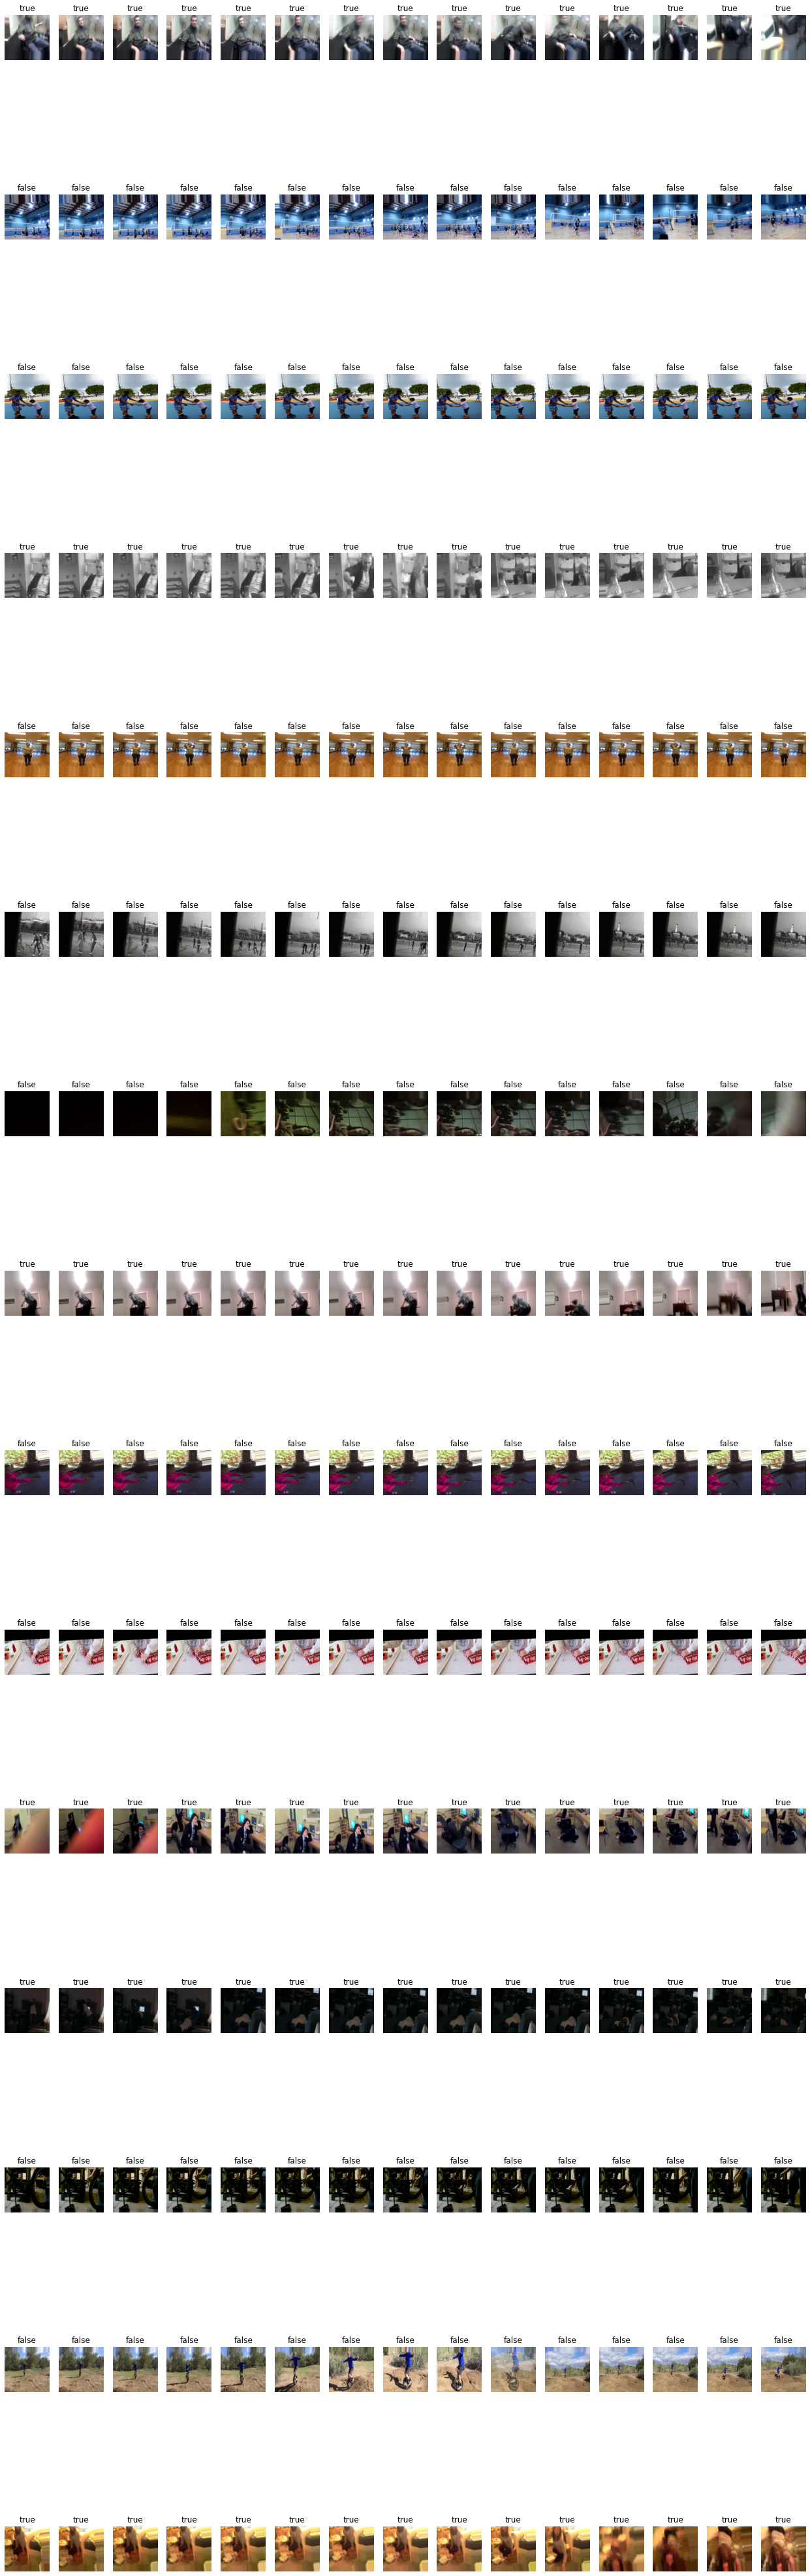

In [ ]:
import keras_video.utils

keras_video.utils.show_sample(train)

Build my model

In [ ]:
from keras.applications import VGG16
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import GlobalMaxPool2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

In [ ]:

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False

def action_model(shape=(NBFRAME, 150, 150, 3), nbout=2):
    
    # Flatten output of conv_base
    mod = Sequential()
    mod.add(conv_base)
    mod.add(GlobalMaxPool2D())
    # Build our model for training
    model = Sequential()
    model.add(TimeDistributed(mod, input_shape=shape))
    # LSTM for time series
    model.add(GRU(64))
    # Build the classifier
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
model = action_model(INSHAPE, len(classes))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 15, 512)           14714688  
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                110976    
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [ ]:
from keras.optimizers import Adam

optimizer= Adam(0.001)
model.compile(optimizer=optimizer , 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Train

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
                     filepath = 'fall_VGG16_sub2.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 ),
]

history = model.fit(train,
                    steps_per_epoch = 20, #23 43
                    epochs=35, #can change
                   # batch_size=8,
                    callbacks=callbacks,
                    validation_data=val,
                    validation_steps=10)

Epoch 1/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.634.mp4, 0 total, 0 extracted


18/20 [==========================>...] - ETA: 1s - loss: 0.6910 - accuracy: 0.5665

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.135.mp4, 0 total, 0 extracted


19/20 [===========================>..] - ETA: 0s - loss: 0.6919 - accuracy: 0.5666

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5661

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted


20/20 [==============================] - 23s 1s/step - loss: 0.6938 - accuracy: 0.5656 - val_loss: 0.6847 - val_accuracy: 0.5743
Epoch 2/35
 3/20 [===>..........................] - ETA: 15s - loss: 0.6971 - accuracy: 0.4593

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.307.mp4, 0 total, 0 extracted


11/20 [===============>..............] - ETA: 8s - loss: 0.7030 - accuracy: 0.4647

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.508.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.4694

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.7051 - accuracy: 0.4698 - val_loss: 0.6809 - val_accuracy: 0.6463
Epoch 3/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.730.mp4, 0 total, 0 extracted


 1/20 [>.............................] - ETA: 19s - loss: 0.6956 - accuracy: 0.6429

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.508.mp4, 0 total, 0 extracted


 8/20 [===========>..................] - ETA: 10s - loss: 0.7091 - accuracy: 0.5685

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.135.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.121.mp4, 0 total, 0 extracted


12/20 [=================>............] - ETA: 7s - loss: 0.7092 - accuracy: 0.5614

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted


14/20 [====================>.........] - ETA: 5s - loss: 0.7086 - accuracy: 0.5593

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


20/20 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.5491

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted


20/20 [==============================] - 20s 1s/step - loss: 0.7083 - accuracy: 0.5472 - val_loss: 0.6800 - val_accuracy: 0.5811
Epoch 4/35
 9/20 [============>.................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5396

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


10/20 [==============>...............] - ETA: 9s - loss: 0.6857 - accuracy: 0.5443 

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.508.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.5665

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.6819 - accuracy: 0.5675 - val_loss: 0.6003 - val_accuracy: 0.7517
Epoch 5/35
 3/20 [===>..........................] - ETA: 15s - loss: 0.6670 - accuracy: 0.5407

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.26.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.508.mp4, 0 total, 0 extracted


 7/20 [=========>....................] - ETA: 11s - loss: 0.6656 - accuracy: 0.5517

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


 8/20 [===========>..................] - ETA: 10s - loss: 0.6662 - accuracy: 0.5558

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.529.mp4, 0 total, 0 extracted


10/20 [==============>...............] - ETA: 9s - loss: 0.6645 - accuracy: 0.5632

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.563.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.5684

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.6741 - accuracy: 0.5685 - val_loss: 0.6285 - val_accuracy: 0.6803
Epoch 6/35
 2/20 [==>...........................] - ETA: 16s - loss: 0.6381 - accuracy: 0.6833

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.444.mp4, 0 total, 0 extracted


 4/20 [=====>........................] - ETA: 14s - loss: 0.6285 - accuracy: 0.6876

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.5869

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.6734 - accuracy: 0.5835 - val_loss: 0.6649 - val_accuracy: 0.5342
Epoch 7/35
 2/20 [==>...........................] - ETA: 17s - loss: 0.6395 - accuracy: 0.6667

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


 3/20 [===>..........................] - ETA: 15s - loss: 0.6413 - accuracy: 0.6793

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


15/20 [=====================>........] - ETA: 4s - loss: 0.6579 - accuracy: 0.6714

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.563.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.6698

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted


20/20 [==============================] - 20s 1s/step - loss: 0.6546 - accuracy: 0.6701 - val_loss: 0.5747 - val_accuracy: 0.6918
Epoch 8/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.444.mp4, 0 total, 0 extracted


 6/20 [========>.....................] - ETA: 12s - loss: 0.5743 - accuracy: 0.6890

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.730.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.580.mp4, 0 total, 0 extracted


13/20 [==================>...........] - ETA: 6s - loss: 0.5995 - accuracy: 0.6830

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.300.mp4, 0 total, 0 extracted


15/20 [=====================>........] - ETA: 4s - loss: 0.6047 - accuracy: 0.6812

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.26.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.6815

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.6083 - accuracy: 0.6816 - val_loss: 0.4818 - val_accuracy: 0.8014
Epoch 9/35
 3/20 [===>..........................] - ETA: 15s - loss: 0.7590 - accuracy: 0.5519

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


13/20 [==================>...........] - ETA: 6s - loss: 0.5996 - accuracy: 0.7086

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.564.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.5713 - accuracy: 0.7368

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.5701 - accuracy: 0.7391 - val_loss: 0.5580 - val_accuracy: 0.7192
Epoch 10/35
 2/20 [==>...........................] - ETA: 17s - loss: 0.5951 - accuracy: 0.7500

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.26.mp4, 0 total, 0 extracted


 3/20 [===>..........................] - ETA: 15s - loss: 0.5985 - accuracy: 0.7273

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.730.mp4, 0 total, 0 extracted


 4/20 [=====>........................] - ETA: 14s - loss: 0.5919 - accuracy: 0.7265

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.307.mp4, 0 total, 0 extracted


 5/20 [======>.......................] - ETA: 13s - loss: 0.5859 - accuracy: 0.7229

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.529.mp4, 0 total, 0 extracted


16/20 [=======================>......] - ETA: 3s - loss: 0.5445 - accuracy: 0.7336

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.444.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.7282

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted


20/20 [==============================] - 20s 1s/step - loss: 0.5499 - accuracy: 0.7269 - val_loss: 0.5816 - val_accuracy: 0.7055
Epoch 11/35
 1/20 [>.............................] - ETA: 21s - loss: 0.5860 - accuracy: 0.7333

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.730.mp4, 0 total, 0 extracted


 2/20 [==>...........................] - ETA: 14s - loss: 0.5127 - accuracy: 0.7632

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.580.mp4, 0 total, 0 extracted


10/20 [==============>...............] - ETA: 9s - loss: 0.5659 - accuracy: 0.7015 

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


16/20 [=======================>......] - ETA: 3s - loss: 0.5845 - accuracy: 0.6839

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.6831

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.5864 - accuracy: 0.6831 - val_loss: 0.5158 - val_accuracy: 0.7297
Epoch 12/35
 9/20 [============>.................] - ETA: 10s - loss: 0.5477 - accuracy: 0.7361

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


16/20 [=======================>......] - ETA: 3s - loss: 0.5226 - accuracy: 0.7611

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.300.mp4, 0 total, 0 extracted


19/20 [===========================>..] - ETA: 0s - loss: 0.5190 - accuracy: 0.7659

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.135.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.7668

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.5195 - accuracy: 0.7677 - val_loss: 0.5470 - val_accuracy: 0.7095
Epoch 13/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.508.mp4, 0 total, 0 extracted


 2/20 [==>...........................] - ETA: 15s - loss: 0.2759 - accuracy: 0.9322

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.307.mp4, 0 total, 0 extracted


 7/20 [=========>....................] - ETA: 11s - loss: 0.3637 - accuracy: 0.8785

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.563.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.121.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4148 - accuracy: 0.8362

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted


20/20 [==============================] - 20s 1s/step - loss: 0.4170 - accuracy: 0.8344 - val_loss: 0.5586 - val_accuracy: 0.6892
Epoch 14/35
 2/20 [==>...........................] - ETA: 16s - loss: 0.3886 - accuracy: 0.7500

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.444.mp4, 0 total, 0 extracted


 4/20 [=====>........................] - ETA: 14s - loss: 0.4431 - accuracy: 0.7196

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.564.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.7467

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.121.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted


20/20 [==============================] - 20s 1s/step - loss: 0.4848 - accuracy: 0.7470 - val_loss: 0.5133 - val_accuracy: 0.7432
Epoch 15/35
 6/20 [========>.....................] - ETA: 13s - loss: 0.5462 - accuracy: 0.7833

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.580.mp4, 0 total, 0 extracted


15/20 [=====================>........] - ETA: 4s - loss: 0.5511 - accuracy: 0.7422

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


20/20 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.7237

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted


20/20 [==============================] - 22s 1s/step - loss: 0.5617 - accuracy: 0.7207 - val_loss: 0.5102 - val_accuracy: 0.7945
Epoch 16/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted


 9/20 [============>.................] - ETA: 10s - loss: 0.5435 - accuracy: 0.7292

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


11/20 [===============>..............] - ETA: 8s - loss: 0.5440 - accuracy: 0.7311

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.730.mp4, 0 total, 0 extracted


13/20 [==================>...........] - ETA: 6s - loss: 0.5474 - accuracy: 0.7283

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.307.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.5461 - accuracy: 0.7299

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.5454 - accuracy: 0.7308 - val_loss: 0.4818 - val_accuracy: 0.7603
Epoch 17/35
 3/20 [===>..........................] - ETA: 16s - loss: 0.3944 - accuracy: 0.8556

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.563.mp4, 0 total, 0 extracted


 7/20 [=========>....................] - ETA: 11s - loss: 0.4788 - accuracy: 0.7639

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.634.mp4, 0 total, 0 extracted


 8/20 [===========>..................] - ETA: 11s - loss: 0.4949 - accuracy: 0.7542

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.121.mp4, 0 total, 0 extracted


 9/20 [============>.................] - ETA: 10s - loss: 0.5052 - accuracy: 0.7487

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


12/20 [=================>............] - ETA: 7s - loss: 0.5217 - accuracy: 0.7411

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


18/20 [==========================>...] - ETA: 1s - loss: 0.5311 - accuracy: 0.7356

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.300.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.5327 - accuracy: 0.7352

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.5335 - accuracy: 0.7351 - val_loss: 0.5822 - val_accuracy: 0.6510
Epoch 18/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.529.mp4, 0 total, 0 extracted


15/20 [=====================>........] - ETA: 4s - loss: 0.4950 - accuracy: 0.8005

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.26.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.580.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4886 - accuracy: 0.7979

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4879 - accuracy: 0.7974 - val_loss: 0.5118 - val_accuracy: 0.7534

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 19/35
 3/20 [===>..........................] - ETA: 15s - loss: 0.4925 - accuracy: 0.7556

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.26.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.634.mp4, 0 total, 0 extracted


 4/20 [=====>........................] - ETA: 14s - loss: 0.4897 - accuracy: 0.7477

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted


10/20 [==============>...............] - ETA: 9s - loss: 0.4779 - accuracy: 0.7657

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.563.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4753 - accuracy: 0.7778

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted


20/20 [==============================] - 20s 1s/step - loss: 0.4753 - accuracy: 0.7785 - val_loss: 0.4214 - val_accuracy: 0.7755
Epoch 20/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.634.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.135.mp4, 0 total, 0 extracted


 8/20 [===========>..................] - ETA: 11s - loss: 0.4180 - accuracy: 0.7954

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.508.mp4, 0 total, 0 extracted


10/20 [==============>...............] - ETA: 9s - loss: 0.4159 - accuracy: 0.7977 

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.26.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8003

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4178 - accuracy: 0.8003 - val_loss: 0.4863 - val_accuracy: 0.7584
Epoch 21/35
 2/20 [==>...........................] - ETA: 17s - loss: 0.5536 - accuracy: 0.8333

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.580.mp4, 0 total, 0 extracted


 5/20 [======>.......................] - ETA: 13s - loss: 0.5358 - accuracy: 0.8306

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.444.mp4, 0 total, 0 extracted


18/20 [==========================>...] - ETA: 1s - loss: 0.4804 - accuracy: 0.8119

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.135.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


19/20 [===========================>..] - ETA: 0s - loss: 0.4781 - accuracy: 0.8118

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.529.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.8120

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4729 - accuracy: 0.8122 - val_loss: 0.5038 - val_accuracy: 0.7379
Epoch 22/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.508.mp4, 0 total, 0 extracted


 3/20 [===>..........................] - ETA: 15s - loss: 0.4543 - accuracy: 0.7371

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted


 4/20 [=====>........................] - ETA: 14s - loss: 0.4530 - accuracy: 0.7511

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.300.mp4, 0 total, 0 extracted


12/20 [=================>............] - ETA: 7s - loss: 0.4367 - accuracy: 0.7960

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


16/20 [=======================>......] - ETA: 3s - loss: 0.4342 - accuracy: 0.8036

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.580.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4352 - accuracy: 0.8052

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted


20/20 [==============================] - 20s 1s/step - loss: 0.4354 - accuracy: 0.8053 - val_loss: 0.5013 - val_accuracy: 0.7584
Epoch 23/35
 3/20 [===>..........................] - ETA: 15s - loss: 0.6048 - accuracy: 0.6852

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.307.mp4, 0 total, 0 extracted


 9/20 [============>.................] - ETA: 10s - loss: 0.5318 - accuracy: 0.7449

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.26.mp4, 0 total, 0 extracted


12/20 [=================>............] - ETA: 7s - loss: 0.5165 - accuracy: 0.7586

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.300.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.444.mp4, 0 total, 0 extracted


13/20 [==================>...........] - ETA: 6s - loss: 0.5144 - accuracy: 0.7614

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.135.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.5044 - accuracy: 0.7714

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.5038 - accuracy: 0.7717 - val_loss: 0.4699 - val_accuracy: 0.7703
Epoch 24/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


 2/20 [==>...........................] - ETA: 16s - loss: 0.3836 - accuracy: 0.7126

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


 3/20 [===>..........................] - ETA: 15s - loss: 0.4043 - accuracy: 0.7154

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.307.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.7479

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4574 - accuracy: 0.7487 - val_loss: 0.5280 - val_accuracy: 0.7432


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted


Epoch 25/35
 1/20 [>.............................] - ETA: 19s - loss: 0.5450 - accuracy: 0.7857

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.444.mp4, 0 total, 0 extracted


 2/20 [==>...........................] - ETA: 15s - loss: 0.4985 - accuracy: 0.7857

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.307.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.7533

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.26.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4895 - accuracy: 0.7532 - val_loss: 0.3752 - val_accuracy: 0.8095
Epoch 26/35
 7/20 [=========>....................] - ETA: 12s - loss: 0.4445 - accuracy: 0.8167

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.529.mp4, 0 total, 0 extracted


 8/20 [===========>..................] - ETA: 10s - loss: 0.4378 - accuracy: 0.8239

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.730.mp4, 0 total, 0 extracted


 9/20 [============>.................] - ETA: 9s - loss: 0.4368 - accuracy: 0.8259 

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


10/20 [==============>...............] - ETA: 8s - loss: 0.4351 - accuracy: 0.8277

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.564.mp4, 0 total, 0 extracted


13/20 [==================>...........] - ETA: 6s - loss: 0.4298 - accuracy: 0.8328

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.135.mp4, 0 total, 0 extracted


14/20 [====================>.........] - ETA: 5s - loss: 0.4281 - accuracy: 0.8339

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.444.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.8386

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted


20/20 [==============================] - 20s 1s/step - loss: 0.4210 - accuracy: 0.8382 - val_loss: 0.5410 - val_accuracy: 0.7162
Epoch 27/35
 1/20 [>.............................] - ETA: 20s - loss: 0.2622 - accuracy: 0.8667

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted


 2/20 [==>...........................] - ETA: 14s - loss: 0.3309 - accuracy: 0.8299

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.634.mp4, 0 total, 0 extracted


18/20 [==========================>...] - ETA: 1s - loss: 0.4215 - accuracy: 0.7831

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.7854

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4224 - accuracy: 0.7865 - val_loss: 0.4191 - val_accuracy: 0.8041
Epoch 28/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.580.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.7860

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.135.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4670 - accuracy: 0.7849 - val_loss: 0.4441 - val_accuracy: 0.7687
Epoch 29/35
 7/20 [=========>....................] - ETA: 12s - loss: 0.3836 - accuracy: 0.8080

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.730.mp4, 0 total, 0 extracted


12/20 [=================>............] - ETA: 7s - loss: 0.4036 - accuracy: 0.8053

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.580.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4216 - accuracy: 0.7978

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4222 - accuracy: 0.7976 - val_loss: 0.5238 - val_accuracy: 0.7297
Epoch 30/35
 1/20 [>.............................] - ETA: 20s - loss: 0.4971 - accuracy: 0.8000

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.634.mp4, 0 total, 0 extracted


 8/20 [===========>..................] - ETA: 10s - loss: 0.4333 - accuracy: 0.8210

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.553.mp4, 12 total, 12 extracted


14/20 [====================>.........] - ETA: 5s - loss: 0.4309 - accuracy: 0.8169

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.508.mp4, 0 total, 0 extracted


15/20 [=====================>........] - ETA: 4s - loss: 0.4321 - accuracy: 0.8159

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.529.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.8097

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4362 - accuracy: 0.8088 - val_loss: 0.4927 - val_accuracy: 0.7584
Epoch 31/35
 1/20 [>.............................] - ETA: 20s - loss: 0.2554 - accuracy: 0.8667

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


 4/20 [=====>........................] - ETA: 14s - loss: 0.3786 - accuracy: 0.8414

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.307.mp4, 0 total, 0 extracted


10/20 [==============>...............] - ETA: 9s - loss: 0.3984 - accuracy: 0.8455 

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.634.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.8423

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.3995 - accuracy: 0.8415 - val_loss: 0.4129 - val_accuracy: 0.7987
Epoch 32/35
 4/20 [=====>........................] - ETA: 14s - loss: 0.4907 - accuracy: 0.8208

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.634.mp4, 0 total, 0 extracted


13/20 [==================>...........] - ETA: 6s - loss: 0.5019 - accuracy: 0.7782

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.135.mp4, 0 total, 0 extracted


16/20 [=======================>......] - ETA: 3s - loss: 0.4950 - accuracy: 0.7817

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.580.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.7857

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.224.mp4, 10 total, 10 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4874 - accuracy: 0.7860 - val_loss: 0.4836 - val_accuracy: 0.7651
Epoch 33/35
 3/20 [===>..........................] - ETA: 15s - loss: 0.3655 - accuracy: 0.8963

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.634.mp4, 0 total, 0 extracted


10/20 [==============>...............] - ETA: 9s - loss: 0.3984 - accuracy: 0.8584

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.730.mp4, 0 total, 0 extracted


15/20 [=====================>........] - ETA: 4s - loss: 0.3924 - accuracy: 0.8535

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.580.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.8542

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.47.mp4, 12 total, 12 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.3855 - accuracy: 0.8542 - val_loss: 0.4400 - val_accuracy: 0.7770
Epoch 34/35


Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.307.mp4, 0 total, 0 extracted


 2/20 [==>...........................] - ETA: 16s - loss: 0.2504 - accuracy: 0.9126

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.529.mp4, 0 total, 0 extracted


 4/20 [=====>........................] - ETA: 14s - loss: 0.3177 - accuracy: 0.8768

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.121.mp4, 0 total, 0 extracted


 7/20 [=========>....................] - ETA: 11s - loss: 0.3659 - accuracy: 0.8640

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.706.mp4, 0 total, 0 extracted


17/20 [========================>.....] - ETA: 2s - loss: 0.3961 - accuracy: 0.8523

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/false/not fall.26.mp4, 0 total, 0 extracted


18/20 [==========================>...] - ETA: 1s - loss: 0.3982 - accuracy: 0.8513

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.505.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.8497

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted


20/20 [==============================] - 20s 1s/step - loss: 0.4046 - accuracy: 0.8491 - val_loss: 0.5705 - val_accuracy: 0.6913
Epoch 35/35
19/20 [===========================>..] - ETA: 0s - loss: 0.4550 - accuracy: 0.7707

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.121.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4548 - accuracy: 0.7715

Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.781.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.416.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/fallvideos/content/kinetics700/train/true/fall.90.mp4, 0 total, 0 extracted


20/20 [==============================] - 21s 1s/step - loss: 0.4546 - accuracy: 0.7721 - val_loss: 0.4927 - val_accuracy: 0.7619

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


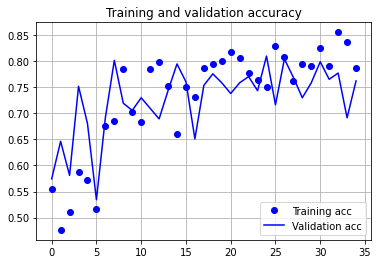

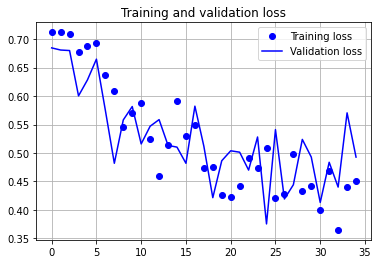

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(axis='both')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(axis='both')
plt.legend()

plt.show()

In [ ]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 15
BS = 5
glob_pattern='/content/fallvideos/content/kinetics700/test/{classname}/*.mp4'

# make video frame generator
test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 2 classes for 94 files for train


In [ ]:
model.evaluate(test)

15/18 [========================>.....] - ETA: 3s - loss: 0.5999 - accuracy: 0.7600

Frame count is not OK for video /content/fallvideos/content/kinetics700/test/true/fall.7.mp4, 0 total, 0 extracted


18/18 [==============================] - 18s 1s/step - loss: 0.6218 - accuracy: 0.7416


[0.6217633485794067, 0.7415730357170105]